In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline


INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
base_folder='/grid/gillis/data_norepl/lohia'


In [3]:
marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='1kbp_raw'


In [5]:
base_folder='/grid/gillis/data_norepl/lohia'


In [6]:
marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)
marker_list['gene'] = marker_list['gene'].str.upper()
marker_list['gene'].drop_duplicates(inplace=True)
df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene')

heart_markers = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)

heart_markers['gene'] = heart_markers['gene'].str.upper()
heart_markers['gene'].drop_duplicates(inplace=True)
marker_list_heart = heart_markers.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene')

cat_list_genes = marker_list['Ensembl_gene_identifier'].drop_duplicates().tolist()

cat_list_genes.extend(marker_list_heart['Ensembl_gene_identifier'].drop_duplicates().tolist())

cat_list_genes = list(set(cat_list_genes))

In [7]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b {base_folder}/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    #exp_file = hm.hiCMatrix(f'{base_folder}/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    #exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    #chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    df_genes_chrom = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_gene_max.bed', names=['chrom', 'st', 'end', 'gene'])
                
                
    
    
    
    with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_max.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_max.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(df_genes_chrom['gene'].tolist(), df_genes_chrom['chrom'].tolist()):
                                  #if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_max.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(df_genes_chrom['gene'].tolist(), df_genes_chrom['chrom'].tolist()):
                                  #if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [9]:
del marker_contacts_list_inter
gc.collect()


0

In [11]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  


In [12]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


In [115]:
del df_gene_tp
gc.collect()

89

In [491]:
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)

<ipython-input-491-e63839d52191>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]


<ipython-input-492-22f799e30c6c>:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


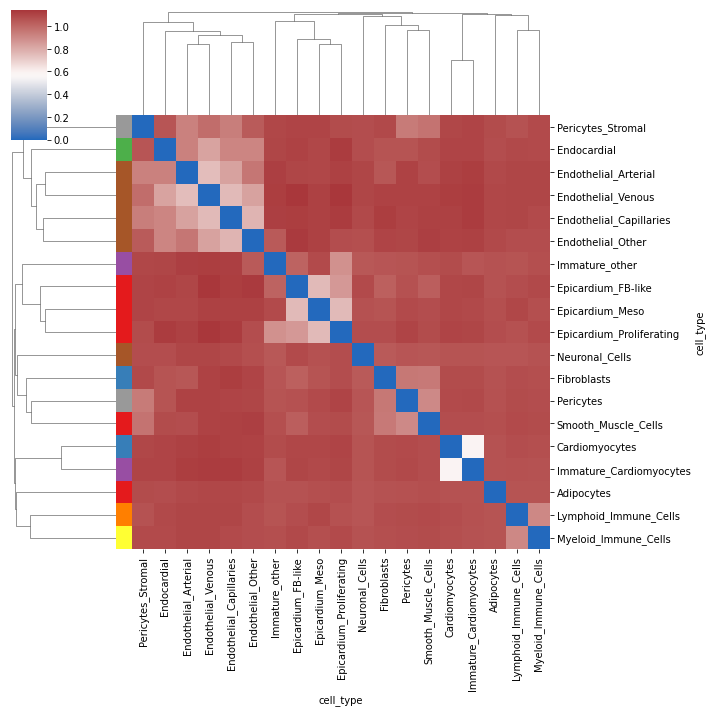

In [492]:
marker_list = marker_list[marker_list['rank'] < 100]
marker_list['gene'] = marker_list['gene'].str.upper()
df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
marker_table = marker_list.pivot_table(index='gene', columns='cell_type', values='rank', aggfunc='sum')
marker_table.fillna(0, inplace=True)
marker_table[marker_table != 0] = 1


#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)

dk = marker_table.T
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [260]:
for number_of_times in range(1):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list[marker_list['rank'] < 100]
            #marker_list = marker_list.sort_values(by=['rank',  'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            

<ipython-input-260-47569f946f2c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]


In [264]:
pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz')



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Meta marker list generated on 2023-08-28. Ordered by recurrence among DE genes (FC >= 4  \
0                                                   group                                          
1                                                     all                                          
2                                                     all                                          
3                                                     all                                          
4                                                     all                                          
...                                                   ...                                          
393296                                                all                                          
393297                                                all                                          
393298                                                all                                          
393299                                                all                                          
393300                                                all                                          

                FDR <= 0.05  detection_rate >= 0)  \
0                 cell_type                  gene   
1                Adipocytes                KCNJ10   
2                Adipocytes             CXXC4-AS1   
3                Adipocytes              TMEM132E   
4                Adipocytes                  EMC7   
...                     ...                   ...   
393296  Smooth_Muscle_Cells                 RPL36   
393297  Smooth_Muscle_Cells                  BTG1   
393298  Smooth_Muscle_Cells                   B2M   
393299  Smooth_Muscle_Cells                RNASE1   
393300  Smooth_Muscle_Cells              HSP90AA1   

        then auroc. Based on: group          cell_type                gene  \
0                       fold_change              auroc             log_fdr   
1                  265.656757845114  0.999902874902875  -0.818997648642415   
2                  248.894538823114  0.999838124838125  -0.818633471640567   
3                   238.94318708463  0.999773374773375  -0.818275640400163   
4                  20.8958411992405    0.9996114996115  -0.817334887490431   
...                             ...                ...                 ...   
393296                     0.746748            0.38007                   0   
393297                     0.432547           0.379132                   0   
393298                     0.391459            0.37609                   0   
393299                      0.03195            0.37261                   0   
393300                     0.563542           0.348166                   0   

            fold_change                 auroc             log_fdr  \
0       population_size   population_fraction  average_expression   
1                     1  3.23739842662436e-05    315.656565656566   
2                     1  3.23739842662436e-05    315.656565656566   
3                     1  3.23739842662436e-05    315.656565656566   
4                     1  3.23739842662436e-05    1262.62626262626   
...                 ...                   ...                 ...   
393296             3020              0.097769         1374.400377   
393297             3020              0.097769           135.20497   
393298             3020              0.097769          631.357652   
393299             3020              0.097769           16.452074   
393300             3020              0.097769          642.704924   

        population_size  population_fraction     average_expression  \
0         se_expression       detection_rate  fold_change_detection   
1                     0                    1       476.496239674516   
2                     0                    1        382.24320047473   
3                     0                    1       396.966002465078   
4                     0                    1    

<Axes: xlabel='rank', ylabel='Count'>

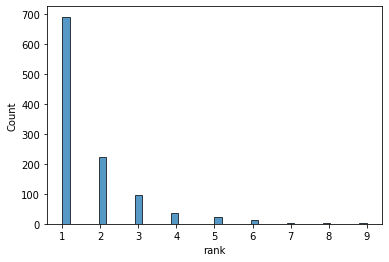

In [266]:
sns.histplot(marker_list.groupby(['Ensembl_gene_identifier'])['rank'].count())

In [272]:
marker_list.groupby(['cell_type'])['rank'].count().reset_index()

cell_type  rank
0     Astro_1    76
1     Astro_2    92
2     Astro_3    60
3     Astro_4    38
4     Astro_5    64
..        ...   ...
165     Vip_5    43
166     Vip_6    30
167     Vip_7    32
168     Vip_8    45
169     Vip_9    34

[170 rows x 2 columns]

In [259]:
marker_list.groupby(['cell_type'])['rank'].count()

cell_type
Adipocytes                  91
Cardiomyocytes              55
Endocardial                 46
Endothelial_Arterial        41
Endothelial_Capillaries     38
Endothelial_Other           45
Endothelial_Venous          31
Epicardium_FB-like          51
Epicardium_Meso             54
Epicardium_Proliferating    35
Fibroblasts                 65
Immature_Cardiomyocytes     70
Immature_other              71
Lymphoid_Immune_Cells       80
Myeloid_Immune_Cells        78
Neuronal_Cells              80
Pericytes                   62
Pericytes_Stromal           44
Smooth_Muscle_Cells         50
Name: rank, dtype: int64

In [ ]:
no_of_markers

In [514]:
df_list_heart_repeat  = []
for number_of_times in range(10):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list[marker_list['rank'] < 500]
            #marker_list['count'] = marker_list.groupby(['Ensembl_gene_identifier'])['rank'].count().reset_index()['rank'].tolist()
            #marker_list = marker_list[marker_list['count'] < 5]
            marker_list = marker_list[marker_list['cell_type'] != 'Immature_Cardiomyocytes']
            #marker_list['cell_type'] = ['Cardiomyocytes_Immature' if x == ]
            #marker_list['group'] = [x.split('_')[0] for x in marker_list['cell_type']]
            
            #marker_list = marker_list[marker_list['cell_type'] != 'IPer']
            
            #marker_list['group'] = [x.split('_')[0] for x in marker_list['cell_type']]
            
            #marker_list = marker_list[marker_list['cell_type'] != 'Epicardium_Meso']
            marker_list = marker_list.sort_values(by=[ 'rank','auroc',  'fold_change']).drop_duplicates(subset=['Ensembl_gene_identifier'] )
            #marker_list = marker_list.sort_values(by=['rank',  'auroc'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 500]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by='rank')
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart_repeat.append(df_gene_tp_all_info_mean)

            


<ipython-input-514-b70aa0c1f7d4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]


MemoryError: Unable to allocate 44.7 GiB for an array with shape (2875012, 4173) and data type float32

In [531]:
len(df_list_heart_50)

NameError: name 'df_list_heart_50' is not defined

In [516]:
gc.collect()

779

In [527]:
len(df_list_heart_1000)

5

<ipython-input-528-88fc40a1481a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


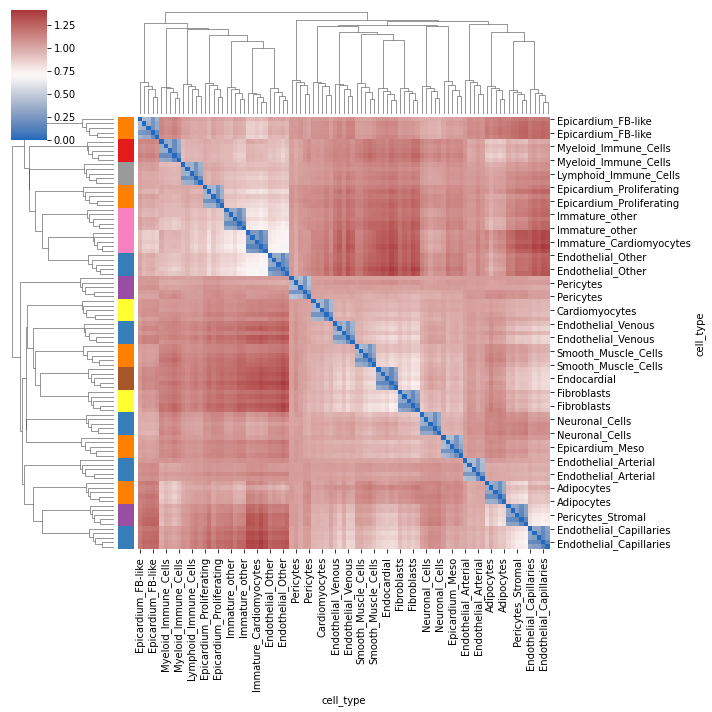

In [528]:
#dj = pd.concat(df_list)
dk = pd.concat(df_list_heart_1000)
#dk = df_gene_tp_all_info_mean
#dk = pd.concat(df_list_heart_repeat)
#dk = df_list_heart[0]
#df_gene_tp_all_info['cell_type'] = df_gene_tp_all_info['group'].tolist()
#dk = df_gene_tp_all_info.groupby(['group', 'boot_id', 'cell_type']).mean()
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


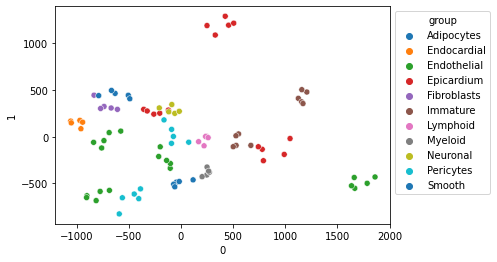

In [529]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d = df_proj_2d[df_proj_2d['group'] != 'Cardiomyocytes']
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
from sklearn.decomposition import PCA

umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2d = umap_2d.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d = df_proj_2d[df_proj_2d['group'] != 'Cardiomyocytes']
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-521-4cdf74b2b26e>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


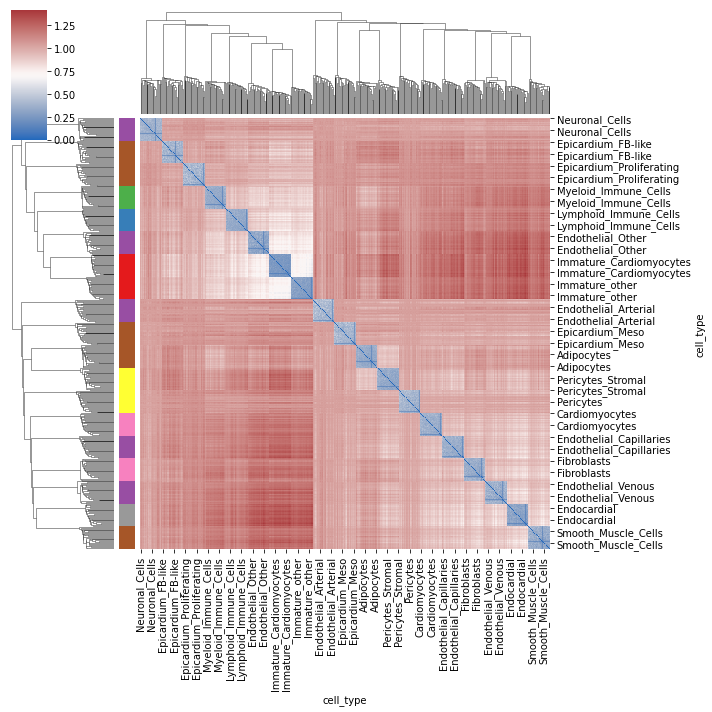

In [521]:
#dj = pd.concat(df_list)
dk = pd.concat(df_list_heart_400)
#dk = df_gene_tp_all_info_mean
#dk = pd.concat(df_list_heart_repeat)
#dk = df_list_heart[0]
#df_gene_tp_all_info['cell_type'] = df_gene_tp_all_info['group'].tolist()
#dk = df_gene_tp_all_info.groupby(['group', 'boot_id', 'cell_type']).mean()
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


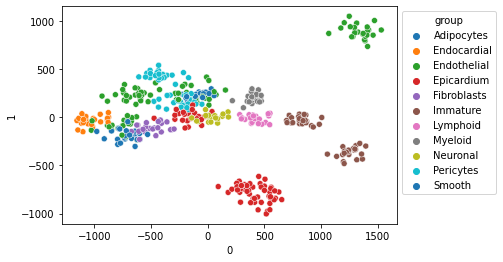

In [522]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d = df_proj_2d[df_proj_2d['group'] != 'Cardiomyocytes']
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


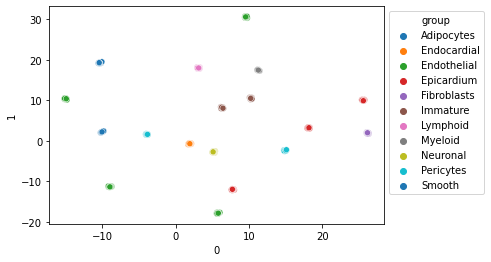

In [523]:
from sklearn.decomposition import PCA

umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2d = umap_2d.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d = df_proj_2d[df_proj_2d['group'] != 'Cardiomyocytes']
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


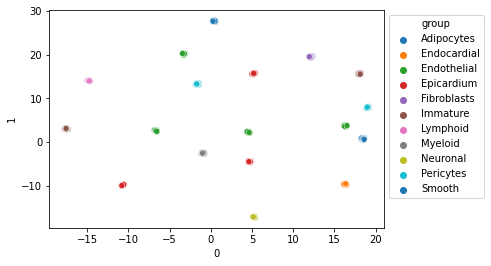

In [524]:
umap_2d = UMAP(n_components=2, init='random', random_state=1)
proj_2d = umap_2d.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d = df_proj_2d[df_proj_2d['group'] != 'Cardiomyocytes']
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


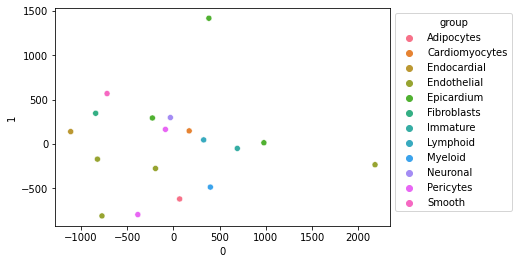

In [501]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group']
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

NameError: name 'k' is not defined

<ipython-input-211-cd290e9ca24e>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


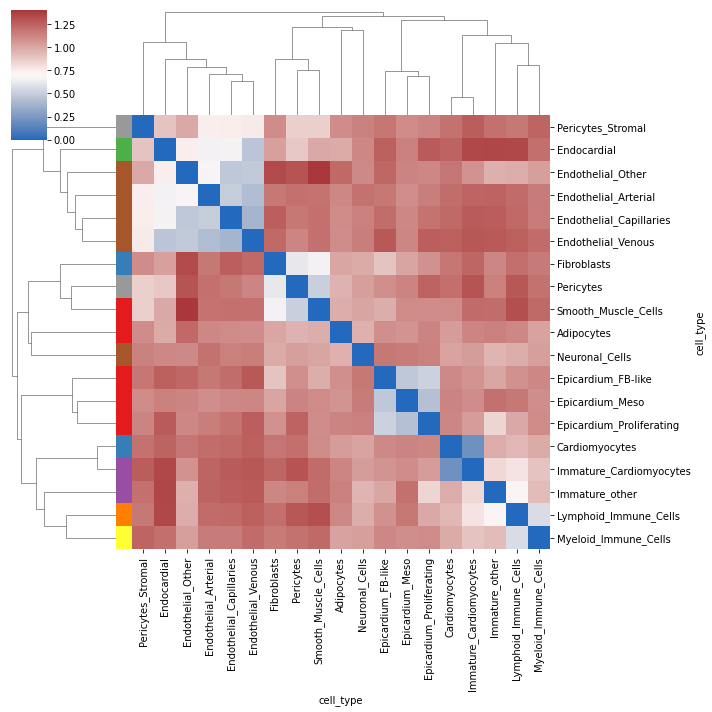

In [211]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_repeat)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-178-cd290e9ca24e>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


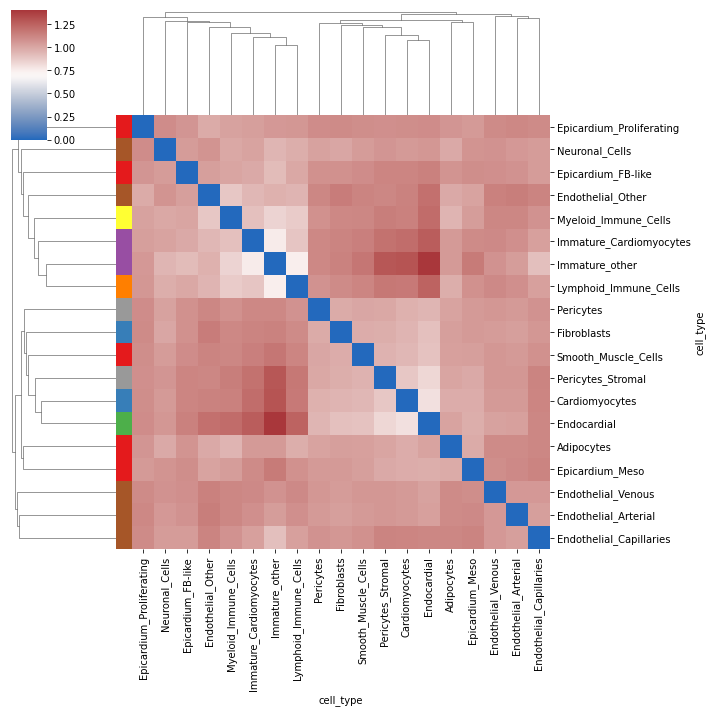

In [178]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_repeat)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [290]:
len(df_list_brain)

22

<ipython-input-159-cd290e9ca24e>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


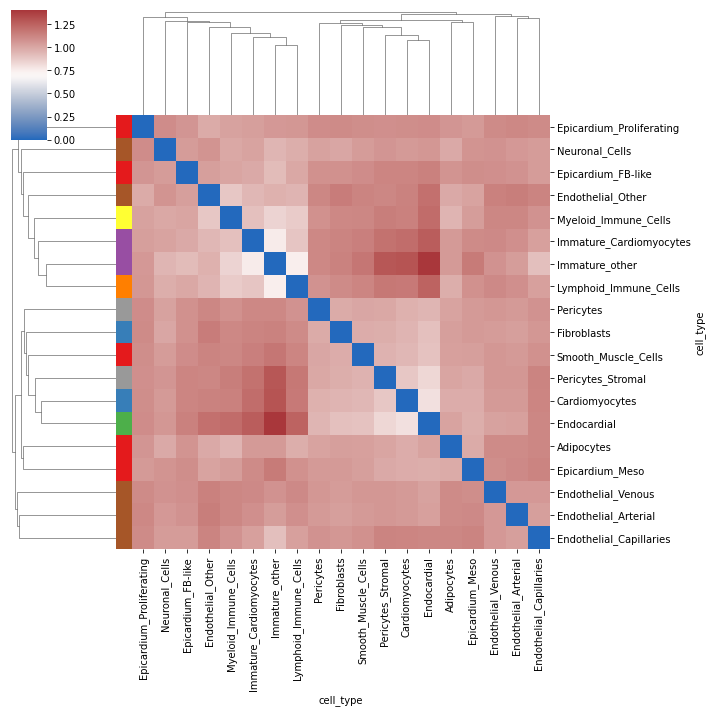

In [159]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_repeat)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


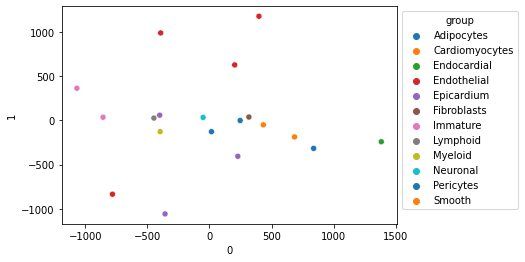

In [179]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


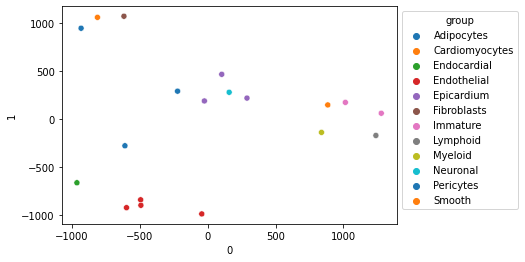

In [212]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


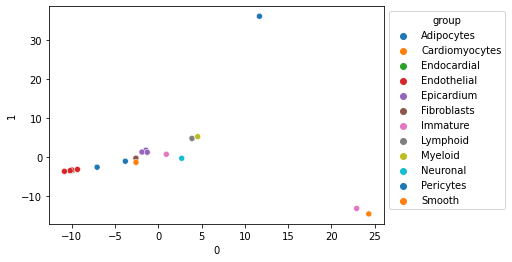

In [226]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


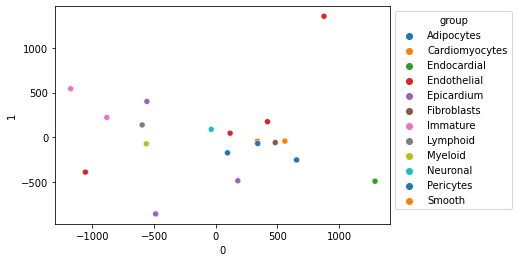

In [215]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


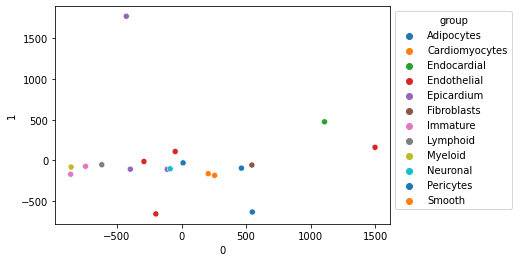

In [229]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


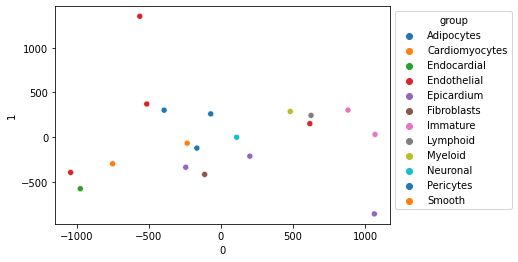

In [287]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


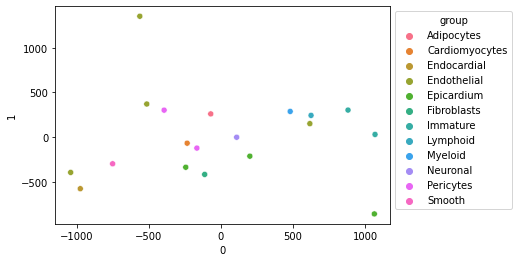

In [288]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group']
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [180]:
umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


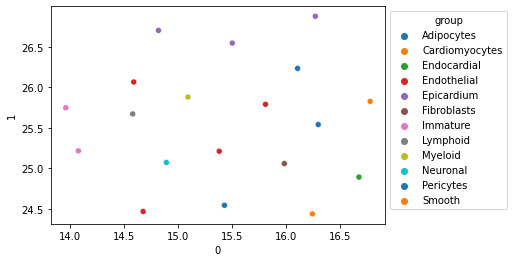

In [181]:
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


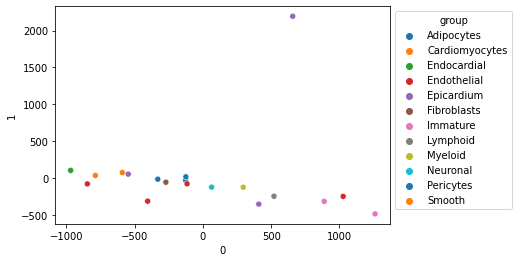

In [169]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


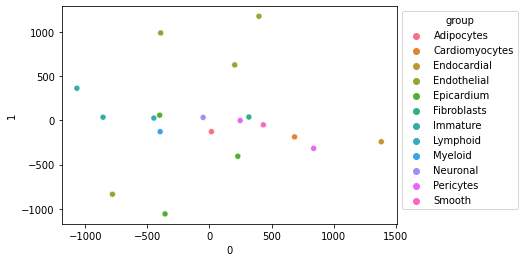

In [161]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group']
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [540]:
            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            marker_list = marker_list[marker_list['rank'] < 1000]
            marker_table = marker_list.pivot_table(index='gene', columns='cell_type', values='rank', aggfunc='sum')
            marker_table.fillna(0, inplace=True)
            marker_table[marker_table != 0] = 1

<ipython-input-541-40da24d5fc0f>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


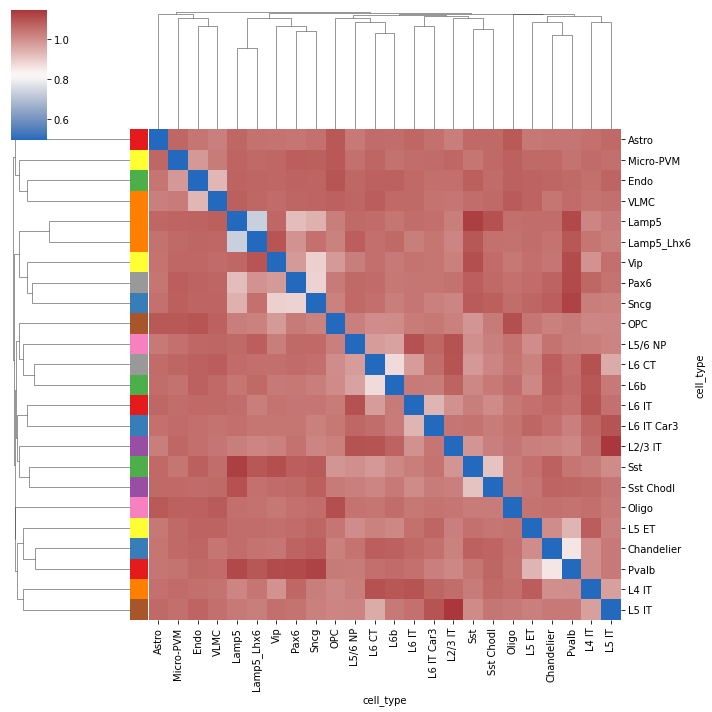

In [541]:
dk = marker_table.T
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors,vmin=0.5)

In [580]:
df_list_brain_repeat  = []
for i in range(0,1):
    

            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
for group2 in all_cell_types:
    
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [1000]
    marker_level_list = ['subclass']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:


            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'], keep=False)
 

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
            df2_list = []



            for i in range(0,1):
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                
                m_tmp = m_tmp[m_tmp['rank'] <1000]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                #df2_list.append(bootstrap_sample)
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'type':

        marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


        marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])
    
    df_gene_tp_all_info['boot_id'] = number_of_times

    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'boot_id']).mean()
    
    #df_list.append(df_gene_tp_all_info_mean)
    
    df_list_brain_repeat.append(df_gene_tp_all_info_mean)

<ipython-input-581-807a2edaf741>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


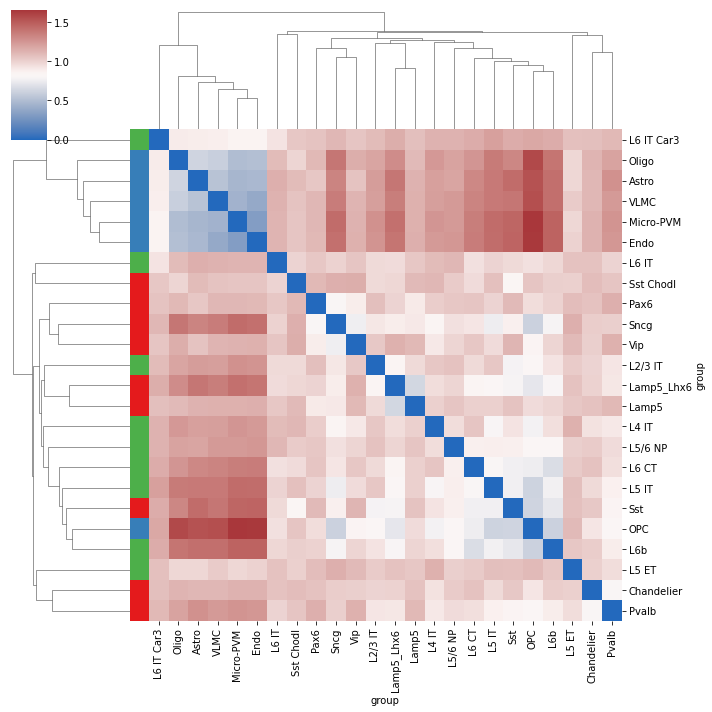

In [581]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dk = pd.concat(df_list_brain_repeat)
#dk = dk.reset_index()
#dk = dk[dk['classt']!="Other"]
#dk = dk.groupby(['classt', 'group','boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


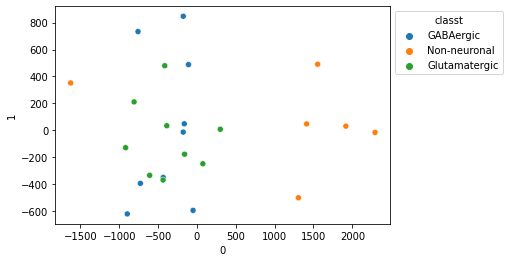

In [585]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


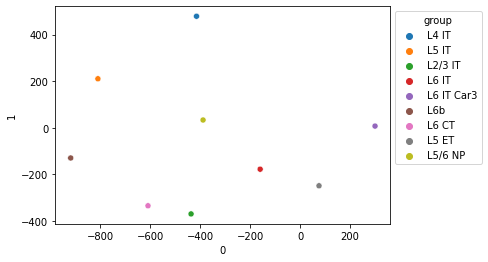

In [586]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


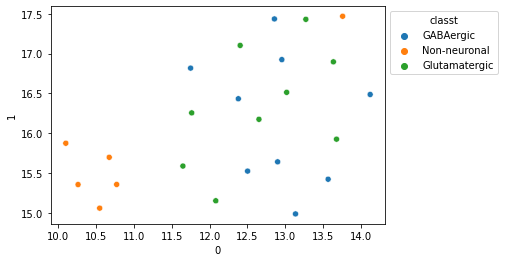

In [584]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [571]:
df_list_brain_repeat  = []
for i in range(0,1):
    

            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
for group2 in all_cell_types:
    
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [1000]
    marker_level_list = ['subclass']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:


            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'], keep=False)
 

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
            df2_list = []



            for i in range(0,1):
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                
                m_tmp = m_tmp[m_tmp['rank'] <1000]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                #df2_list.append(bootstrap_sample)
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'type':

        marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


        marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])
    
    df_gene_tp_all_info['boot_id'] = number_of_times

    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'boot_id']).mean()
    
    #df_list.append(df_gene_tp_all_info_mean)
    
    df_list_brain_repeat.append(df_gene_tp_all_info_mean)

<ipython-input-572-807a2edaf741>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


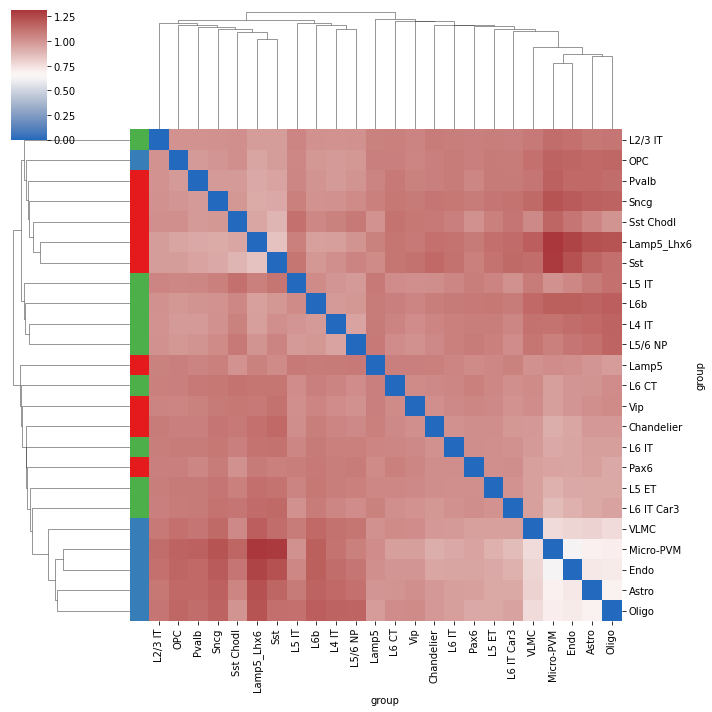

In [572]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dk = pd.concat(df_list_brain_repeat)
#dk = dk.reset_index()
#dk = dk[dk['classt']!="Other"]
#dk = dk.groupby(['classt', 'group','boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


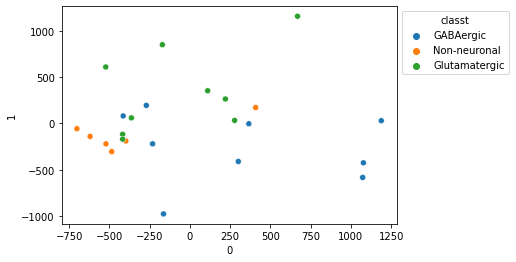

In [578]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


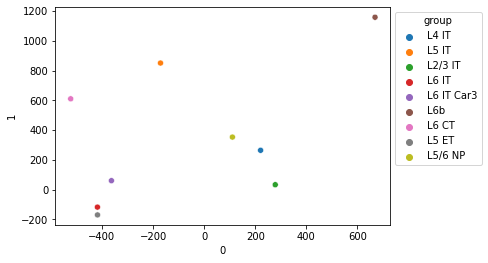

In [579]:

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


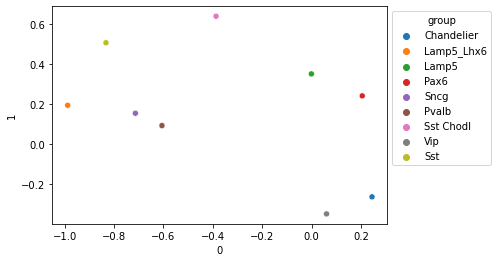

In [576]:

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'GABAergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-561-807a2edaf741>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


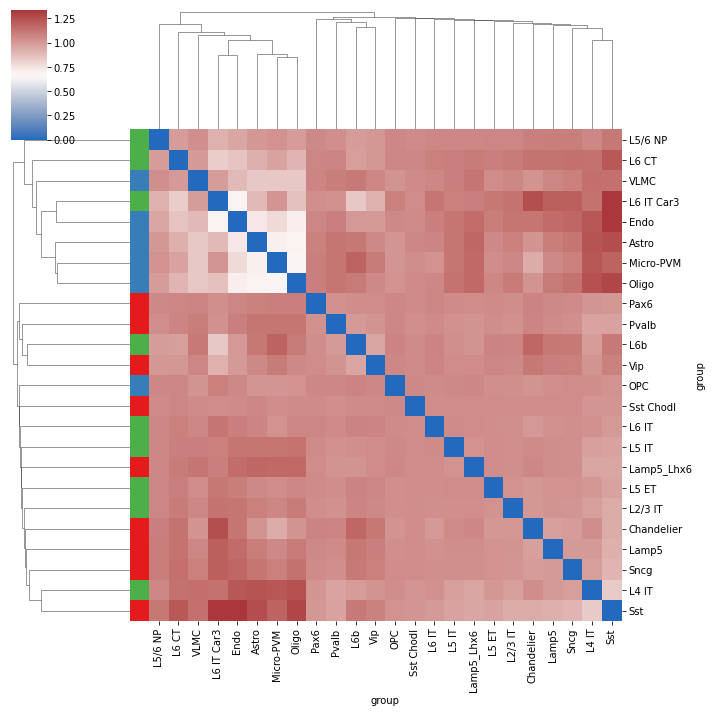

In [561]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dk = pd.concat(df_list_brain_repeat)
#dk = dk.reset_index()
#dk = dk[dk['classt']!="Other"]
#dk = dk.groupby(['classt', 'group','boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


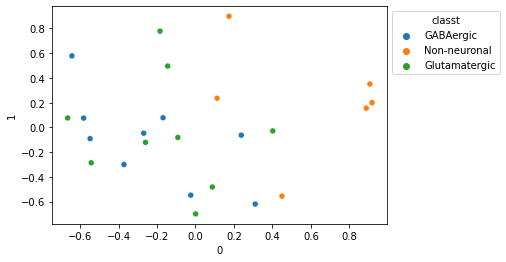

In [570]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


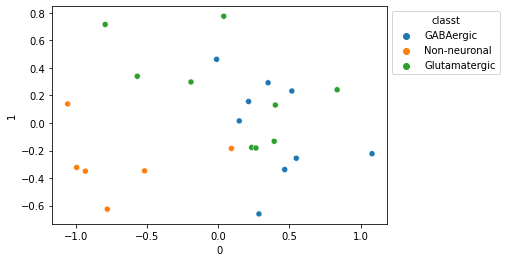

In [563]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


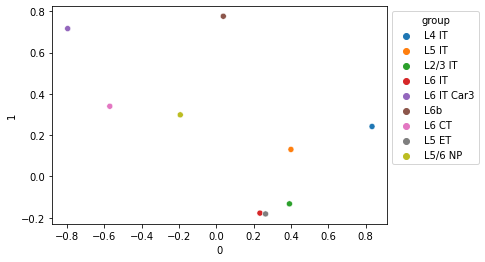

In [566]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [542]:
df_list_brain_repeat  = []
for i in range(0,1):
    

            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
for group2 in all_cell_types:
    
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [1000]
    marker_level_list = ['subclass']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:


            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
 

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
            df2_list = []



            for i in range(0,1):
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                
                m_tmp = m_tmp[m_tmp['rank'] <400]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                #df2_list.append(bootstrap_sample)
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'type':

        marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


        marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])
    
    df_gene_tp_all_info['boot_id'] = number_of_times

    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'boot_id']).mean()
    
    #df_list.append(df_gene_tp_all_info_mean)
    
    df_list_brain_repeat.append(df_gene_tp_all_info_mean)

<ipython-input-543-807a2edaf741>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


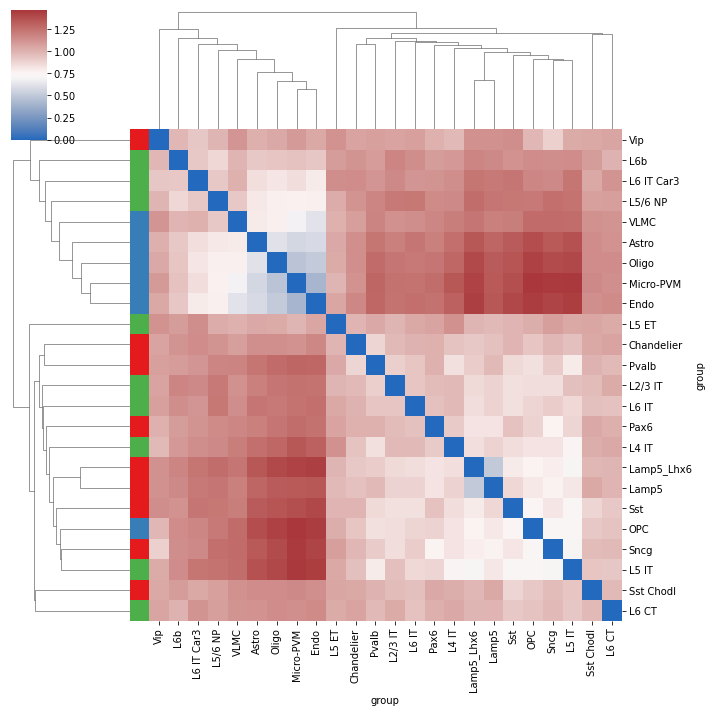

In [543]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dk = pd.concat(df_list_brain_repeat)
#dk = dk.reset_index()
#dk = dk[dk['classt']!="Other"]
#dk = dk.groupby(['classt', 'group','boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


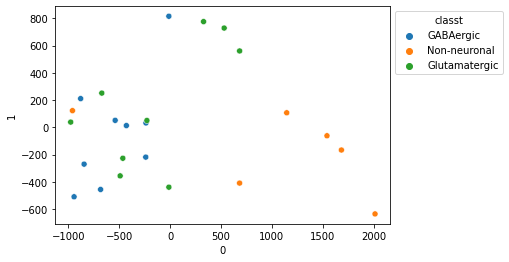

In [544]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
#proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

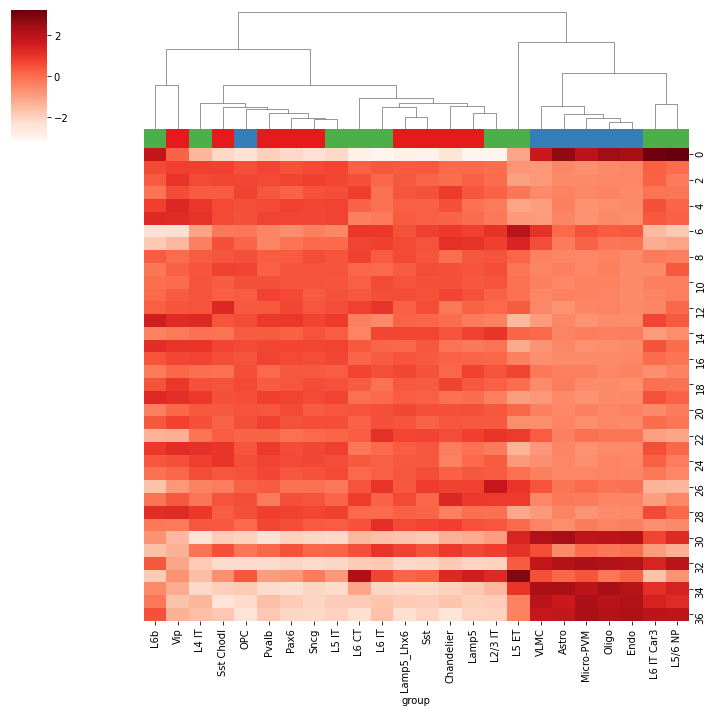

In [558]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []

for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    given_bins = list(set(given_bins).intersection(pure_bins))
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='Reds')


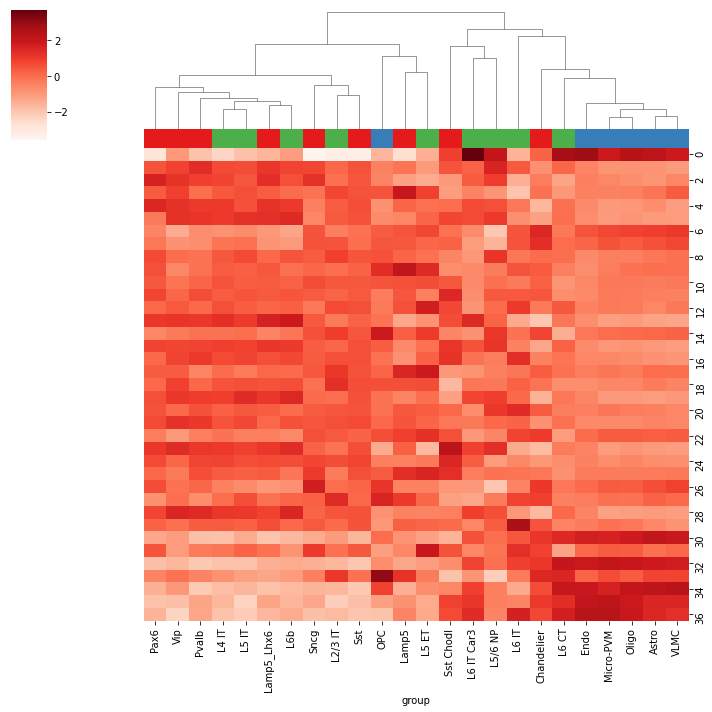

In [564]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []

for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    given_bins = list(set(given_bins).intersection(pure_bins))
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='Reds')


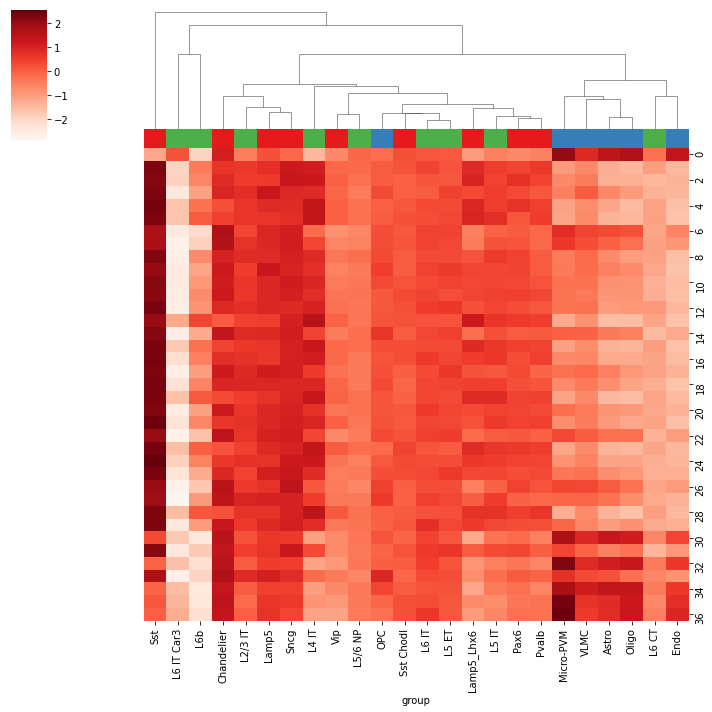

In [565]:
sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='Reds')


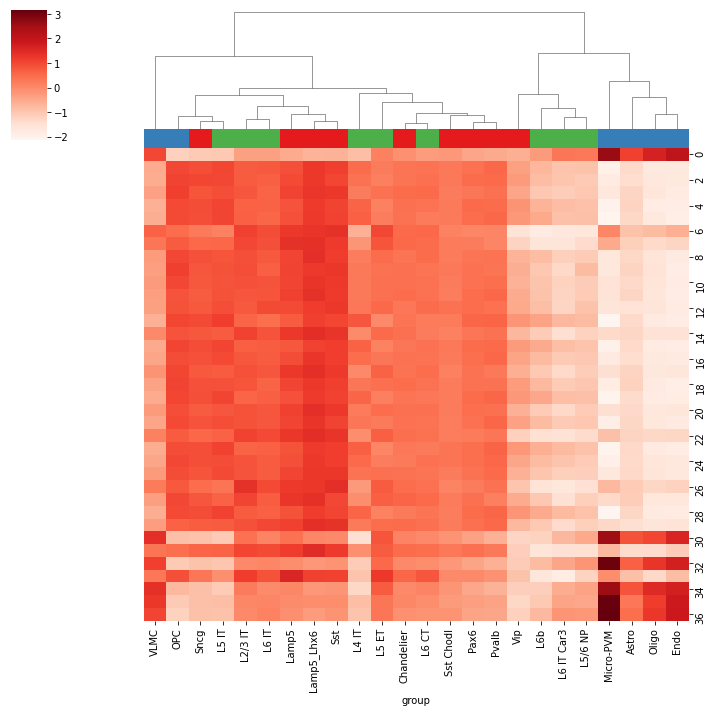

In [552]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='Reds')


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


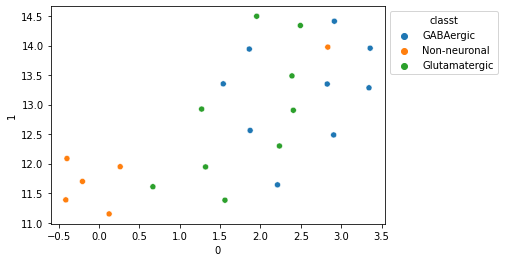

In [547]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
#proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


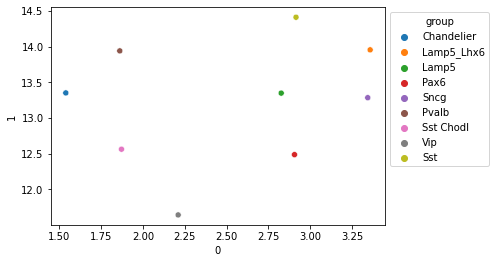

In [549]:
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'GABAergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


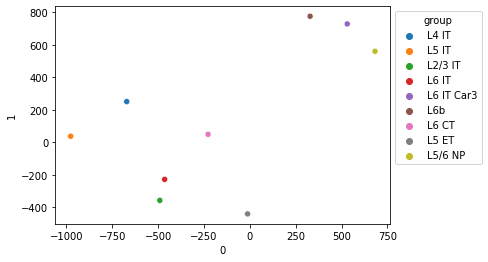

In [546]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

#umap_2d = UMAP(n_components=2, init='random', random_state=10)
#proj_2d = umap_2d.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-468-220d0de1bc45>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


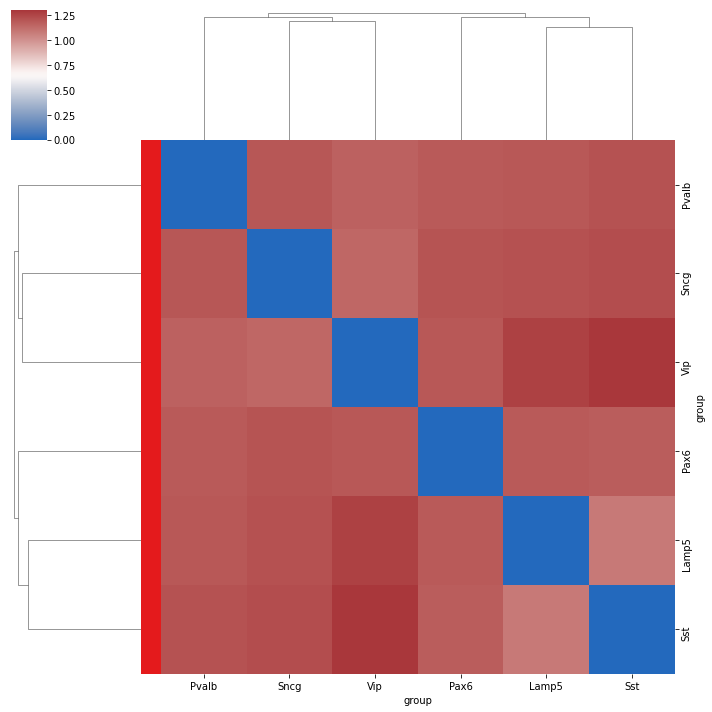

In [468]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dk = df_gene_tp_all_info_mean
dk = dk.reset_index()
dk = dk[dk['classt']!="Non-neuronal"]
dk = dk.groupby(['classt', 'group','boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-470-e9583f7fa19d>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


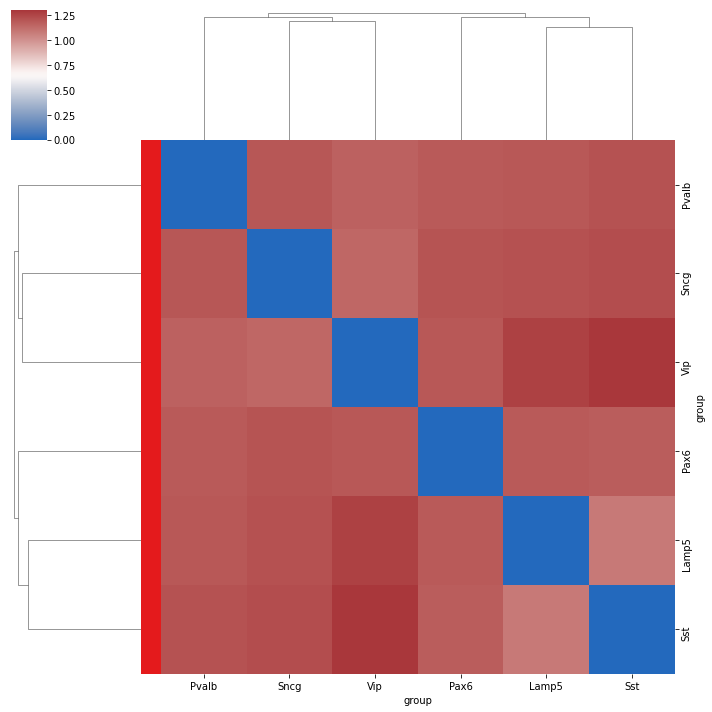

In [470]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dk = df_gene_tp_all_info_mean
dk = dk.reset_index()
#dk = dk[dk['classt']!="Non-neuronal"]
dk = dk.groupby(['classt', 'group','boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


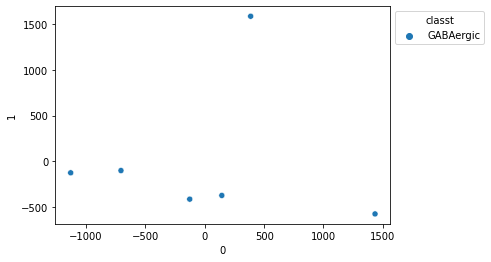

In [471]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Axes(0.125,0.125;0.775x0.755) has no legend attached.

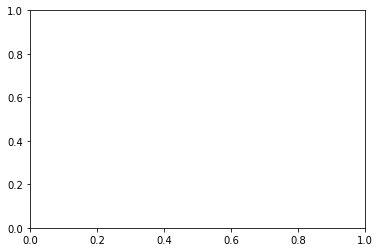

In [465]:

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

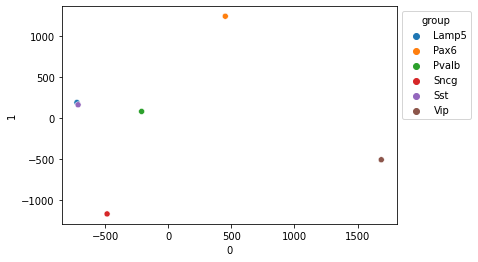

In [466]:

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'GABAergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [268]:
            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['group','Ensembl_gene_identifier'])
            

            marker_list = marker_list[marker_list['rank']<100]
            #marker_list = marker_list[marker_list['recurrence'] > 1]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [270]:
marker_list.groupby('gene')['rank'].count().max()

16

<Axes: xlabel='rank', ylabel='Count'>

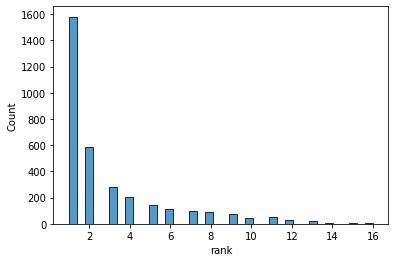

In [271]:
sns.histplot(marker_list.groupby('gene')['rank'].count())

In [190]:
            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['group','Ensembl_gene_identifier'])
            marker_list = marker_list[marker_list['recurrence']<100]
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'], keep=False)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<ipython-input-208-e8c96ac01997>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


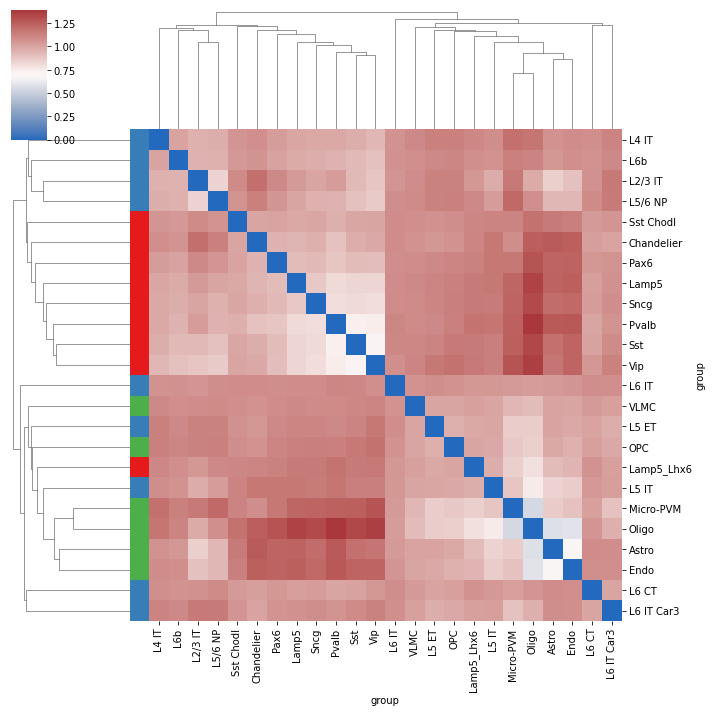

In [208]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-247-753ddd1bfdb0>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


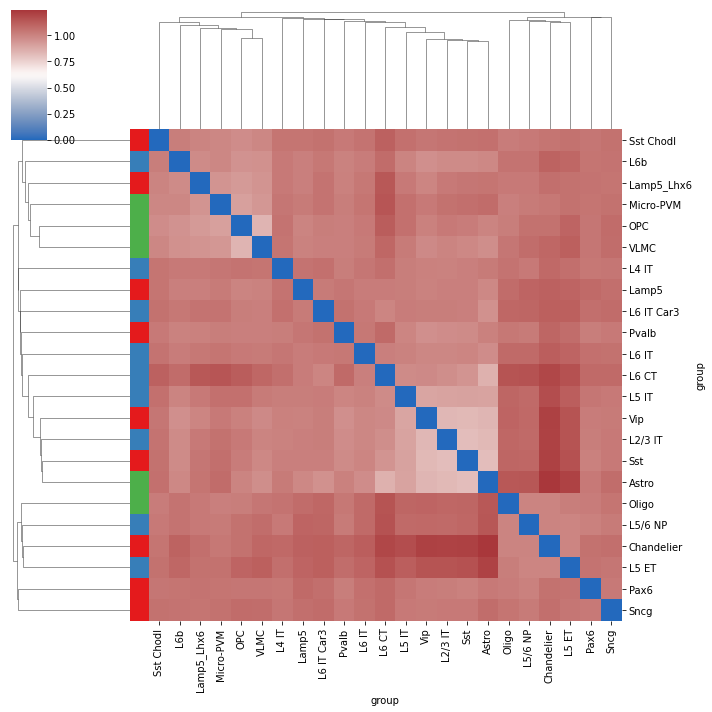

In [247]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0].groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-251-753ddd1bfdb0>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


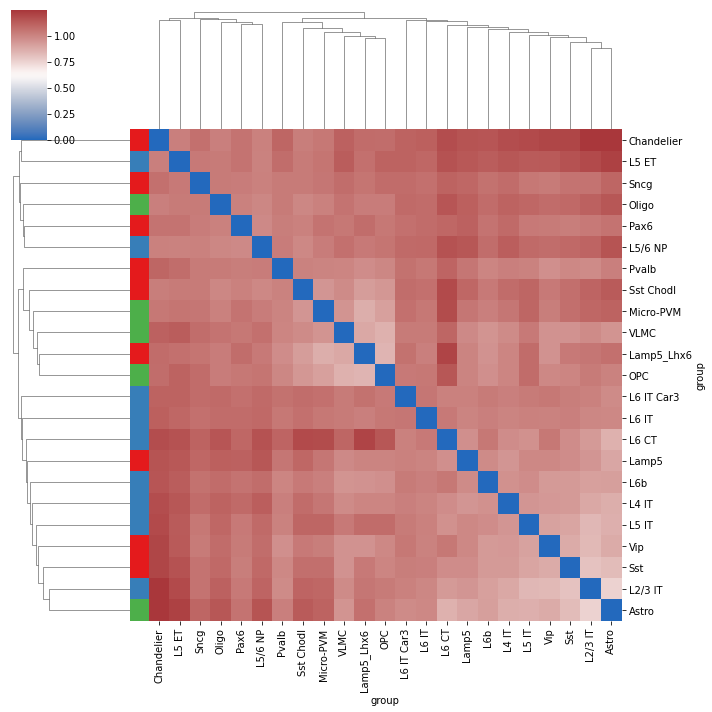

In [251]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0].groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-253-753ddd1bfdb0>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


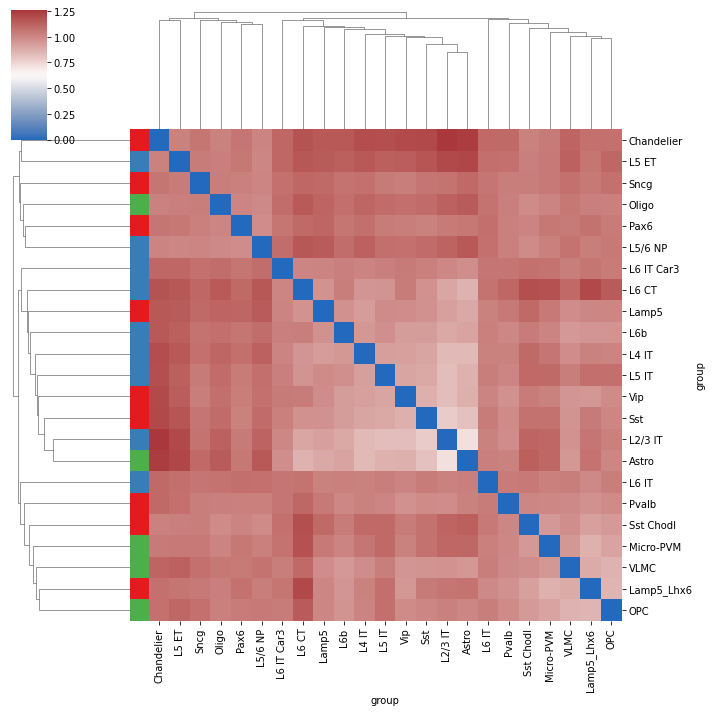

In [253]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0].groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-255-753ddd1bfdb0>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


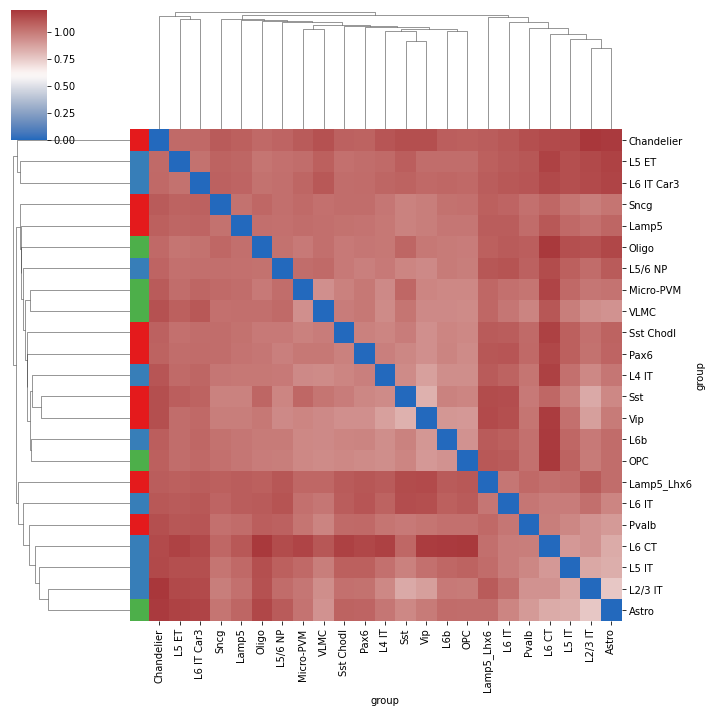

In [255]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0].groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-249-753ddd1bfdb0>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


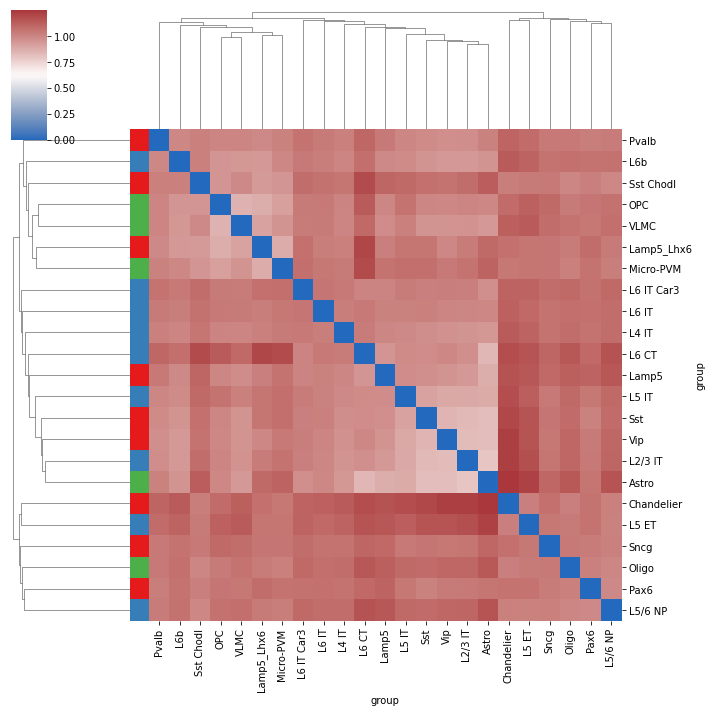

In [249]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0].groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-243-d1f4de1f0510>:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


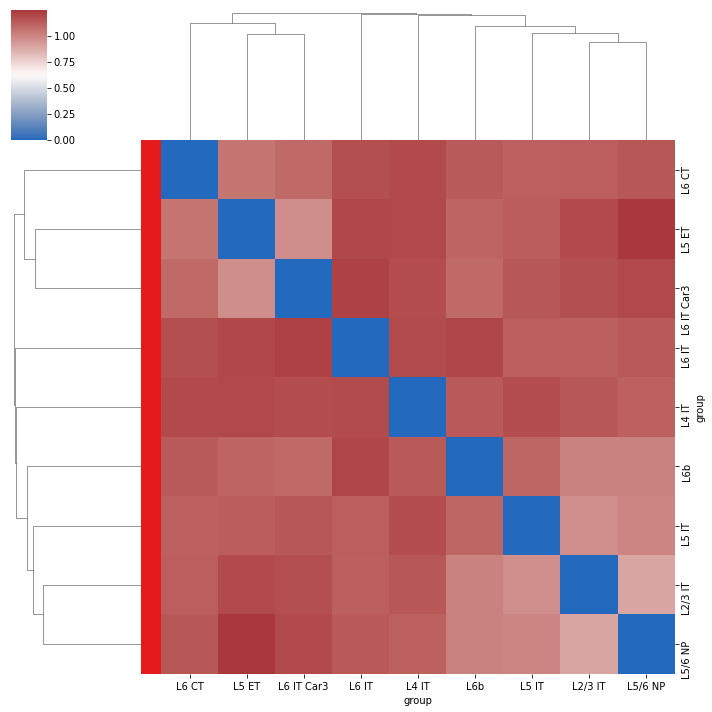

In [243]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0]
#dk = dk[dk['classt']=='Glutamatergic']
dk = dk.groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-235-fe25e6bbab3e>:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


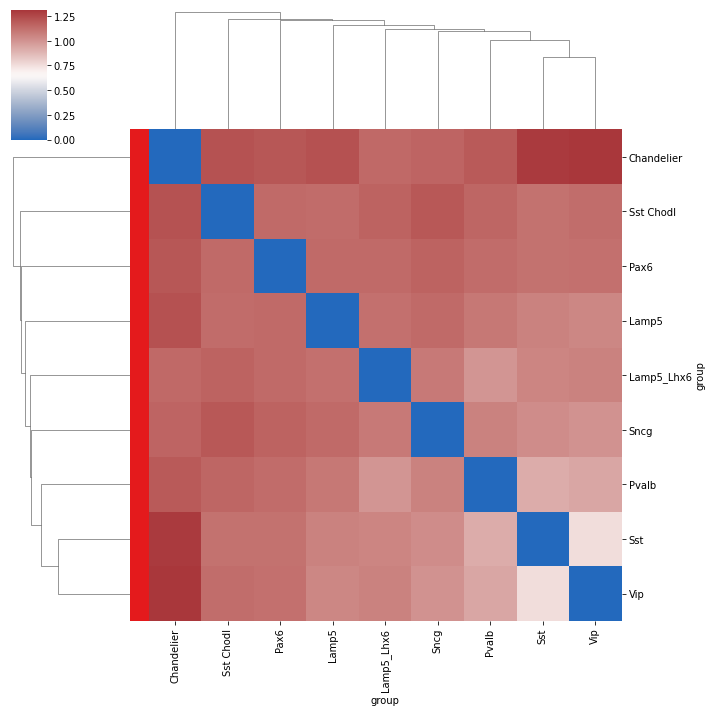

In [235]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#dk = pd.concat(df_list_brain_repeat)
#dk = df_gene_tp_all_info_mean
#dk = df_list_brain[0].groupby(['classt','group', 'boot_id']).mean()
dk = df_list_brain_repeat[0]
dk = dk[dk['classt']=='GABAergic']
dk = dk.groupby(['classt','group', 'boot_id']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [207]:
df_list_brain

[                        0         1         2         3         4         5  \
 key_0                                                                         
 ENSG00000118454       NaN       NaN       NaN       NaN       NaN       NaN   
 ENSG00000055955 -0.527954 -0.527954 -0.527954 -0.527954 -0.527954 -0.527954   
 ENSG00000141314 -0.911198 -0.911198 -0.911198 -0.911198 -0.911198 -0.911198   
 ENSG00000168264       NaN       NaN       NaN       NaN       NaN       NaN   
 ENSG00000082397 -1.315521 -1.315521 -1.315521 -1.315521 -1.315521 -1.315521   
 ...                   ...       ...       ...       ...       ...       ...   
 ENSG00000196562 -1.085509 -1.085509 -1.085509 -1.085509 -1.085509 -1.085509   
 ENSG00000154553 -0.672428 -0.672428 -0.672428 -0.672428 -0.672428 -0.672428   
 ENSG00000204634 -1.206385 -1.206385 -1.206385 -1.206385 -1.206385 -1.206385   
 ENSG00000067182 -0.512956 -0.512956 -0.512956 -0.512956 -0.512956 -0.512956   
 ENSG00000179796 -0.878960 -0.878960 -0.

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


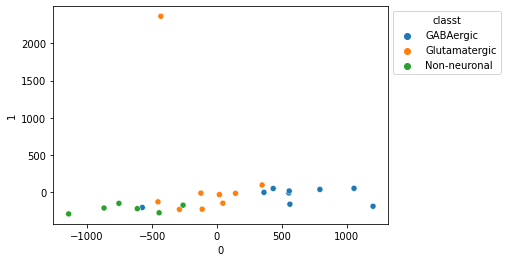

In [209]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


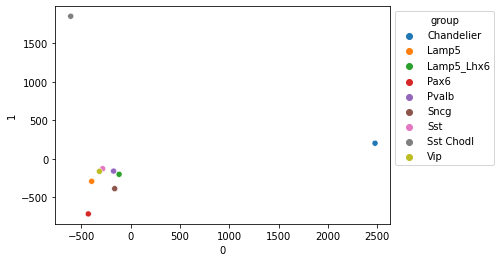

In [238]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-500.0, 500.0)

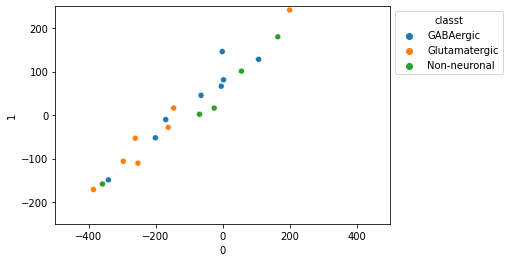

In [202]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim([-250,250])
ax.set_xlim([-500,500])

In [291]:
df_list_heart_200  = []
for number_of_times in range(25):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list.sort_values(by=['rank',  'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 200]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart_200.append(df_gene_tp_all_info_mean)

            


<ipython-input-291-6e629a0a6b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-291-6e629a0a6b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-291-6e629a0a6b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<ipython-input-291-6e629a0a6b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-291-6e629a0a6b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-291-6e629a0a6b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [292]:
df_list_heart_400  = []
for number_of_times in range(25):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list.sort_values(by=['rank',  'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 400]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart_400.append(df_gene_tp_all_info_mean)

            


<ipython-input-292-fc1b474834cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-292-fc1b474834cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-292-fc1b474834cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<ipython-input-292-fc1b474834cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-292-fc1b474834cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-292-fc1b474834cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [97]:
df_list_heart  = []
for number_of_times in range(25):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list.sort_values(by=['rank',  'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 500]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart.append(df_gene_tp_all_info_mean)

            


<ipython-input-97-629dc31f4ec5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-97-629dc31f4ec5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-97-629dc31f4ec5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

<ipython-input-97-629dc31f4ec5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-97-629dc31f4ec5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-97-629dc31f4ec5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [111]:
for number_of_times in range(25, 50):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list.sort_values(by=['rank',  'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 500]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart.append(df_gene_tp_all_info_mean)

            


<ipython-input-111-bfcd7690fcad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-111-bfcd7690fcad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-111-bfcd7690fcad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

<ipython-input-111-bfcd7690fcad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-111-bfcd7690fcad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
<ipython-input-111-bfcd7690fcad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [113]:
gc.collect()


47

In [112]:
df_list_brain  = []
for number_of_times in range(50):
    
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [1000]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:


            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 200]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                #df2_list.append(bootstrap_sample)
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'type':

        marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


        marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])
    
    df_gene_tp_all_info['boot_id'] = number_of_times

    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'boot_id']).mean()
    
    #df_list.append(df_gene_tp_all_info_mean)
    
    df_list_brain.append(df_gene_tp_all_info)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeW

MemoryError: Unable to allocate 70.6 GiB for an array with shape (2875012, 3296) and data type float64

In [116]:
len(df_list_brain)

22

In [15]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')
    

In [16]:
pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/hg38-blacklist.v2.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/hg38-blacklist.v2.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/all_bin_blacklist_10kb.bed")
          
    

0

In [17]:
blacklist_bins = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/all_bin_blacklist_1kb.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])


In [20]:
pure_bins = list(set(dk.columns.tolist()) - set(blacklist_bins['bin_id'].tolist()))


In [65]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



In [151]:
dj = pd.concat(df_list_heart)
dj[[0, 'group']].groupby(['group', 'boot_id']).count()


KeyError: 'group'

In [159]:
dj[[0, 'cell_type']].groupby(['cell_type']).count()


0
cell_type                    
Adipocytes                168
Cardiomyocytes             97
Endocardial                72
Endothelial_Arterial       67
Endothelial_Capillaries    78
Endothelial_Other          54
Endothelial_Venous         59
Epicardium_FB-like         72
Epicardium_Meso            95
Epicardium_Proliferating   47
Fibroblasts               109
Immature_Cardiomyocytes    97
Immature_other            111
Lymphoid_Immune_Cells     128
Myeloid_Immune_Cells      128
Neuronal_Cells            144
Pericytes                  86
Pericytes_Stromal          74
Smooth_Muscle_Cells        79

<ipython-input-125-cd290e9ca24e>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


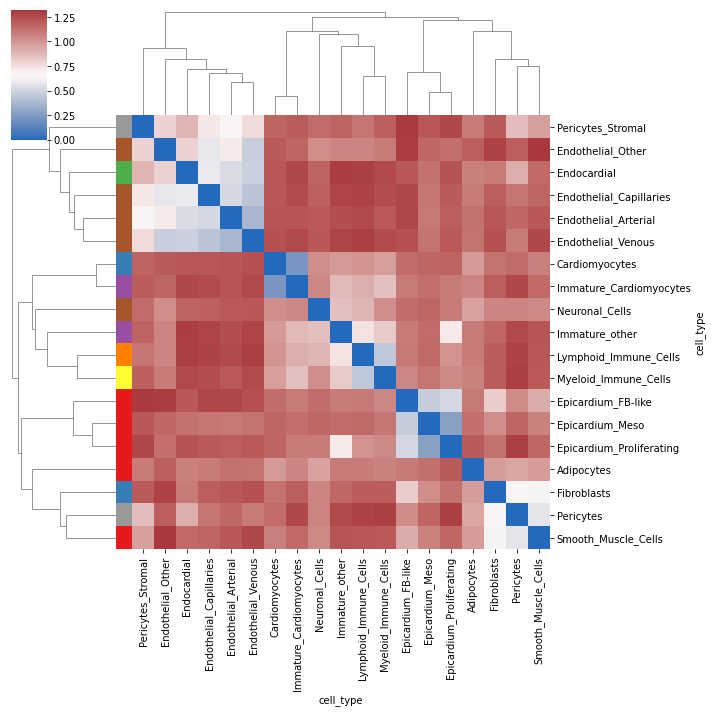

In [125]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_repeat)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-99-8a1f6095f7b4>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


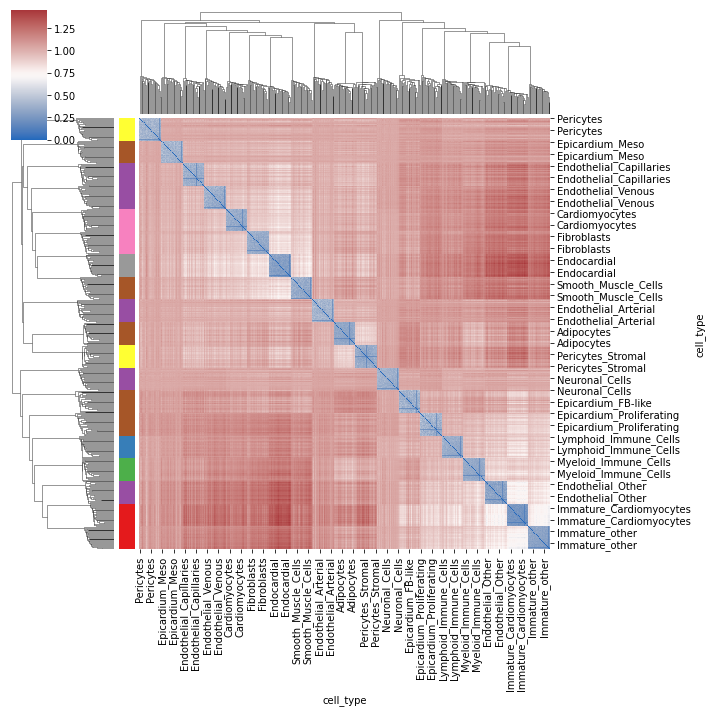

In [99]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-304-dced37542f85>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


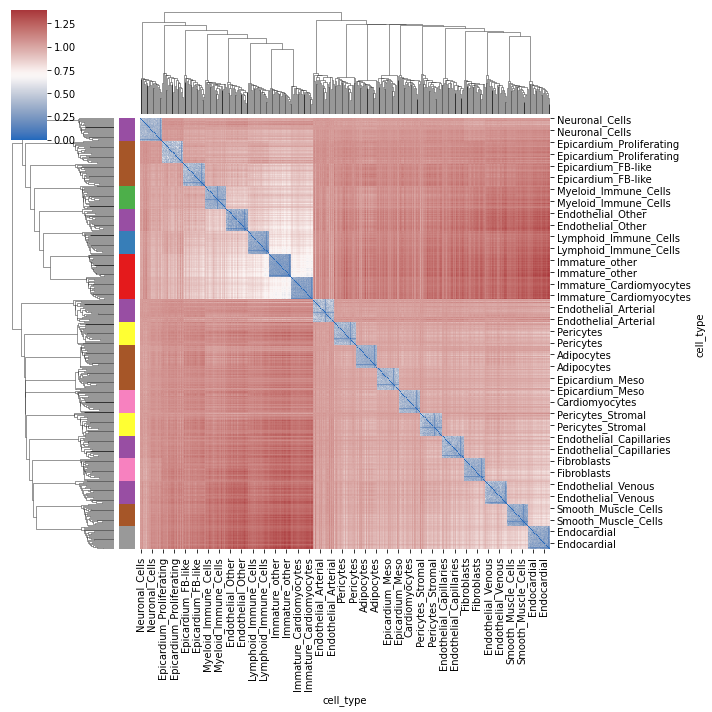

In [304]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_200)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-310-13417746e903>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


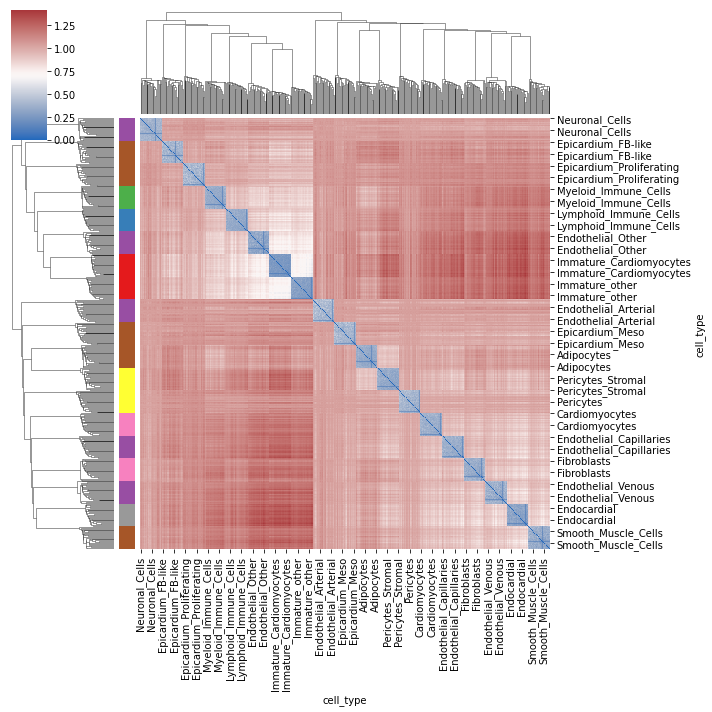

In [310]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_400)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-117-8a1f6095f7b4>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


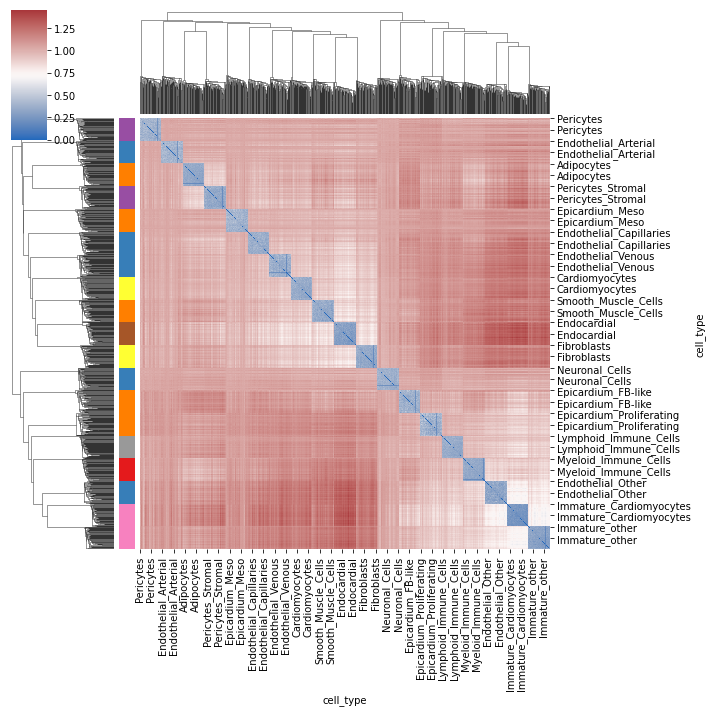

In [117]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-122-06a7060977d1>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


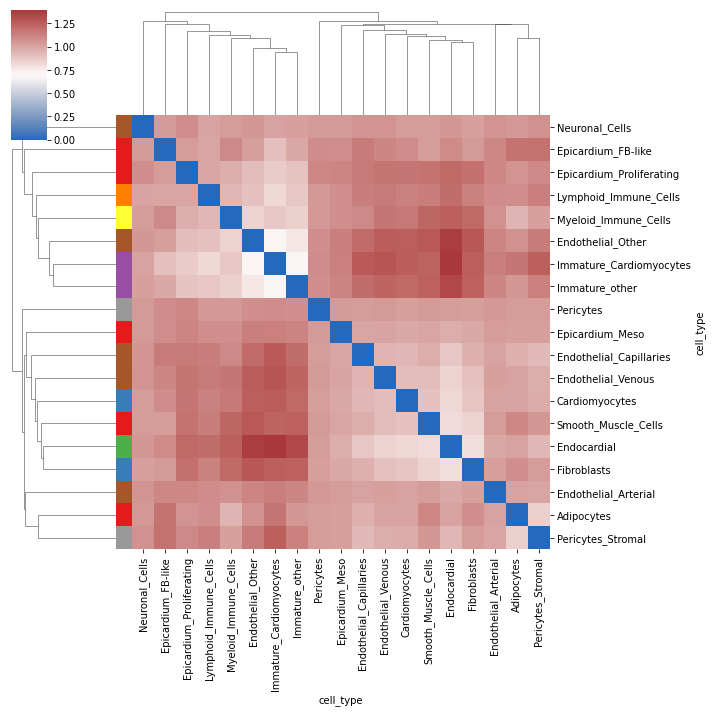

In [122]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart)
#dk = df_list_heart[0]
dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [525]:
len(df_list_heart_500)

5

<ipython-input-60-7ae4cfee1d97>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


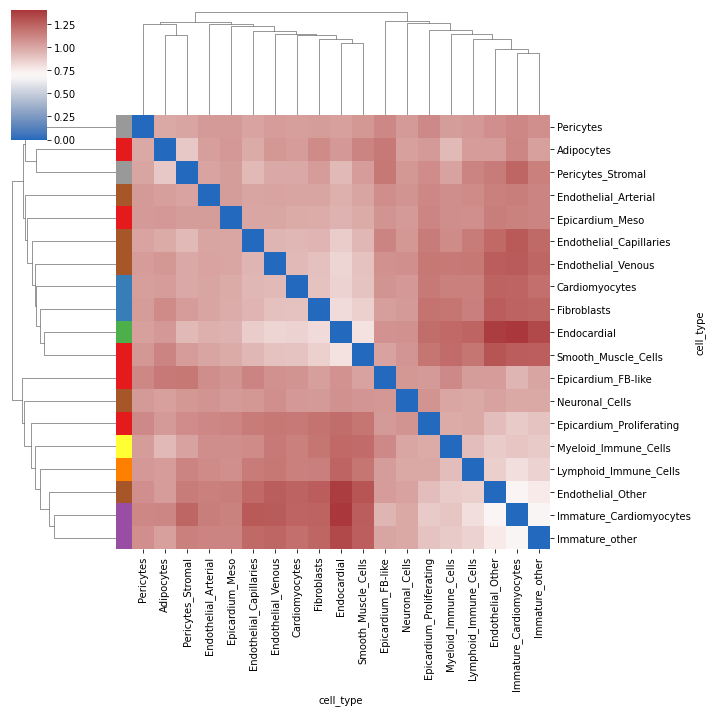

In [60]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_500)
#dk = df_list_heart[0]
dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-64-f818f90a77e9>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


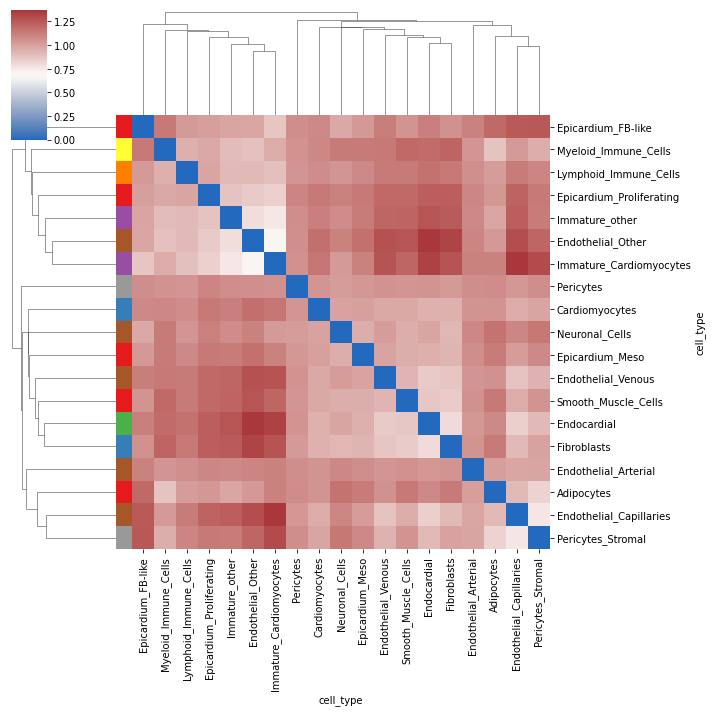

In [64]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_1000)
#dk = df_list_heart[0]
dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [303]:
len(df_list_heart_200)

25

<ipython-input-48-dced37542f85>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


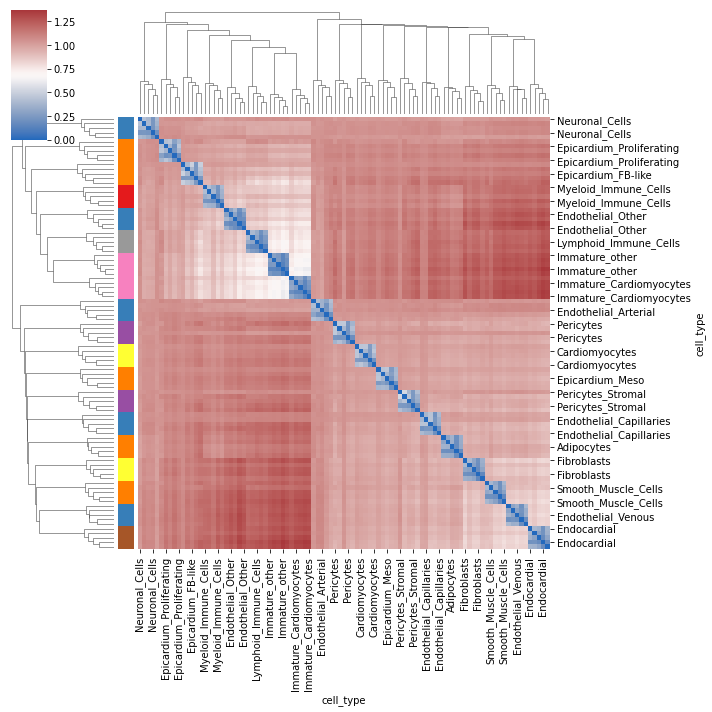

In [48]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_200)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-43-47474aff85fb>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


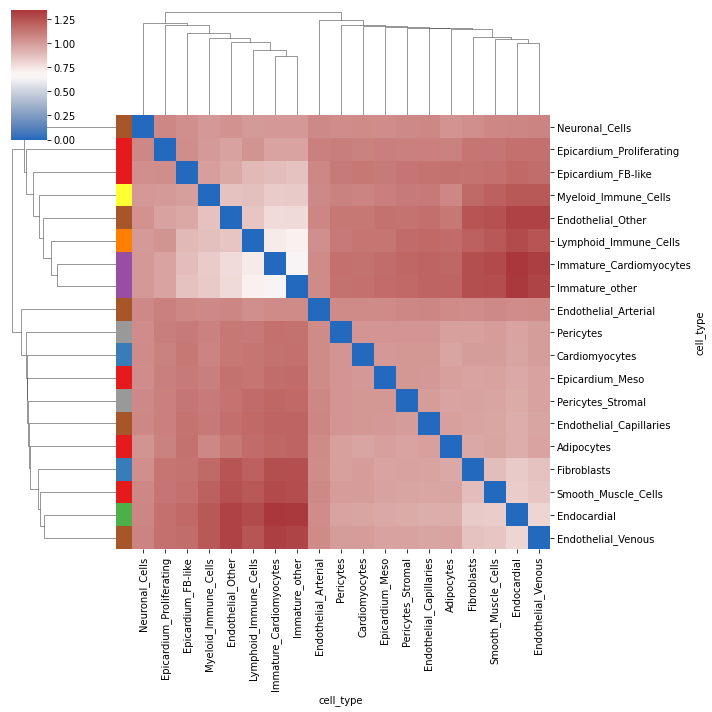

In [43]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_200)
#dk = df_list_heart[0]
dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-22-2e45afd18080>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


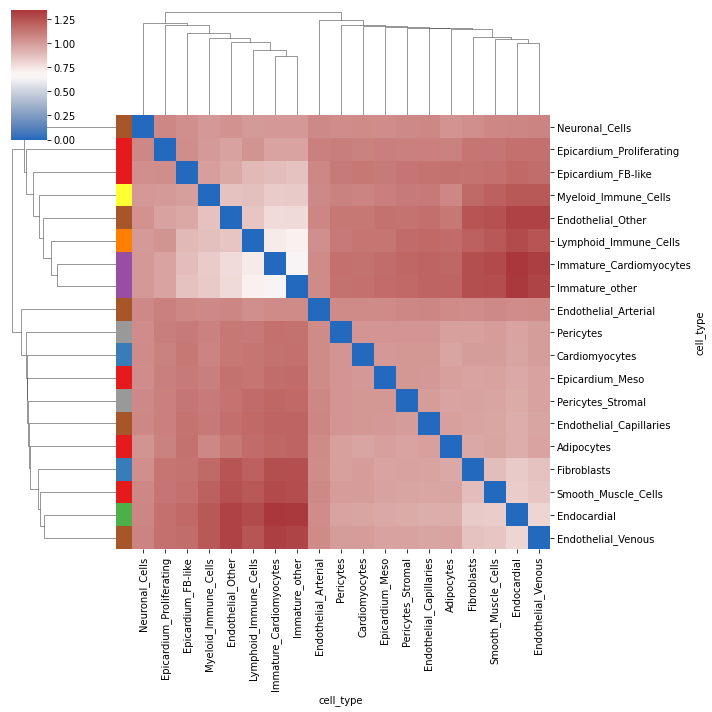

In [22]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler


features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-222-57bd0e84eee4>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


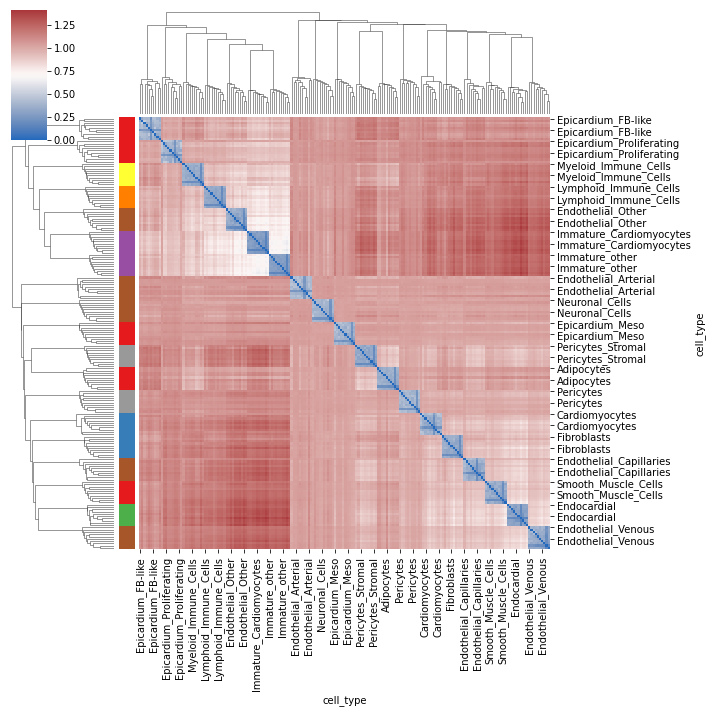

In [222]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart)
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group', 'boot_id']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [197]:
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))


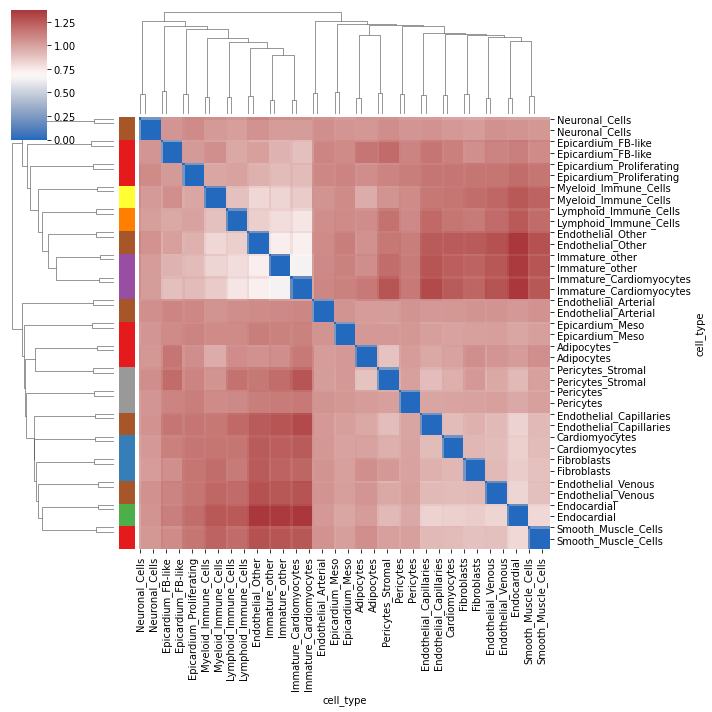

In [198]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [196]:
dk.index.get_level_values('cell_type').tolist()

['Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Adipocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Cardiomyocytes',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endocardial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Arterial',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries',
 'Endothelial_Capillaries'

In [195]:
row_colors

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.

<ipython-input-187-1542676ca8ca>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


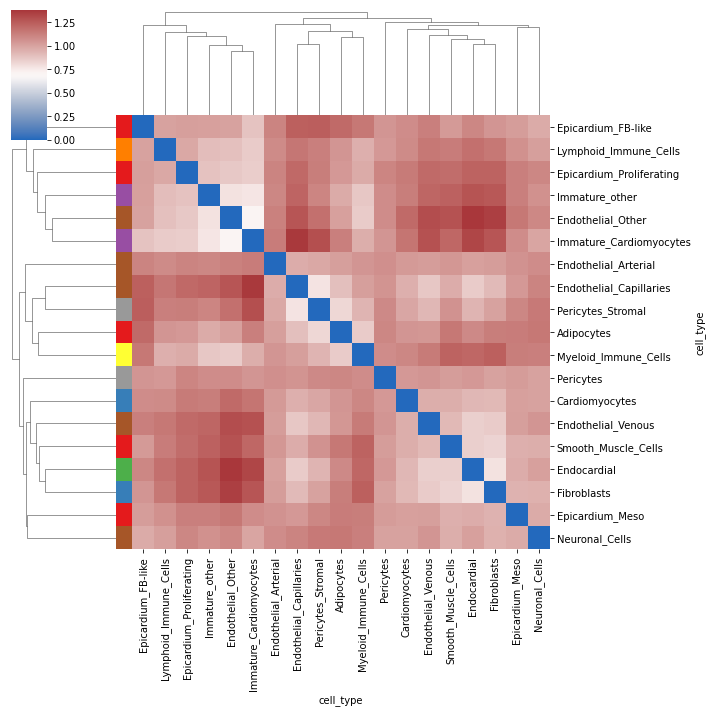

In [187]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart)
dk = dk.groupby(['cell_type', 'group', 'boot_id']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

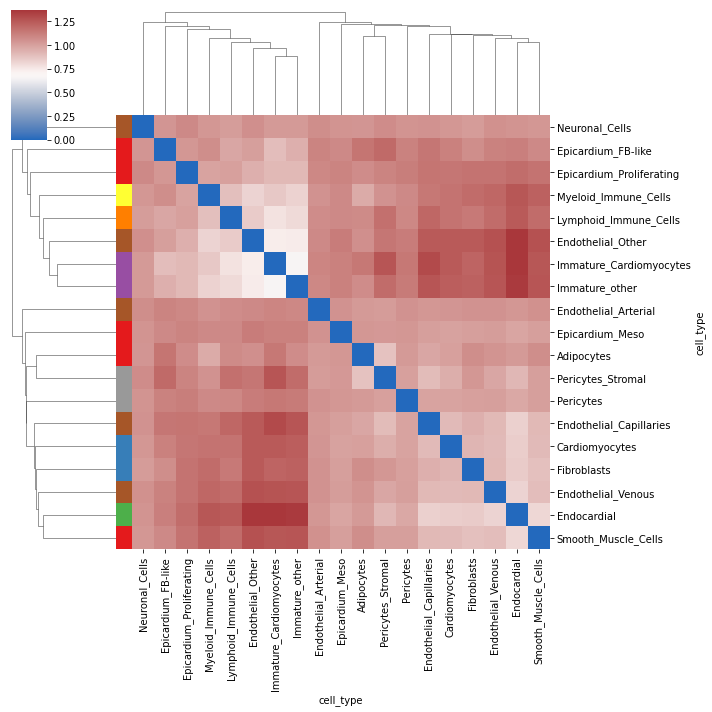

In [167]:
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

<ipython-input-83-23f4d3172212>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


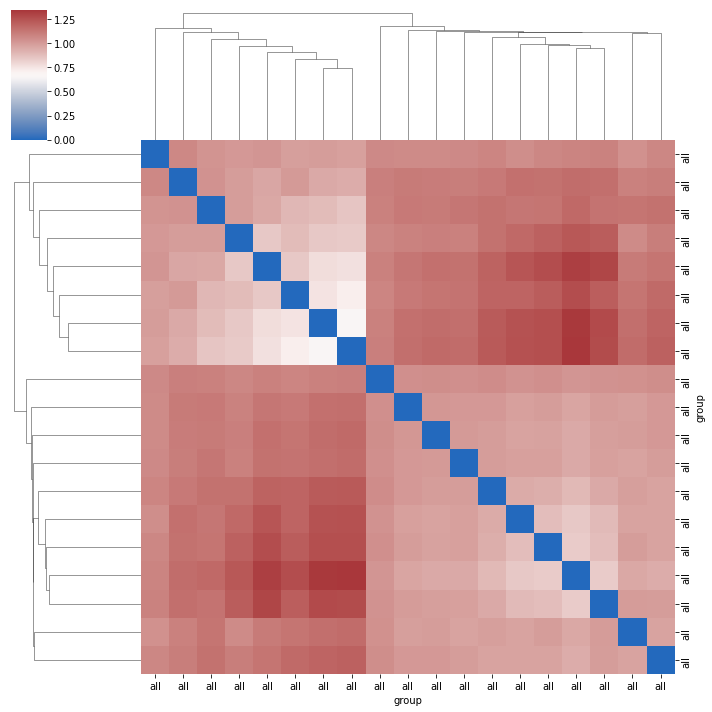

In [83]:
features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag")


In [104]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(1-R1)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


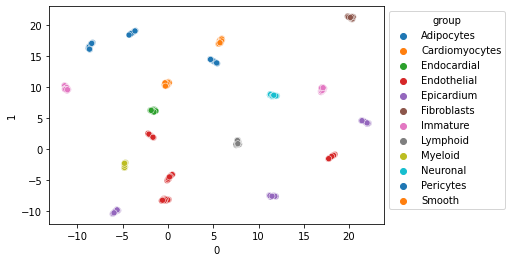

In [105]:
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


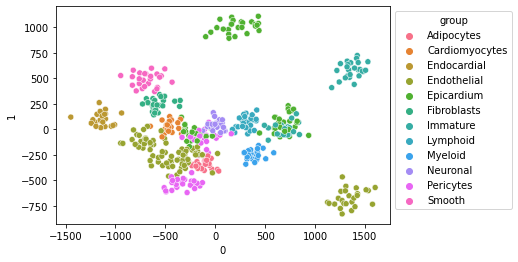

In [102]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


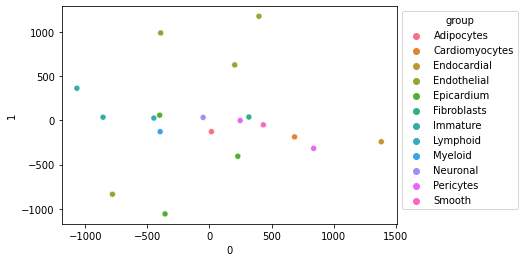

In [345]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


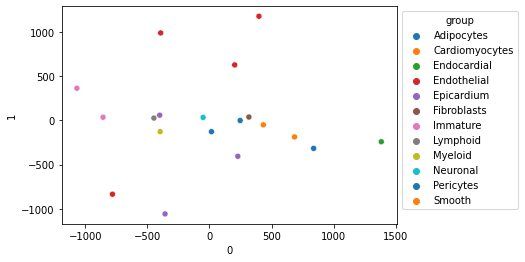

In [346]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_ylim([-300,300])

In [308]:
df_proj_2d

0           1           2           group
0    -201.097366    5.124576 -139.625504      Adipocytes
1    -284.136200   -7.279207 -145.925278  Cardiomyocytes
2    -986.445801   39.575298 -124.641068     Endocardial
3    -129.188202 -158.177704  -77.476936     Endothelial
4    -506.302795   47.376450 -280.399017     Endothelial
..           ...         ...         ...             ...
470   373.350739  -30.545464 -179.037018         Myeloid
471   202.830505  -99.844673   77.890587        Neuronal
472  -363.600525  -36.179085 -191.987991       Pericytes
473  -436.534973   66.443985 -452.825806       Pericytes
474 -1014.563416   33.588711  -95.349503          Smooth

[475 rows x 4 columns]

<ipython-input-347-956c73ae35e9>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


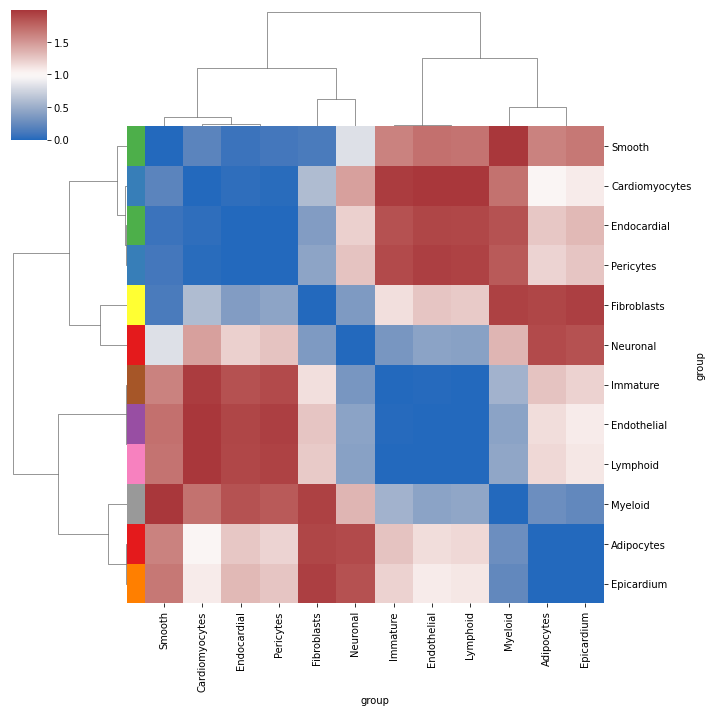

In [347]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = df_proj_2d
dk = dk.groupby(['group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
#features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-326-956c73ae35e9>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


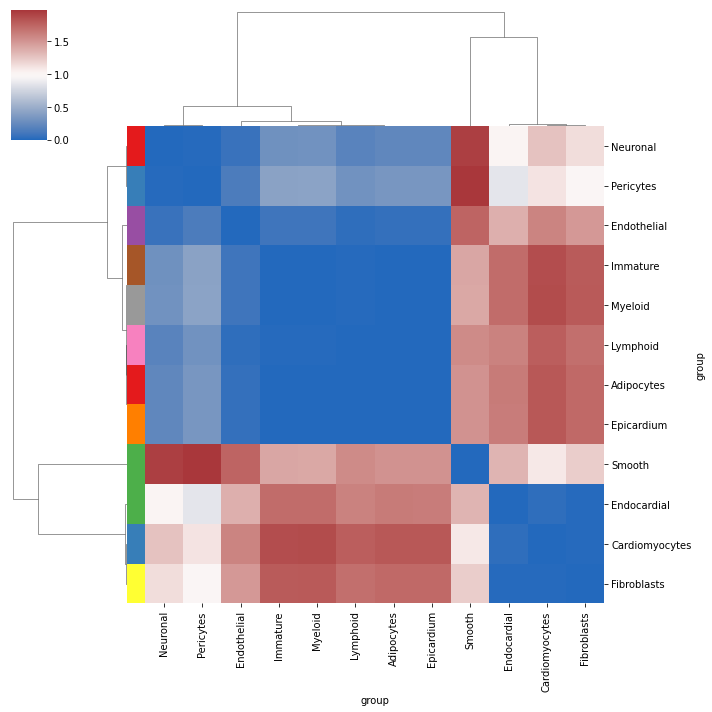

In [326]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = df_proj_2d
dk = dk.groupby(['group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
#features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [316]:
df_list_heart_200[0]

0         1         2        \
cell_type                group boot_id                                 
Adipocytes               all   0       -0.693342 -0.693342 -0.693342   
Cardiomyocytes           all   0       -0.705068 -0.705068 -0.705068   
Endocardial              all   0       -0.824914 -0.824914 -0.824914   
Endothelial_Arterial     all   0       -0.674840 -0.674840 -0.674840   
Endothelial_Capillaries  all   0       -0.724495 -0.724495 -0.724495   
Endothelial_Other        all   0       -0.475834 -0.475834 -0.475834   
Endothelial_Venous       all   0       -0.784552 -0.784552 -0.784552   
Epicardium_FB-like       all   0       -0.545852 -0.545852 -0.545852   
Epicardium_Meso          all   0       -0.679321 -0.679321 -0.679321   
Epicardium_Proliferating all   0       -0.523180 -0.523180 -0.523180   
Fibroblasts              all   0       -0.732723 -0.732723 -0.732723   
Immature_Cardiomyocytes  all   0       -0.427432 -0.427432 -0.427432   
Immature_other           all   0       -0.417695 -0.417695 -0.417695   
Lymphoid_Immune_Cells    all   0       -0.506623 -0.506623 -0.506623   
Myeloid_Immune_Cells     all   0       -0.556053 -0.556053 -0.556053   
Neuronal_Cells           all   0       -0.620932 -0.620932 -0.620932   
Pericytes                all   0       -0.705537 -0.705537 -0.705537   
Pericytes_Stromal        all   0       -0.757358 -0.757358 -0.757358   
Smooth_Muscle_Cells      all   0       -0.771808 -0.771808 -0.771808   

                                         3         4         5        \
cell_type                group boot_id                                 
Adipocytes               all   0       -0.693342 -0.693342 -0.693342   
Cardiomyocytes           all   0       -0.705068 -0.705068 -0.705068   
Endocardial              all   0       -0.824914 -0.824914 -0.824914   
Endothelial_Arterial     all   0       -0.674840 -0.674840 -0.674840   
Endothelial_Capillaries  all   0       -0.724495 -0.724495 -0.724495   
Endothelial_Other        all   0       -0.475834 -0.475834 -0.475834   
Endothelial_Venous       all   0       -0.784552 -0.784552 -0.784552   
Epicardium_FB-like       all   0       -0.545852 -0.545852 -0.545852   
Epicardium_Meso          all   0       -0.679321 -0.679321 -0.679321   
Epicardium_Proliferating all   0       -0.523180 -0.523180 -0.523180   
Fibroblasts              all   0       -0.732723 -0.732723 -0.732723   
Immature_Cardiomyocytes  all   0       -0.427432 -0.427432 -0.427432   
Immature_other           all   0       -0.417695 -0.417695 -0.417695   
Lymphoid_Immune_Cells    all   0       -0.506623 -0.506623 -0.506623   
Myeloid_Immune_Cells     all   0       -0.556053 -0.556053 -0.556053   
Neuronal_Cells           all   0       -0.620932 -0.620932 -0.620932   
Pericytes                all   0       -0.705537 -0.705537 -0.705537   
Pericytes_Stromal        all   0       -0.757358 -0.757358 -0.757358   
Smooth_Muscle_Cells      all   0       -0.771808 -0.771808 -0.771808   

                                         6         7         8        \
cell_type                group boot_id                                 
Adipocytes               all   0       -0.693342 -0.693342 -0.693342   
Cardiomyocytes           all   0       -0.705068 -0.705068 -0.705068   
Endocardial              all   0       -0.824914 -0.824914 -0.824914   
Endothelial_Arterial     all   0       -0.674840 -0.674840 -0.674840   
Endothelial_Capillaries  all   0       -0.724495 -0.724495 -0.724495   
Endothelial_Other        all   0       -0.475834 -0.475834 -0.475834   
Endothelial_Venous       all   0       -0.784552 -0.784552 -0.784552   
Epicardium_FB-like       all   0       -0.545852 -0.545852 -0.545852   
Epicardium_Meso          all   0       -0.679321 -0.679321 -0.679321   
Epicardium_Proliferating all   0       -0.523180 -0.523180 -0.523180   
Fibroblasts              all   0       -0.732723 -0.732723 -0.732723   
Immature_Cardiomyocytes  all   0       -0.427432 -0.427432 -0.427432   
Immatur

<ipython-input-399-d4015f5ccbe9>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


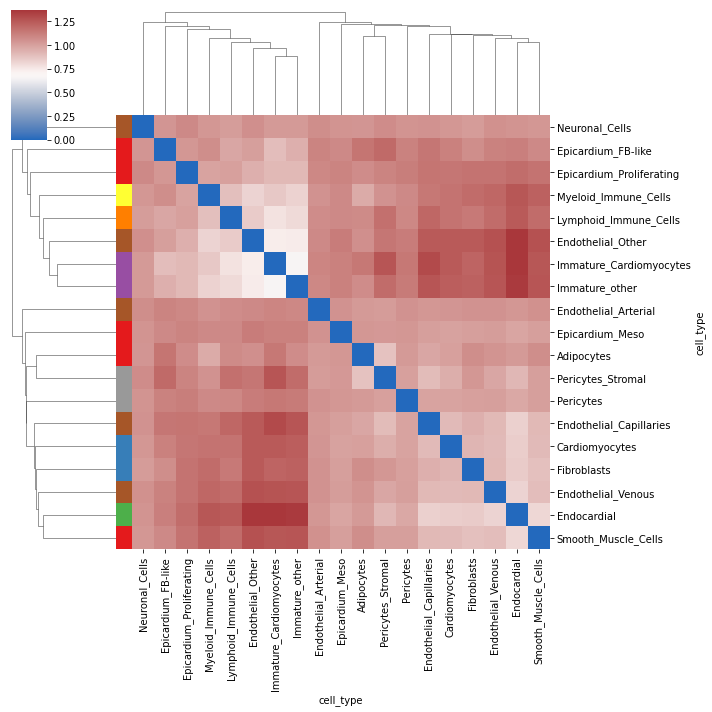

In [399]:
#dj = pd.concat(df_list)
dk = df_list_heart_400[0]
#dk = df_gene_tp_all_info_mean
#dk = pd.concat(df_list_heart_400[0])
#dk = dk.reset_index()
#dk['cell_type'] = [x.split('_')[0] for x in dk['cell_type']]
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'boot_id']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

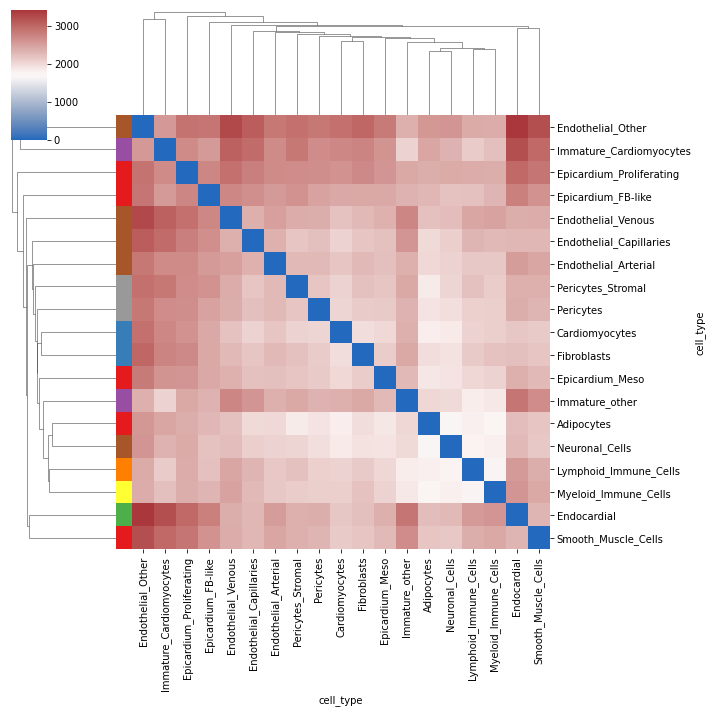

In [403]:
df_dist = sp.distance.squareform(pdist(features_sc))
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [ ]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = pd.concat(df_list_heart_400)
dk = dk.reset_index()
#dk['cell_type'] = [x.split('_')[0] for x in dk['cell_type']]
#dk = df_list_heart[0]
dk = dk.groupby(['cell_type']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
#df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [402]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix_atac = pd.DataFrame(loadings, index=features.columns.tolist())

804       806       813       814      \
cell_type               group boot_id                                           
Adipocytes              all   0       -0.493763 -0.356456 -0.645102 -0.569570   
Cardiomyocytes          all   0       -0.589901 -0.423153 -0.649007 -0.648653   
Endocardial             all   0       -0.617161 -0.415900 -0.734525 -0.751410   
Endothelial_Arterial    all   0       -0.552475 -0.388184 -0.638042 -0.570745   
Endothelial_Capillaries all   0       -0.599940 -0.312837 -0.722594 -0.650124   
...                                         ...       ...       ...       ...   
Myeloid_Immune_Cells    all   24      -0.390109 -0.256541 -0.550157 -0.545417   
Neuronal_Cells          all   24      -0.547867 -0.274344 -0.599957 -0.541732   
Pericytes               all   24      -0.525853 -0.423307 -0.701988 -0.638542   
Pericytes_Stromal       all   24      -0.557311 -0.271380 -0.693797 -0.708706   
Smooth_Muscle_Cells     all   24      -0.520499 -0.387347 -0.681250 -0.728010   

                                        815       840       866       869      \
cell_type               group boot_id                                           
Adipocytes              all   0       -0.603226 -0.422914 -0.291521 -0.600762   
Cardiomyocytes          all   0       -0.699291 -0.523838 -0.384742 -0.617516   
Endocardial             all   0       -0.785476 -0.490279 -0.462274 -0.693447   
Endothelial_Arterial    all   0       -0.613033 -0.363446 -0.339681 -0.608066   
Endothelial_Capillaries all   0       -0.680759 -0.465107 -0.361485 -0.653443   
...                                         ...       ...       ...       ...   
Myeloid_Immune_Cells    all   24      -0.531758 -0.390432 -0.262568 -0.551987   
Neuronal_Cells          all   24      -0.561038 -0.381512 -0.300457 -0.541488   
Pericytes               all   24      -0.555923 -0.372311 -0.322760 -0.639185   
Pericytes_Stromal       all   24      -0.596548 -0.377335 -0.304073 -0.620330   
Smooth_Muscle_Cells     all   24      -0.688623 -0.495521 -0.399579 -0.702754   

                                        870       872      ...   2874948  \
cell_type               group boot_id                      ...             
Adipocytes              all   0       -0.517406 -0.530510  ... -0.680238   
Cardiomyocytes          all   0       -0.649833 -0.635337  ... -0.747486   
Endocardial             all   0       -0.679190 -0.665514  ... -0.813956   
Endothelial_Arterial    all   0       -0.581928 -0.508290  ... -0.678763   
Endothelial_Capillaries all   0       -0.640519 -0.681672  ... -0.783238   
...                                         ...       ...  ...       ...   
Myeloid_Immune_Cells    all   24      -0.457347 -0.477102  ... -0.574910   
Neuronal_Cells          all   24      -0.494910 -0.483659  ... -0.639923   
Pericytes               all   24      -0.548642 -0.672279  ... -0.751811   
Pericytes_Stromal       all   24      -0.576739 -0.582670  ... -0.717768   
Smooth_Muscle_Cells     all   24      -0.670589 -0.611604  ... -0.808665   

                                        2874949   2874950   2874951   2874952  \
cell_type               group boot_id                                           
Adipocytes              all   0       -0.678070 -0.692184 -0.692184 -0.692184   
Cardiomyocytes          all   0       -0.731227 -0.747486 -0.742812 -0.747486   
Endocardial             all   0       -0.815034 -0.824164 -0.805177 -0.824164   
Endothelial_Arterial    all   0       -0.672005 -0.678763 -0.678763 -0.678763   
Endothelial_Capillaries all   0       -0.774559 -0.783238 -0.777616 -0.783238   
...                                         ...       ...       ...       ...   
Myeloid_Immune_Cells    all   24      -0.581778 -0.581778 -0.573256 -0.581778   
Neuronal_Cells          all   24      -0.639923 -0.639923 -0.639923 -0.639923   
Pericytes               all   24      -0.751811 -0.751811 -0.710790 -0.751811   
Pericytes_Stromal       all   24      -0.717768 -0.7

<ipython-input-393-1787246eaaeb>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


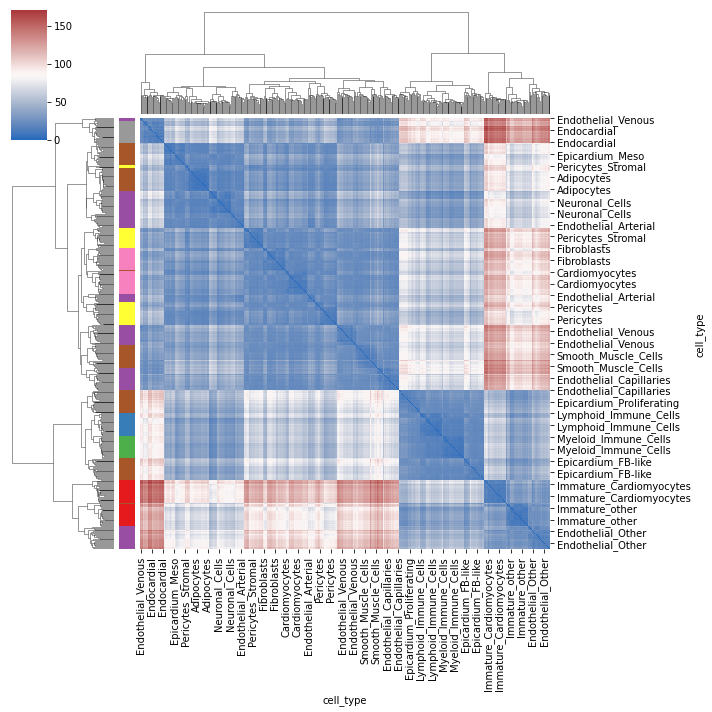

In [393]:
features_2 = features.loc[:, loading_matrix_atac[loading_matrix_atac[0] > 0.7].index.tolist()]
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features_2)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
df_dist = sp.distance.squareform(pdist(features_2))
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


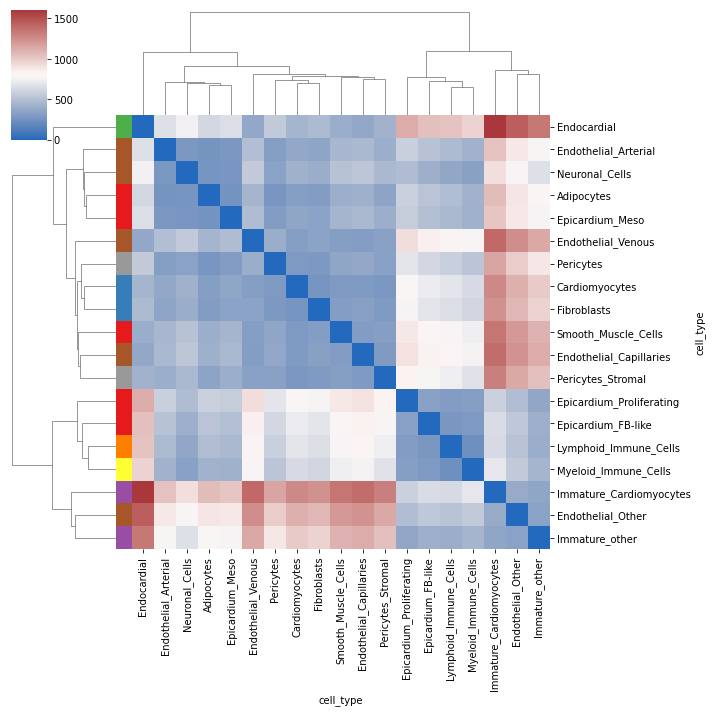

In [404]:
features_2 = features.loc[:, loading_matrix_atac[loading_matrix_atac[0] > 0.7].index.tolist()]
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features_2)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = sp.distance.squareform(pdist(features_sc))
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-405-1787246eaaeb>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


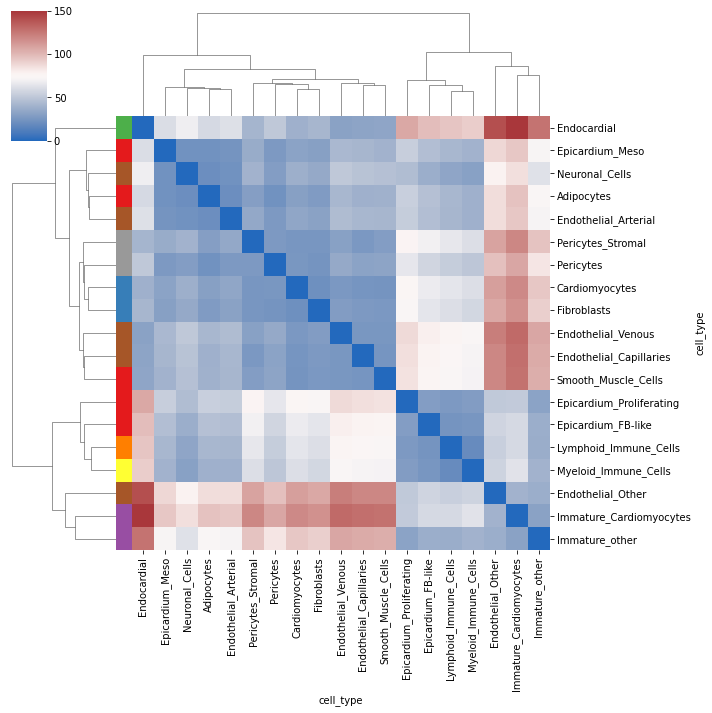

In [405]:
features_2 = features.loc[:, loading_matrix_atac[loading_matrix_atac[0] > 0.7].index.tolist()]
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features_2)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
df_dist = sp.distance.squareform(pdist(features_2))
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


0         1         2        \
cell_type                group boot_id                                 
Adipocytes               all   0       -0.689060 -0.689060 -0.689060   
Cardiomyocytes           all   0       -0.745593 -0.745593 -0.745593   
Endocardial              all   0       -0.840942 -0.840942 -0.840942   
Endothelial_Arterial     all   0       -0.679688 -0.679688 -0.679688   
Endothelial_Capillaries  all   0       -0.776837 -0.776837 -0.776837   
Endothelial_Other        all   0       -0.510248 -0.510248 -0.510248   
Endothelial_Venous       all   0       -0.781908 -0.781908 -0.781908   
Epicardium_FB-like       all   0       -0.596749 -0.596749 -0.596749   
Epicardium_Meso          all   0       -0.683343 -0.683343 -0.683343   
Epicardium_Proliferating all   0       -0.555873 -0.555873 -0.555873   
Fibroblasts              all   0       -0.746193 -0.746193 -0.746193   
Immature_Cardiomyocytes  all   0       -0.438896 -0.438896 -0.438896   
Immature_other           all   0       -0.504517 -0.504517 -0.504517   
Lymphoid_Immune_Cells    all   0       -0.587730 -0.587730 -0.587730   
Myeloid_Immune_Cells     all   0       -0.607338 -0.607338 -0.607338   
Neuronal_Cells           all   0       -0.676165 -0.676165 -0.676165   
Pericytes                all   0       -0.727100 -0.727100 -0.727100   
Pericytes_Stromal        all   0       -0.756492 -0.756492 -0.756492   
Smooth_Muscle_Cells      all   0       -0.776579 -0.776579 -0.776579   

                                         3         4         5        \
cell_type                group boot_id                                 
Adipocytes               all   0       -0.689060 -0.689060 -0.689060   
Cardiomyocytes           all   0       -0.745593 -0.745593 -0.745593   
Endocardial              all   0       -0.840942 -0.840942 -0.840942   
Endothelial_Arterial     all   0       -0.679688 -0.679688 -0.679688   
Endothelial_Capillaries  all   0       -0.776837 -0.776837 -0.776837   
Endothelial_Other        all   0       -0.510248 -0.510248 -0.510248   
Endothelial_Venous       all   0       -0.781908 -0.781908 -0.781908   
Epicardium_FB-like       all   0       -0.596749 -0.596749 -0.596749   
Epicardium_Meso          all   0       -0.683343 -0.683343 -0.683343   
Epicardium_Proliferating all   0       -0.555873 -0.555873 -0.555873   
Fibroblasts              all   0       -0.746193 -0.746193 -0.746193   
Immature_Cardiomyocytes  all   0       -0.438896 -0.438896 -0.438896   
Immature_other           all   0       -0.504517 -0.504517 -0.504517   
Lymphoid_Immune_Cells    all   0       -0.587730 -0.587730 -0.587730   
Myeloid_Immune_Cells     all   0       -0.607338 -0.607338 -0.607338   
Neuronal_Cells           all   0       -0.676165 -0.676165 -0.676165   
Pericytes                all   0       -0.727100 -0.727100 -0.727100   
Pericytes_Stromal        all   0       -0.756492 -0.756492 -0.756492   
Smooth_Muscle_Cells      all   0       -0.776579 -0.776579 -0.776579   

                                         6         7         8        \
cell_type                group boot_id                                 
Adipocytes               all   0       -0.689060 -0.689060 -0.689060   
Cardiomyocytes           all   0       -0.745593 -0.745593 -0.745593   
Endocardial              all   0       -0.840942 -0.840942 -0.840942   
Endothelial_Arterial     all   0       -0.679688 -0.679688 -0.679688   
Endothelial_Capillaries  all   0       -0.776837 -0.776837 -0.776837   
Endothelial_Other        all   0       -0.510248 -0.510248 -0.510248   
Endothelial_Venous       all   0       -0.781908 -0.781908 -0.781908   
Epicardium_FB-like       all   0       -0.596749 -0.596749 -0.596749   
Epicardium_Meso          all   0       -0.683343 -0.683343 -0.683343   
Epicardium_Proliferating all   0       -0.555873 -0.555873 -0.555873   
Fibroblasts              all   0       -0.746193 -0.746193 -0.746193   
Immature_Cardiomyocytes  all   0       -0.438896 -0.438896 -0.438896   
Immatur

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


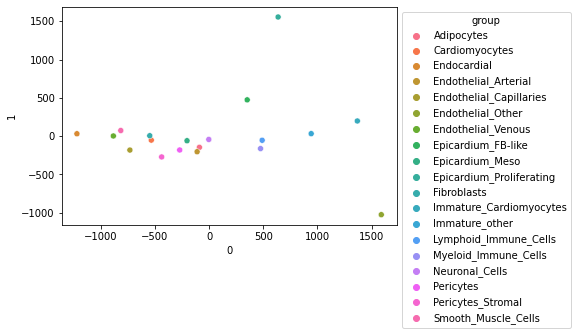

In [401]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
#df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


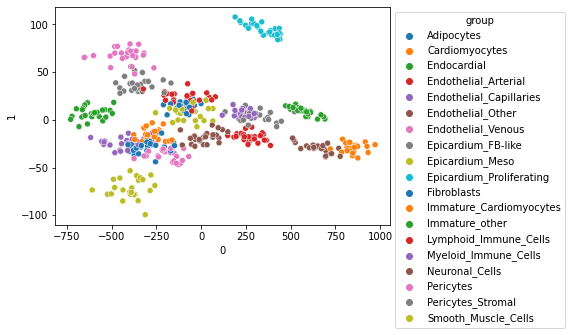

In [395]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
#df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette='tab10'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [366]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

#loading_matrix_atac = pd.DataFrame(loadings, index=df_meta_3.index.tolist())

In [369]:
dk

0           1            2
group                                                         
Adipocytes                 -60.296059  229.602570   160.087250
Cardiomyocytes            -436.833679   31.692965   -33.729347
Endocardial              -1025.948364  -39.359669   -27.234610
Endothelial_Arterial      -102.727592  247.277374    84.035339
Endothelial_Capillaries   -658.159790  228.824966   137.324127
Endothelial_Other         1339.771240  888.078064    62.571697
Endothelial_Venous        -774.217041  -91.231133  -142.195526
Epicardium_FB-like         352.815277 -724.876770  -682.630737
Epicardium_Meso           -171.959244   10.675806   -61.073307
Epicardium_Proliferating   486.549683 -848.035828  1277.349487
Fibroblasts               -502.519012 -122.271606  -214.358475
Immature_Cardiomyocytes   1253.791138 -364.385376  -430.896545
Immature_other             831.602356  -33.661770   -71.877785
Lymphoid_Immune_Cells      417.398254  -14.589039  -145.959518
Myeloid_Immune_Cells       401.382965  200.281052    75.505249
Neuronal_Cells              14.268095   -3.726081   -86.529243
Pericytes                 -231.208633  162.577408   -43.778152
Pericytes_Stromal         -417.357971  434.366608   361.916138
Smooth_Muscle_Cells       -716.351501 -191.239426  -218.526093

In [368]:
loadings.shape

(2687773, 3)

<ipython-input-365-9d558bce060b>:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(df_dist, method='average')


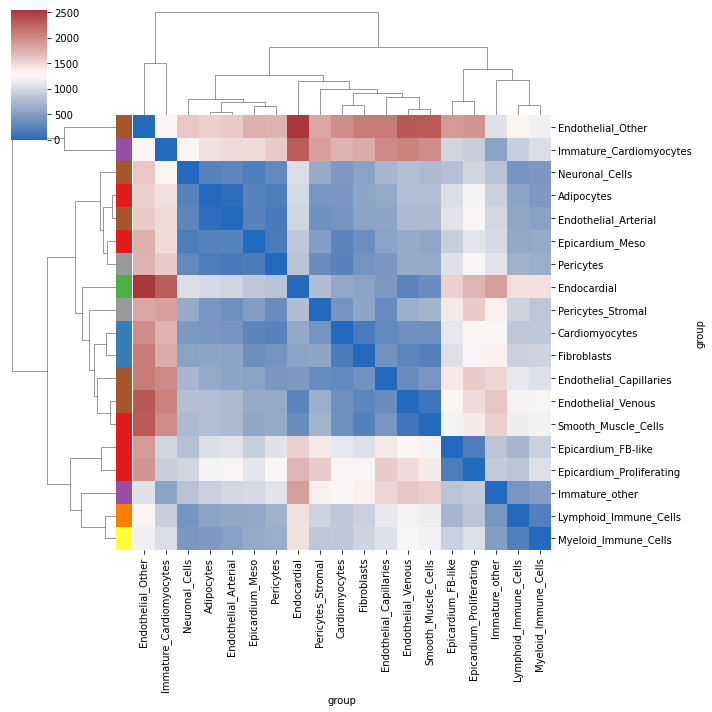

In [365]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = df_proj_2d
dk = dk.groupby(['group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, [0,1]]
#features = features.dropna(axis=0)
from scipy.spatial.distance import squareform, pdist
df_dist = sp.distance.squareform(pdist(features))
linkage = hc.linkage(df_dist, method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [406]:
pd.read_csv('/grid/gillis/data_norepl/lfrench/whole_mouse_brain/results/MetaMarkers_2009_reciprocals/MetaMarkers_default.csv.gz')



group               cell_type   rank                gene  recurrence  \
0          all  1005__Inh_Sox8_Cyp26b1      1  ENSMUSG00000047773           2   
1          all  1005__Inh_Sox8_Cyp26b1      2  ENSMUSG00000004698           2   
2          all  1005__Inh_Sox8_Cyp26b1      3  ENSMUSG00000031355           2   
3          all  1005__Inh_Sox8_Cyp26b1      4  ENSMUSG00000023809           2   
4          all  1005__Inh_Sox8_Cyp26b1      5  ENSMUSG00000040536           2   
...        ...                     ...    ...                 ...         ...   
43492836   all    994__Inh_Pax6_Eya4_1  21645  ENSMUSG00000029461           0   
43492837   all    994__Inh_Pax6_Eya4_1  21646  ENSMUSG00000040118           0   
43492838   all    994__Inh_Pax6_Eya4_1  21647  ENSMUSG00000055421           0   
43492839   all    994__Inh_Pax6_Eya4_1  21648  ENSMUSG00000026872           0   
43492840   all    994__Inh_Pax6_Eya4_1  21649  ENSMUSG00000056073           0   

             auroc  fold_change  fold_change_detection   expression  \
0         0.993169    42.422743               8.278509  1460.791908   
1         0.990107    10.608002               1.656483  3658.843540   
2         0.950421    18.535845               6.181723   911.561906   
3         0.950094     9.289101               3.116977   451.895337   
4         0.942894     8.538992               3.241198   803.677941   
...            ...          ...                    ...          ...   
43492836  0.224297     0.299672               0.687035    88.903174   
43492837  0.215111     0.015464               0.091253     5.603450   
43492838  0.213737     0.265837               1.043719  1205.541434   
43492839  0.206501     0.017303               0.148317     9.298031   
43492840  0.170569     0.118232               0.741096   120.219020   

          precision    recall  population_size  n_datasets   zeng  macosko  
0          0.001333  0.994555            689.0           2   True     True  
1          0.000267  1.000000            689.0           2   True     True  
2          0.000999  0.954941            689.0           2   True     True  
3          0.000501  0.963101            689.0           2   True     True  
4          0.000520  0.967034            689.0           2   True     True  
...             ...       ...              ...         ...    ...      ...  
43492836   0.000013  0.569444             76.0           2  False    False  
43492837   0.000002  0.052778             76.0           2  False    False  
43492838   0.000019  0.979167             76.0           2  False    False  
43492839   0.000003  0.092361             76.0           2  False    False  
43492840   0.000013  0.629167             76.0           2  False    False  

[43492841 rows x 15 columns]

<ipython-input-325-956c73ae35e9>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


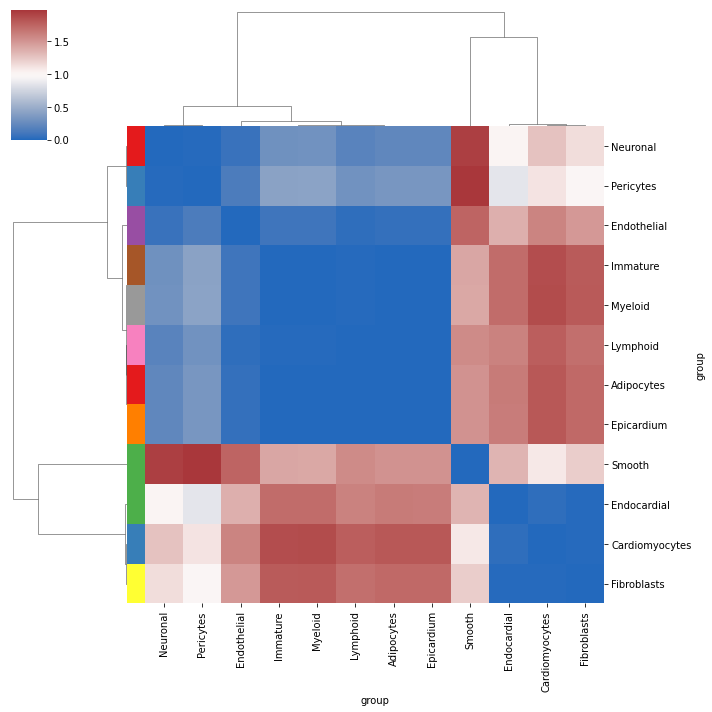

In [325]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = df_proj_2d
dk = dk.groupby(['group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
#features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [341]:
df_list_heart_repeat  = []
for number_of_times in range(1):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list[marker_list['rank'] < 100]
            #marker_list['count'] = marker_list.groupby(['Ensembl_gene_identifier'])['rank'].count().reset_index()['rank'].tolist()
            #marker_list = marker_list[marker_list['count'] < 5]
            marker_list['cell_type'] = [x.split('_')[0] for x in marker_list['cell_type']]
            marker_list = marker_list.sort_values(by=[ 'rank','auroc', ]).drop_duplicates(subset=['Ensembl_gene_identifier'] , keep=False)
            #marker_list = marker_list.sort_values(by=['rank',  'auroc'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 1000]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by='rank')
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart_repeat.append(df_gene_tp_all_info_mean)

            


<ipython-input-341-ff0480772f7b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]


<ipython-input-342-059c280ffcc2>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


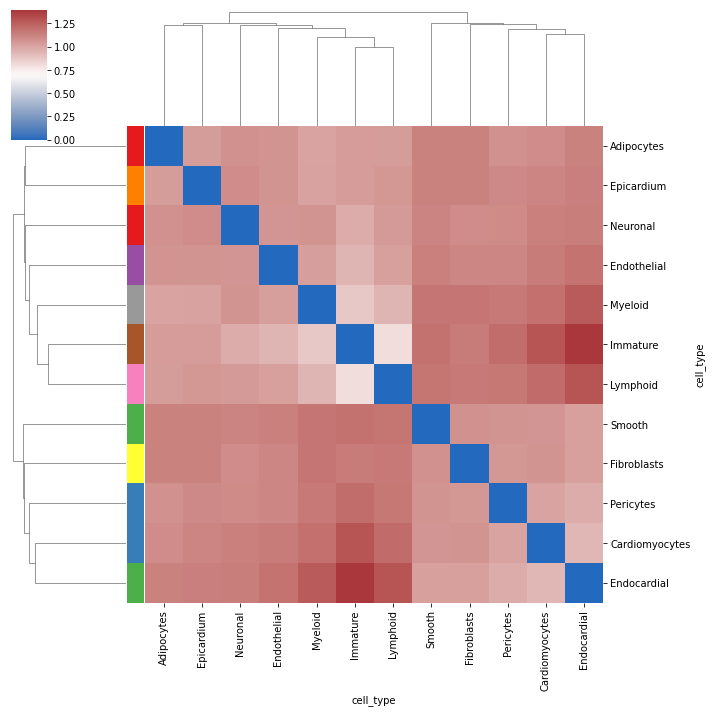

In [342]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
#dk = pd.concat(df_list_heart_400)
#dk = dk.reset_index()
#dk['cell_type'] = [x.split('_')[0] for x in dk['cell_type']]
dk = df_list_heart_repeat[0]
#dk = dk.groupby(['cell_type', 'boot_id']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [348]:
df_list_heart_repeat  = []
for number_of_times in range(1):
            marker_list_list = []
            marker_list = pd.read_csv('/grid/gillis/data_norepl/lohia/heart_hamsini/Knight-Schrijver_celltype_markers_res2.csv.gz', skiprows=1)
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            for group2 in all_cell_types:

                m_tmp = marker_list[marker_list['cell_type']==group2]

                m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]
                marker_list_list.append(m_tmp)
            marker_list = pd.concat(marker_list_list)
            
            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list = marker_list[marker_list['rank'] < 100]
            #marker_list['count'] = marker_list.groupby(['Ensembl_gene_identifier'])['rank'].count().reset_index()['rank'].tolist()
            #marker_list = marker_list[marker_list['count'] < 5]
            #marker_list['cell_type'] = [x.split('_')[0] for x in marker_list['cell_type']]
            marker_list = marker_list.sort_values(by=[ 'rank','auroc', ]).drop_duplicates(subset=['Ensembl_gene_identifier'] , keep=False)
            #marker_list = marker_list.sort_values(by=['rank',  'auroc'])
            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 1000]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                if number_of_times == 0:
                    df2_list.append(m_tmp)
                else:
                    df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by='rank')
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1






            marker_list = marker_list.sample(frac=1)

            marker_list = marker_list[['group', 'cell_type', 'Ensembl_gene_identifier']]

            df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

            df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

            df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

            df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

            df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

            df_gene_tp_all_info['boot_id'] = number_of_times

            df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['cell_type','group', 'boot_id']).mean()

            #df_list.append(df_gene_tp_all_info_mean)

            df_list_heart_repeat.append(df_gene_tp_all_info_mean)

            


<ipython-input-348-481452c348b3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['rank'] = [x+1 for x in range(m_tmp.shape[0])]


<ipython-input-349-059c280ffcc2>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


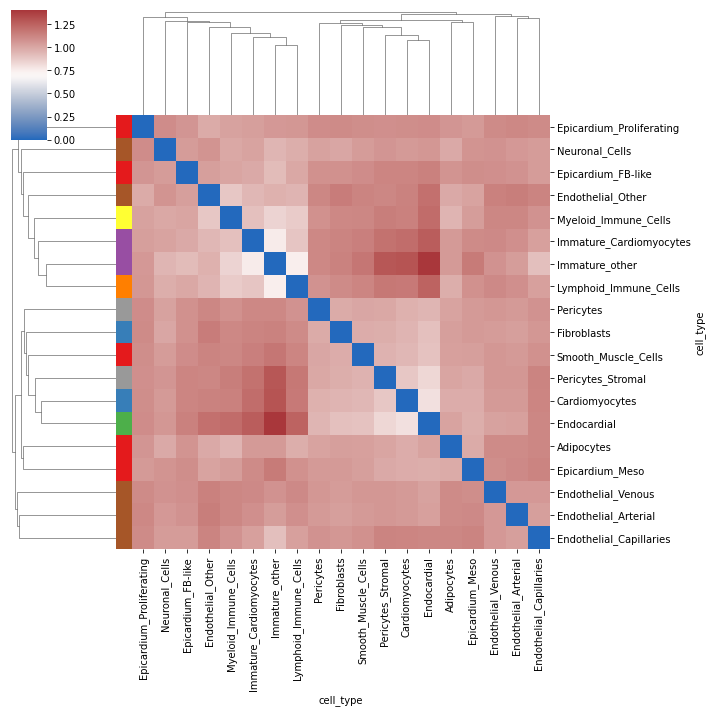

In [349]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
#dk = pd.concat(df_list_heart_400)
#dk = dk.reset_index()
#dk['cell_type'] = [x.split('_')[0] for x in dk['cell_type']]
dk = df_list_heart_repeat[0]
#dk = dk.groupby(['cell_type', 'boot_id']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


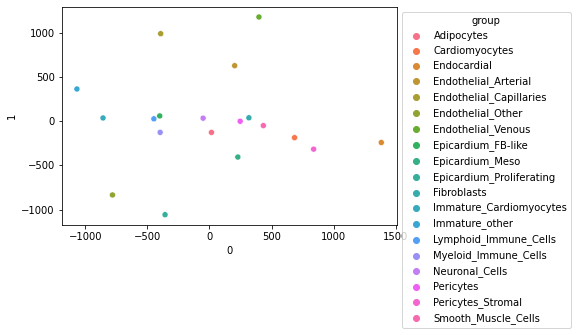

In [350]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
#df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


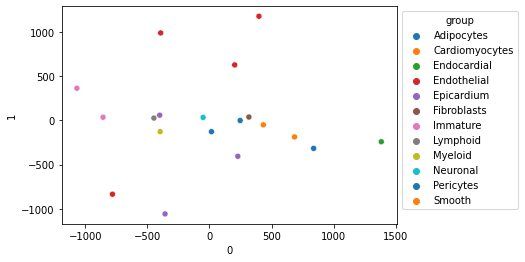

In [354]:
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-351-956c73ae35e9>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


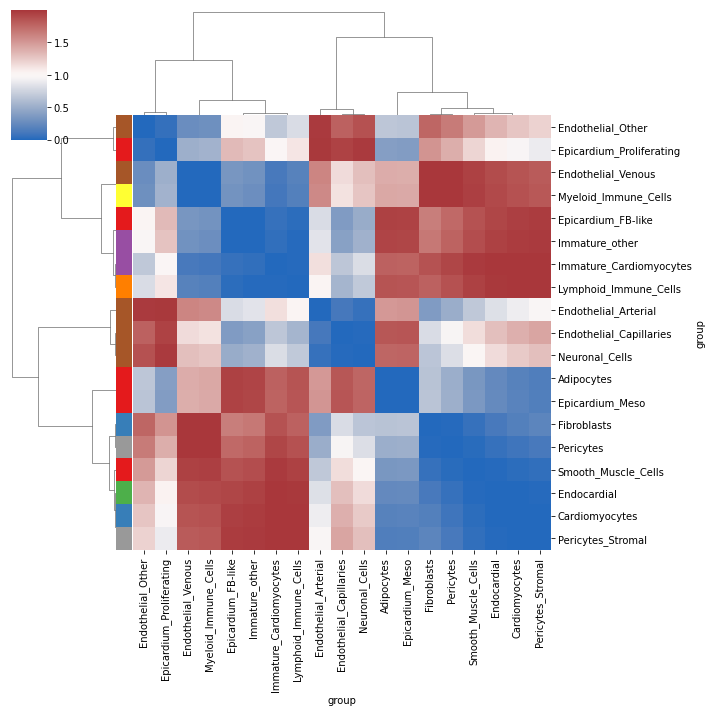

In [351]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
dk = df_proj_2d
dk = dk.groupby(['group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
#features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-334-059c280ffcc2>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


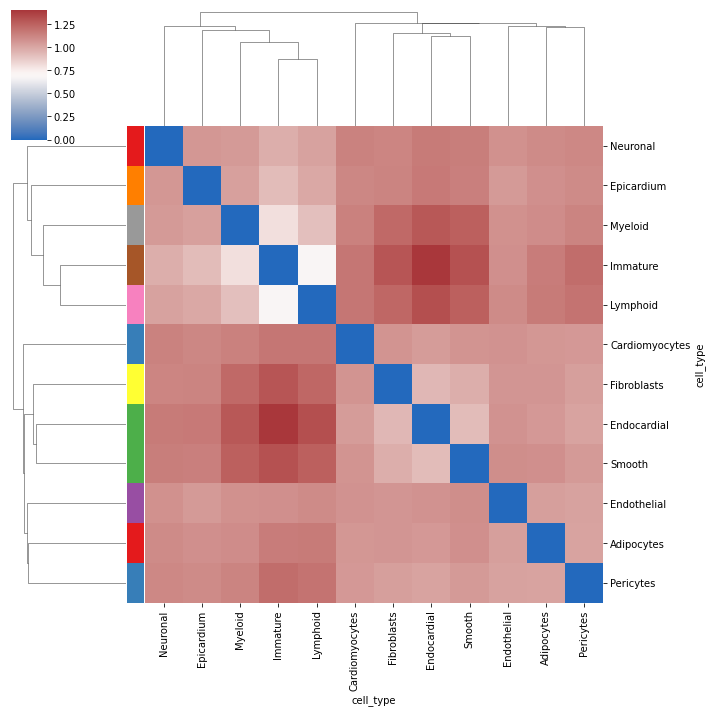

In [334]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)
#dk = df_gene_tp_all_info_mean
#dk = pd.concat(df_list_heart_400)
#dk = dk.reset_index()
#dk['cell_type'] = [x.split('_')[0] for x in dk['cell_type']]
dk = df_list_heart_repeat[0]
#dk = dk.groupby(['cell_type', 'boot_id']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


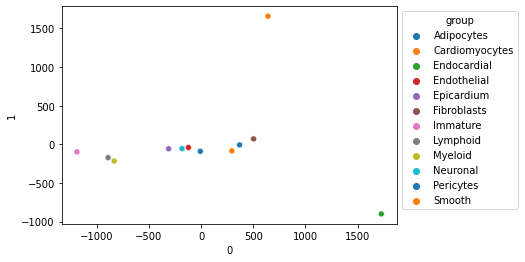

In [331]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_ylim([-300,300])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


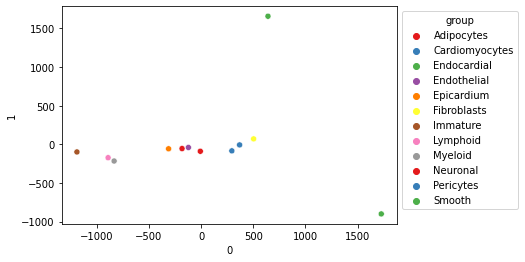

In [332]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="Set1"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_ylim([-300,300])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-200.0, 500.0)

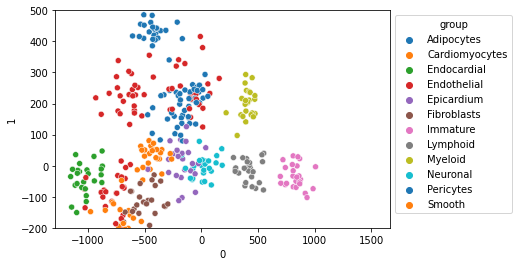

In [301]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim([-200,500])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


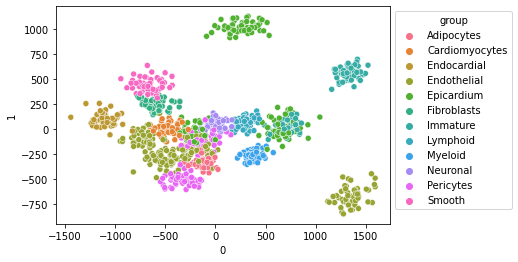

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


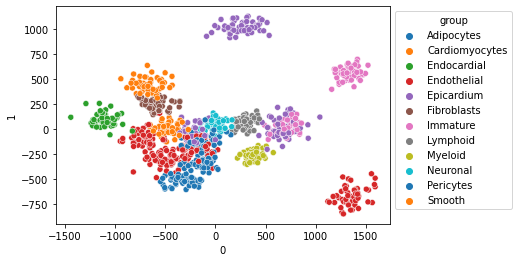

In [119]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_ylim([-300,300])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-500.0, 500.0)

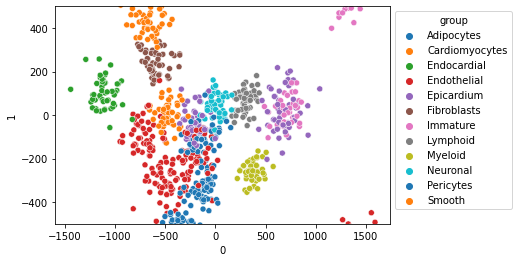

In [121]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim([-500,500])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


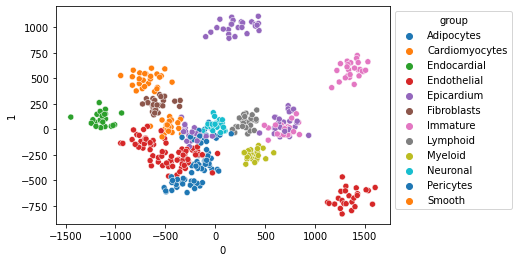

In [103]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_ylim([-300,300])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


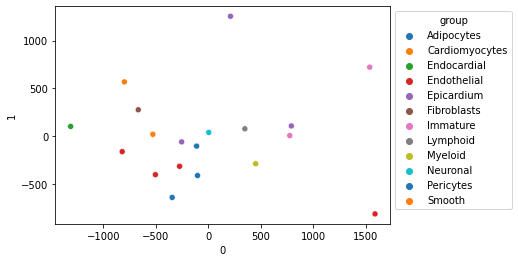

In [110]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


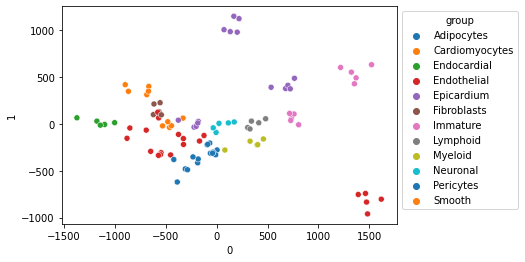

In [58]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


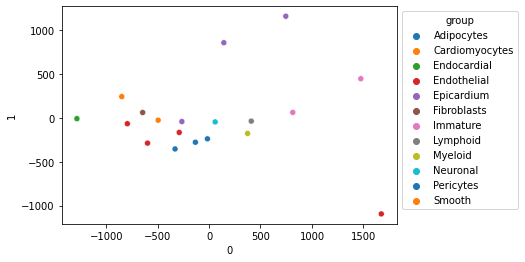

In [62]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


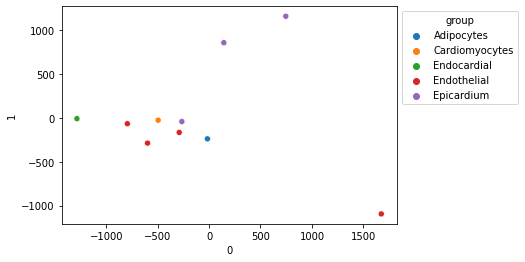

In [63]:
ax=sns.scatterplot(
    df_proj_2d.head(10)[0],df_proj_2d.head(10)[1],
    hue=df_proj_2d.head(10)['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


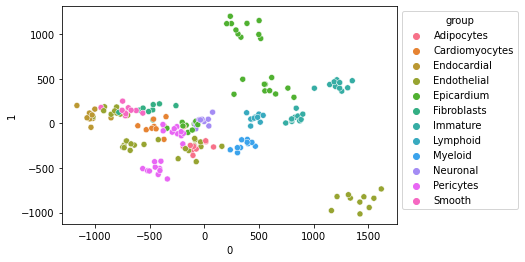

In [241]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)
#proj_2d = pca.fit_transform(1-R1)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('cell_type')
df_proj_2d['group'] = [x.split('_')[0] for x in df_proj_2d['group']]
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


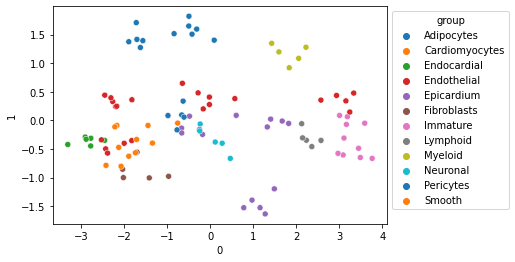

In [232]:
ax=sns.scatterplot(
    df_proj_2d.head(100)[0],df_proj_2d.head(100)[1],
    hue=df_proj_2d.head(100)['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


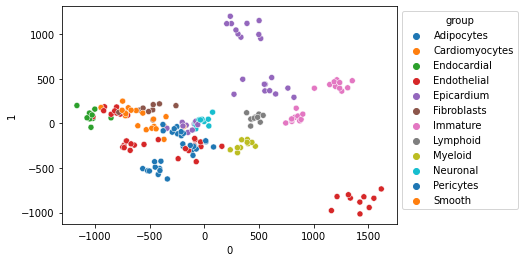

In [242]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


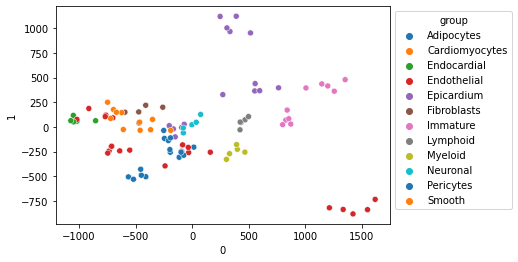

In [230]:
ax=sns.scatterplot(
    df_proj_2d.head(100)[0],df_proj_2d.head(100)[1],
    hue=df_proj_2d.head(100)['group'], palette="tab10"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


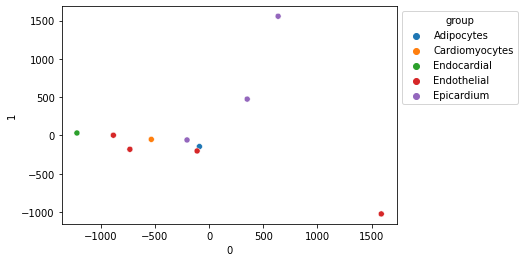

In [213]:
ax=sns.scatterplot(
    df_proj_2d.head(10)[0],df_proj_2d.head(10)[1],
    hue=df_proj_2d.head(10)['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


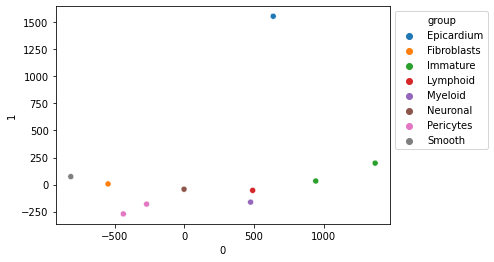

In [214]:
ax=sns.scatterplot(
    df_proj_2d.tail(10)[0],df_proj_2d.tail(10)[1],
    hue=df_proj_2d.tail(10)['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

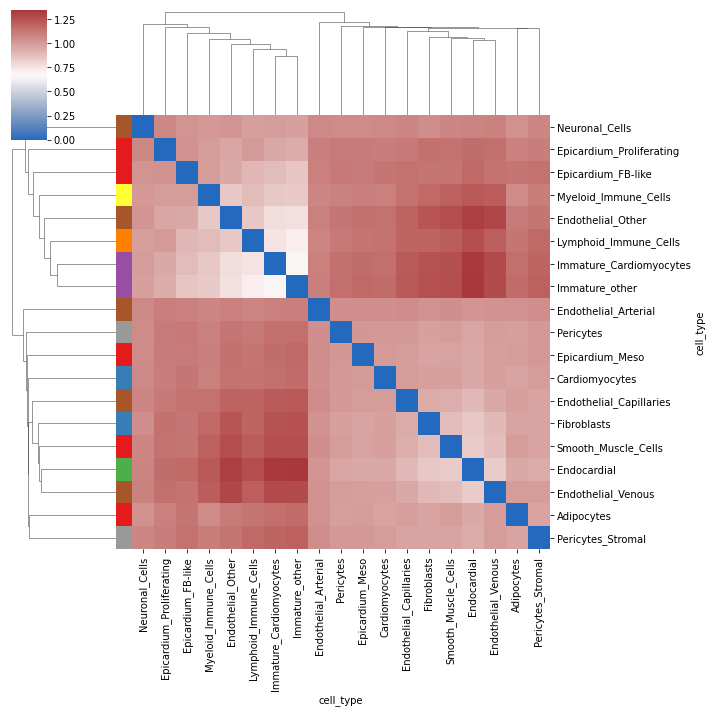

In [138]:
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('cell_type'), columns = features.index.get_level_values('cell_type'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [136]:
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()], sns.color_palette("Set1", 20)[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()]))


In [122]:
j = map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('cell_type').tolist()])

In [137]:
row_colors

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.6, 0.6, 0.6),
 (0.6, 0.6, 0.6),
 (0.89411764705

In [106]:
iter(row_colors).map(lut)

AttributeError: 'list_iterator' object has no attribute 'map'

In [99]:
dl = dk.index.get_level_values('cell_type')

In [100]:
dl

Index(['Adipocytes', 'Cardiomyocytes', 'Endocardial', 'Endothelial_Arterial',
       'Endothelial_Capillaries', 'Endothelial_Other', 'Endothelial_Venous',
       'Epicardium_FB-like', 'Epicardium_Meso', 'Epicardium_Proliferating',
       'Fibroblasts', 'Immature_Cardiomyocytes', 'Immature_other',
       'Lymphoid_Immune_Cells', 'Myeloid_Immune_Cells', 'Neuronal_Cells',
       'Pericytes', 'Pericytes_Stromal', 'Smooth_Muscle_Cells'],
      dtype='object', name='cell_type')

In [91]:
dk.index.get_level_values('cell_type')

Index(['Adipocytes', 'Cardiomyocytes', 'Endocardial', 'Endothelial_Arterial',
       'Endothelial_Capillaries', 'Endothelial_Other', 'Endothelial_Venous',
       'Epicardium_FB-like', 'Epicardium_Meso', 'Epicardium_Proliferating',
       'Fibroblasts', 'Immature_Cardiomyocytes', 'Immature_other',
       'Lymphoid_Immune_Cells', 'Myeloid_Immune_Cells', 'Neuronal_Cells',
       'Pericytes', 'Pericytes_Stromal', 'Smooth_Muscle_Cells'],
      dtype='object', name='cell_type')

In [87]:
['red', 'yellow', 'green', 'blue', 'blue', 'blue', 'blue', 'purple',  'purple', 'purple', '#e41a1c', '#377eb8', '#377eb8', '#984ea3', '#984ea3', '#ff7f00', '#ff7f00', '#a65628', '#f781bf',  '#f781bf', '#999999']

Index(['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33',
       '#a65628', '#f781bf', '#999999', '#e41a1c', '#377eb8', '#4daf4a',
       '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999',
       '#e41a1c'],
      dtype='object', name='cell_type')

In [77]:
dk.groupby(['cell_type', 'group', 'boot_id']).mean().reset_index()

0         1         2         3         4         5  \
key_0                                                                         
ENSG00000018189 -1.059425 -1.059425 -1.059425 -1.059425 -1.059425 -1.059425   
ENSG00000090013 -0.577363 -0.577363 -0.577363 -0.577363 -0.577363 -0.577363   
ENSG00000099821 -0.265425 -0.265425 -0.265425 -0.265425 -0.265425 -0.265425   
ENSG00000187498 -1.224241 -1.224241 -1.224241 -1.224241 -1.224241 -1.224241   
ENSG00000123989 -0.273454 -0.273454 -0.273454 -0.273454 -0.273454 -0.273454   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000244734 -0.244785 -0.244785 -0.244785 -0.244785 -0.244785 -0.244785   
ENSG00000214548 -1.013347 -1.013347 -1.013347 -1.013347 -1.013347 -1.013347   
ENSG00000137573 -1.202740 -1.202740 -1.202740 -1.202740 -1.202740 -1.202740   
ENSG00000138835 -1.262900 -1.262900 -1.262900 -1.262900 -1.262900 -1.262900   
ENSG00000169218       NaN       NaN       NaN       NaN       NaN       NaN   

                        6         7         8         9  ...   2875005  \
key_0                                                    ...             
ENSG00000018189 -1.059425 -1.059425 -1.059425 -1.059425  ... -1.059425   
ENSG00000090013 -0.577363 -0.577363 -0.577363 -0.577363  ... -0.577363   
ENSG00000099821 -0.265425 -0.265425 -0.265425 -0.265425  ... -0.265425   
ENSG00000187498 -1.224241 -1.224241 -1.224241 -1.224241  ... -1.224241   
ENSG00000123989 -0.273454 -0.273454 -0.273454 -0.273454  ... -0.273454   
...                   ...       ...       ...       ...  ...       ...   
ENSG00000244734 -0.244785 -0.244785 -0.244785 -0.244785  ... -0.244785   
ENSG00000214548 -1.013347 -1.013347 -1.013347 -1.013347  ... -1.013347   
ENSG00000137573 -1.202740 -1.202740 -1.202740 -1.202740  ... -1.202740   
ENSG00000138835 -1.262900 -1.262900 -1.262900 -1.262900  ... -1.262900   
ENSG00000169218       NaN       NaN       NaN       NaN  ... -0.572515   

                  2875006   2875007   2875008   2875009   2875010   2875011  \
key_0                                                                         
ENSG00000018189 -1.059425 -1.059425 -1.059425 -1.059425 -1.059425 -1.059425   
ENSG00000090013 -0.577363 -0.577363 -0.577363 -0.577363 -0.577363 -0.577363   
ENSG00000099821 -0.265425 -0.265425 -0.265425 -0.265425 -0.265425 -0.265425   
ENSG00000187498 -1.224241 -1.224241 -1.224241 -1.224241 -1.224241 -1.224241   
ENSG00000123989 -0.273454 -0.273454 -0.273454 -0.273454 -0.273454 -0.273454   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000244734 -0.244785 -0.244785 -0.244785 -0.244785 -0.244785 -0.244785   
ENSG00000214548 -1.013347 -1.013347 -1.013347 -1.013347 -1.013347 -1.013347   
ENSG00000137573 -1.202740 -1.202740 -1.202740 -1.202740 -1.202740 -1.202740   
ENSG00000138835 -1.262900 -1.262900 -1.262900 -1.262900 -1.262900 -1.262900   
ENSG00000169218 -0.572515 -0.572515 -0.572515 -0.572515 -0.572515 -0.572515   

                 group                cell_type  boot_id  
key_0                                                     
ENSG00000018189    all           Neuronal_Cells        0  
ENSG00000090013    all     Myeloid_Immune_Cells        0  
ENSG00000099821    all               Adipocytes        0  
ENSG00000187498    all  Endothelial_Capillaries        0  
ENSG00000123989    all          Epicardium_Meso        0  
...                ...                      ...      ...  
ENSG00000244734    all    Lymphoid_Immune_Cells        0  
ENSG00000214548    all           Neuronal_Cells        0  
ENSG00000137573    all     Endothelial_Arterial        0  
ENSG00000138835    all  Endothelial_Capillaries        0  
ENSG00000169218    all          Epicardium_Meso        0  

[1982 rows x 2875015 columns]

In [76]:
dk[2875005]

key_0
ENSG00000018189   -1.059425
ENSG00000090013   -0.577363
ENSG00000099821   -0.265425
ENSG00000187498   -1.224241
ENSG00000123989   -0.273454
                     ...   
ENSG00000244734   -0.244785
ENSG00000214548   -1.013347
ENSG00000137573   -1.202740
ENSG00000138835   -1.262900
ENSG00000169218   -0.572515
Name: 2875005, Length: 1982, dtype: float32

<ipython-input-164-e5c6d723eabc>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


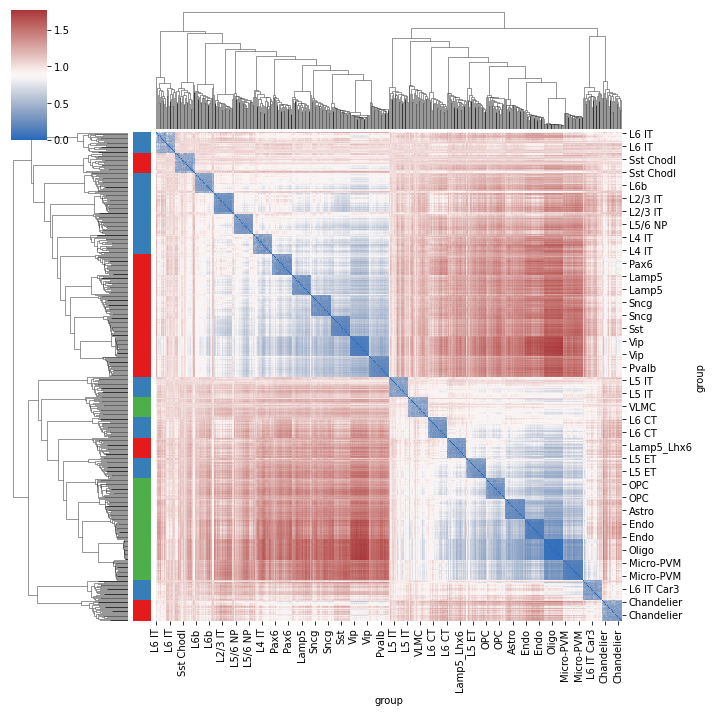

In [164]:
#dj = pd.concat(df_list)
dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




<ipython-input-260-198fa8b2833c>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


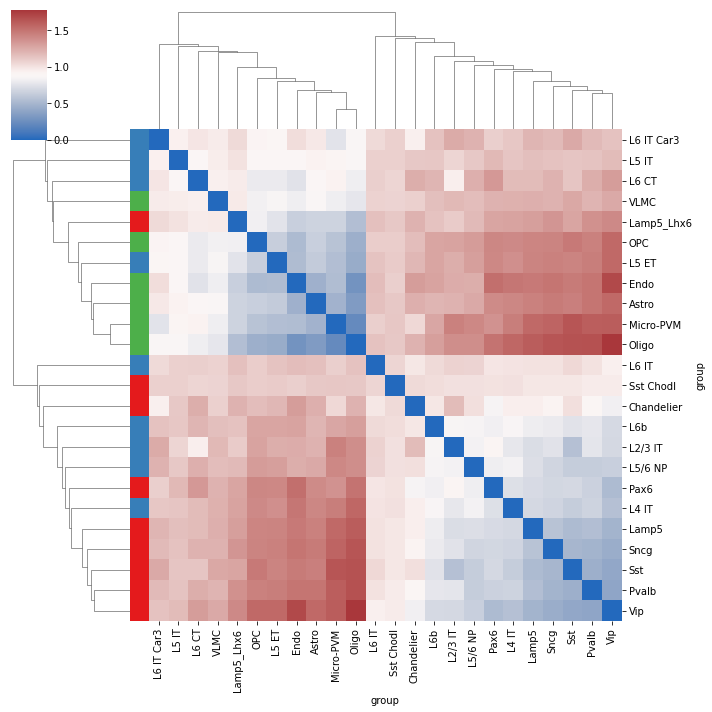

In [260]:
#dj = pd.concat(df_list)
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
#dj = dj[dj['classt']=='GABAergic']
dj['classt'] = ['Non-neuronal' if x =='Other' else x for x in dj['classt']]
dk = dj.groupby(['classt','group']).mean()
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


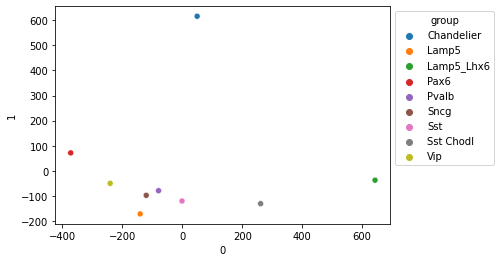

In [161]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [139]:
dk.reset_index()[dk.reset_index()['classt'] == 'Glutamatergic']['group'].tolist()

['L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET'

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


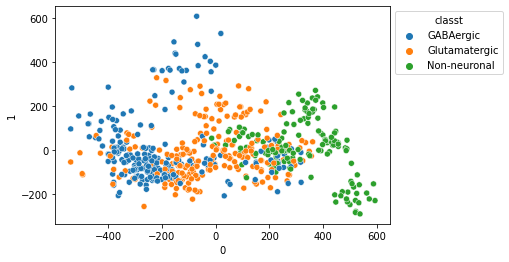

In [165]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

#dj = pd.concat(df_list)
dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


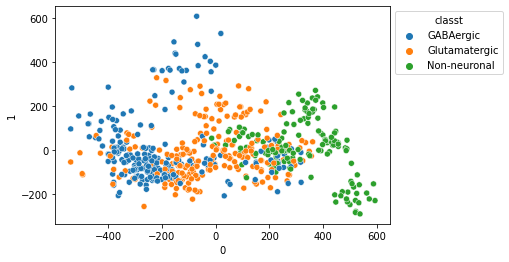

In [263]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

#dj = pd.concat(df_list)
dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


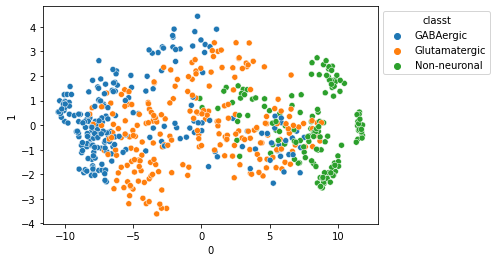

In [167]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(1-R1)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


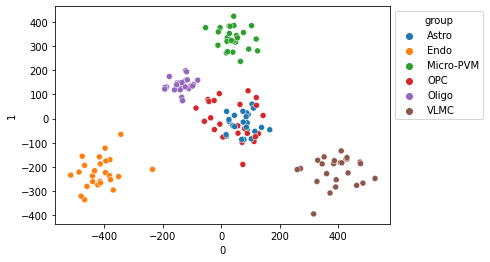

In [270]:

dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]

features = features[features.index.get_level_values('classt') == 'Non-neuronal']
features_sc =  StandardScaler().fit_transform(features)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [269]:
dk

0         1         2         3         4       \
classt       group                                                          
GABAergic    Chandelier -1.434351 -0.574166 -1.289942 -1.031649 -1.066979   
             Lamp5      -1.415600 -0.890418 -1.236613 -1.137077 -1.054456   
             Lamp5_Lhx6 -1.261802 -0.607148 -1.067453 -0.941119 -0.910698   
             Pax6       -1.415037 -0.700500 -1.242939 -0.976862 -1.073520   
             Pvalb      -1.377298 -0.849204 -1.214482 -1.031336 -1.038555   
...                           ...       ...       ...       ...       ...   
Non-neuronal Endo       -1.198918 -0.321787 -1.026134 -0.726074 -0.856793   
             Micro-PVM  -1.319406 -0.720555 -1.180765 -1.008778 -0.988025   
             OPC        -1.273148 -0.661578 -1.089704 -0.971398 -0.945618   
             Oligo      -1.253828 -0.531657 -1.093847 -0.939672 -0.904596   
             VLMC       -1.299736 -0.825279 -1.200450 -1.014105 -1.018637   

                           5         6         7         8         9       \
classt       group                                                          
GABAergic    Chandelier -0.317895 -0.390585 -0.764957 -0.379733 -0.859309   
             Lamp5      -0.468762 -0.612721 -0.750203 -0.429749 -0.825286   
             Lamp5_Lhx6 -0.064115 -0.275690 -0.450061 -0.015791 -0.493327   
             Pax6       -0.230398 -0.506596 -0.686030 -0.262452 -0.785207   
             Pvalb      -0.440621 -0.474795 -0.686372 -0.388775 -0.775782   
...                           ...       ...       ...       ...       ...   
Non-neuronal Endo        0.173790  0.134180 -0.127411  0.529311 -0.175412   
             Micro-PVM  -0.302192 -0.269983 -0.552222 -0.203100 -0.683087   
             OPC        -0.241145 -0.386089 -0.583959 -0.336163 -0.604798   
             Oligo      -0.095958 -0.214541 -0.490036 -0.019134 -0.542602   
             VLMC       -0.402915 -0.502417 -0.661331 -0.294095 -0.707911   

                         ...    287499    287500    287501    287502  \
classt       group       ...                                           
GABAergic    Chandelier  ... -1.091821 -1.297956 -0.890958 -1.412922   
             Lamp5       ... -1.069776 -1.258868 -1.191702 -1.407214   
             Lamp5_Lhx6  ... -0.931557 -1.169865 -1.126529 -1.264626   
             Pax6        ... -1.055529 -1.298632 -1.170932 -1.408251   
             Pvalb       ... -1.039834 -1.223430 -1.134730 -1.370854   
...                      ...       ...       ...       ...       ...   
Non-neuronal Endo        ... -0.867918 -1.061973 -0.958688 -1.171947   
             Micro-PVM   ... -0.948453 -1.172259 -1.073503 -1.301921   
             OPC         ... -0.977150 -1.191274 -1.092841 -1.276964   
             Oligo       ... -0.909382 -1.110905 -1.022847 -1.236756   
             VLMC        ... -0.955210 -1.147165 -1.074306 -1.284702   

                           287503    287504    287505    287506    287507  \
classt       group                                                          
GABAergic    Chandelier -0.820811 -0.043169 -0.416802 -0.419258 -1.026658   
             Lamp5      -0.741027  0.034639 -0.160859 -0.403535 -1.003666   
             Lamp5_Lhx6 -0.616782  0.416139 -0.082892 -0.205509 -0.939204   
             Pax6       -0.641272  0.262456 -0.357975 -0.229519 -0.988465   
             Pvalb      -0.640240  0.102707 -0.290087 -0.285476 -0.982215   
...                           ...       ...       ...       ...       ...   
Non-neuronal Endo       -0.447101  0.578577  0.007078 -0.029588 -0.817280   
             Micro-PVM  -0.520166  0.497789 -0.020301 -0.142541 -0.924708   
             OPC        -0.528906  0.385953 -0.063767 -0.074158 -0.905098   
             Oligo      -0.495875  0.453568  0.010275 -0.091367 -0.808091   
             VLMC       -0.595596  0.260784 -0.038250 -0.150822 -0.883872   

                           287508  
classt       group                 
GABAergic   

In [266]:
features[features.index.get_level_values('classt') == 'GABAergic']

793       794       795       796       797     \
classt    group                                                          
GABAergic Chandelier  0.495444  0.516357  0.096440  0.087150  0.599601   
          Lamp5       0.363749  0.720976  0.109401 -0.194423  0.603928   
          Lamp5_Lhx6  0.905038  0.895206  0.472935 -0.024145  0.717577   
          Pax6        0.474847  0.710719  0.051476 -0.146006  0.506244   
          Pvalb       0.652398  0.621498  0.229712 -0.097444  0.608472   
...                        ...       ...       ...       ...       ...   
          Pvalb       0.621424  0.585043  0.166111 -0.081271  0.584235   
          Sncg        0.643587  0.703861  0.475658 -0.143440  0.631221   
          Sst         0.649573  0.745306  0.204640 -0.080510  0.712164   
          Sst Chodl   0.626151  0.699083  0.332628 -0.191984  0.574507   
          Vip         0.556466  0.734434  0.156233 -0.117752  0.576490   

                        798       799       800       801       802     ...  \
classt    group                                                         ...   
GABAergic Chandelier  0.241758  0.371782  1.151441  0.828590 -0.005677  ...   
          Lamp5       0.337334  0.276577  0.459124  0.862201  0.020742  ...   
          Lamp5_Lhx6  0.238986  0.479155  0.617170  0.837423  0.138885  ...   
          Pax6        0.177315  0.505915  0.521363  0.802565  0.018119  ...   
          Pvalb       0.223410  0.457833  0.428914  0.741030  0.050721  ...   
...                        ...       ...       ...       ...       ...  ...   
          Pvalb       0.207197  0.385398  0.362090  0.726300  0.037745  ...   
          Sncg        0.073241  0.493582  0.381759  0.771365  0.035667  ...   
          Sst         0.217262  0.370425  0.472406  0.700625  0.014832  ...   
          Sst Chodl   0.130174  0.405748  0.267730  0.944561 -0.008601  ...   
          Vip         0.142612  0.339782  0.417044  0.665093  0.120681  ...   

                        287499    287500    287501    287502    287503  \
classt    group                                                          
GABAergic Chandelier -1.091821 -1.297956 -0.890958 -1.412922 -0.820811   
          Lamp5      -1.069776 -1.258868 -1.191702 -1.407214 -0.741027   
          Lamp5_Lhx6 -0.931557 -1.169865 -1.126529 -1.264626 -0.616782   
          Pax6       -1.055529 -1.298632 -1.170932 -1.408251 -0.641272   
          Pvalb      -1.039834 -1.223430 -1.134730 -1.370854 -0.640240   
...                        ...       ...       ...       ...       ...   
          Pvalb      -1.011007 -1.237861 -1.094517 -1.360389 -0.624705   
          Sncg       -1.062469 -1.217789 -1.176409 -1.389299 -0.704605   
          Sst        -1.020989 -1.207625 -1.130582 -1.288125 -0.607480   
          Sst Chodl  -1.008048 -1.254874 -1.133755 -1.353685 -0.684028   
          Vip        -1.095609 -1.279680 -1.207807 -1.399115 -0.717139   

                        287504    287505    287506    287507    287508  
classt    group                                                         
GABAergic Chandelier -0.043169 -0.416802 -0.419258 -1.026658 -1.452875  
          Lamp5       0.034639 -0.160859 -0.403535 -1.003666 -1.418105  
          Lamp5_Lhx6  0.416139 -0.082892 -0.205509 -0.939204 -1.279613  
          Pax6        0.262456 -0.357975 -0.229519 -0.988465 -1.425800  
          Pvalb       0.102707 -0.290087 -0.285476 -0.982215 -1.397838  
...                        ...       ...       ...       ...       ...  
          Pvalb       0.178503 -0.201879 -0.254793 -0.705820 -1.382301  
          Sncg       -0.017557 -0.347093 -0.376936 -1.009115 -1.407921  
          Sst         0.245971 -0.218770 -0.176244 -0.863929 -1.346663  
          Sst Chodl   0.395576 -0.014763 -0.253259 -0.944415 -1.353685  
          Vip        -0.031567 -0.378851 -0.429875 -0.999598 -1.412491  

[225 rows x 264607 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


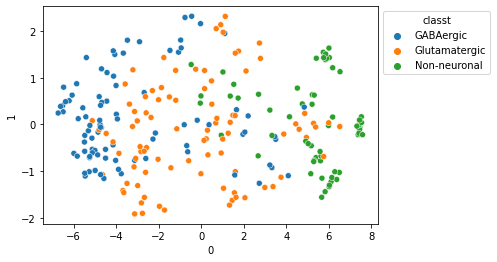

In [132]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(1-R1)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


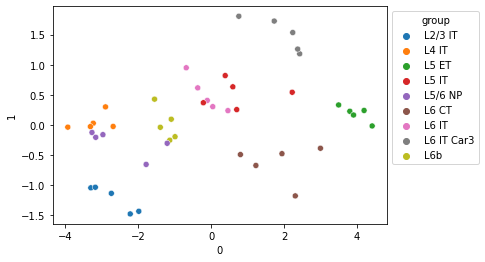

In [108]:
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'GABAergic']
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


<ipython-input-22-37f3b307d73b>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


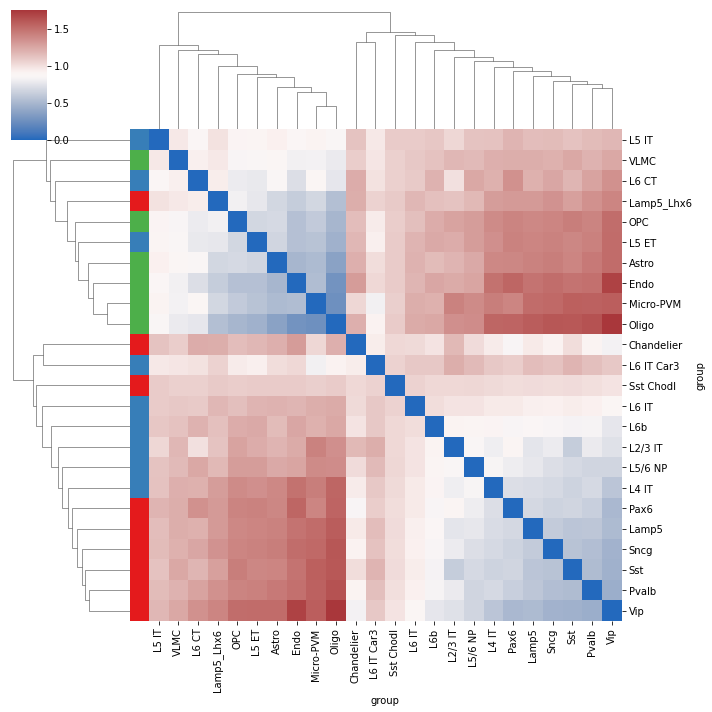

In [22]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list)
dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


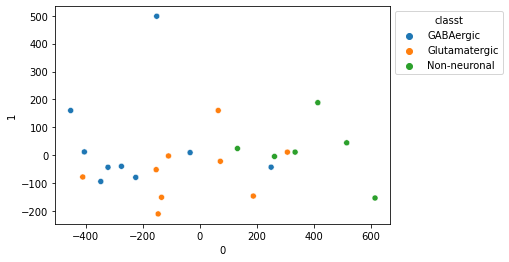

In [86]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


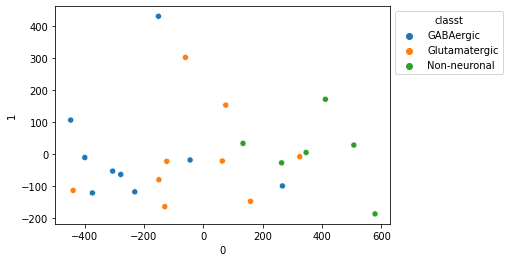

In [74]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [24]:
full_input_path = f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/max/'
full_target_path = f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/10kbp_raw/max/'

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {full_input_path}/all_bins_true_minmatch0.1_mouse.bed -a {full_target_path}/all_bins_true.bed > {full_target_path}/all_bins_true_minmatch0.1_mouse_intersect.bed")
          

df_human_mouse_bins = pd.read_csv(f'{full_target_path}/all_bins_true_minmatch0.1_mouse_intersect.bed', sep='\t', names=['a', 'b', 'c', 'mouse_bin', 'a1', 'b1', 'c1', 'human_bin', 'overlap'])



df_human_mouse_bins['length'] = df_human_mouse_bins['c1'] - df_human_mouse_bins['b1']



df_human_mouse_bins = df_human_mouse_bins.sort_values(['overlap'], ascending=False).drop_duplicates(subset=['human_bin']).drop_duplicates(subset=['mouse_bin'])



df_human_mouse_bins.to_csv('./human_mouse_bin.csv')



In [179]:
df_human_mouse_bins = pd.read_csv('./human_mouse_bin.csv')


human_bins = list(set(df_human_mouse_bins['human_bin']).intersection(pure_bins))

dj = pd.concat(df_list)

#dj = dj.reset_index()
#dj = dj[dj['classt']!='Otheer']
#dj['classt'] = ['Non-neuronal' if x =='Other' else x for x in dj['classt']]
#dk = dj.groupby(['classt','group']).mean()


dj.loc[:,human_bins].to_csv('./human_features.csv')

In [ ]:
dk  = pd.concat(df_list)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


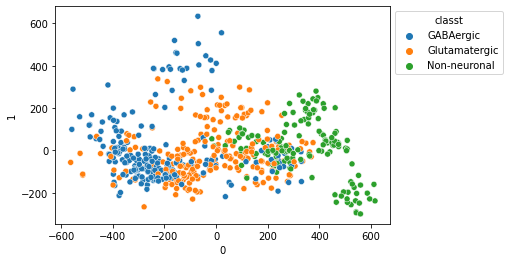

In [172]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

features = dk.loc[:, :]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


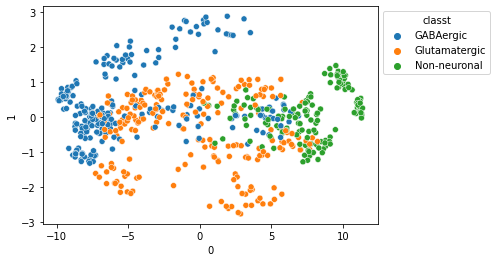

In [177]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_human_mouse_bins = pd.read_csv('./human_mouse_bin.csv')


human_bins = list(set(df_human_mouse_bins['human_bin']).intersection(pure_bins))

features = dk.loc[:, human_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(R1)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


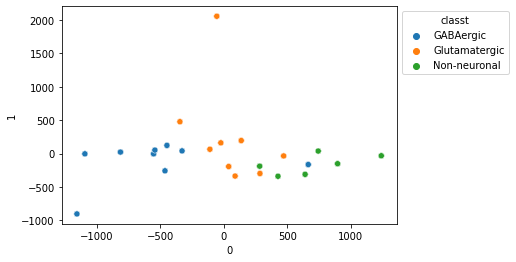

In [66]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


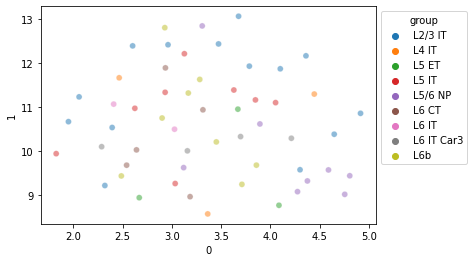

In [52]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



<ipython-input-75-073a3cbb06d1>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


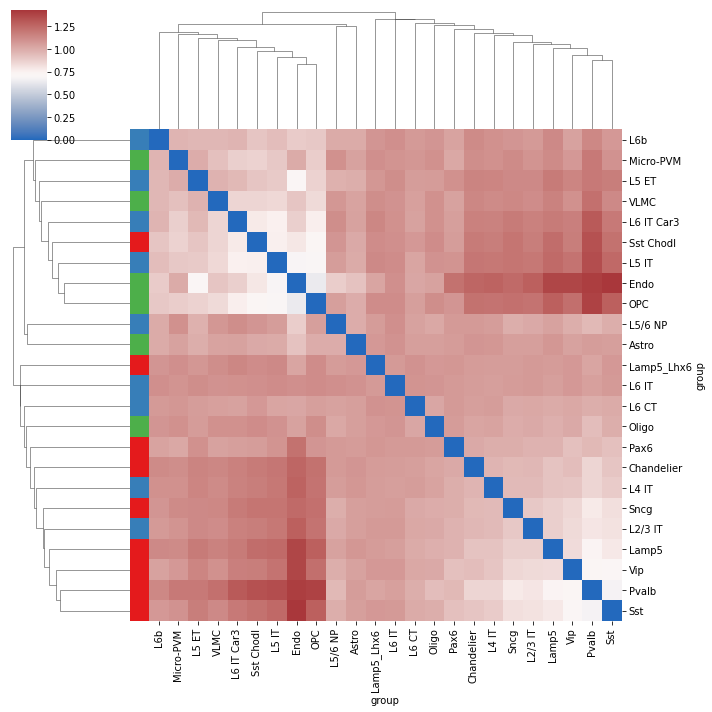

In [75]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [45]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group', 'cell_type']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



KeyError: 'cell_type'

In [46]:
df_gene_tp_all_info_mean


0         1         2         3         4        \
classt        group                                                          
GABAergic     Chandelier -0.996336 -0.996336 -0.996336 -0.996336 -0.996336   
              Lamp5      -0.947891 -0.947891 -0.947891 -0.947891 -0.947891   
              Lamp5_Lhx6 -0.817473 -0.817473 -0.817473 -0.817473 -0.817473   
              Pax6       -0.959083 -0.959083 -0.959083 -0.959083 -0.959083   
              Pvalb      -0.945001 -0.945001 -0.945001 -0.945001 -0.945001   
              Sncg       -0.915993 -0.915993 -0.915993 -0.915993 -0.915993   
              Sst        -0.905499 -0.905499 -0.905499 -0.905499 -0.905499   
              Sst Chodl  -0.937941 -0.937941 -0.937941 -0.937941 -0.937941   
              Vip        -0.898982 -0.898982 -0.898982 -0.898982 -0.898982   
Glutamatergic L2/3 IT    -0.804836 -0.804836 -0.804836 -0.804836 -0.804836   
              L4 IT      -0.846813 -0.846813 -0.846813 -0.846813 -0.846813   
              L5 ET      -0.890504 -0.890504 -0.890504 -0.890504 -0.890504   
              L5 IT      -0.825292 -0.825292 -0.825292 -0.825292 -0.825292   
              L5/6 NP    -0.844321 -0.844321 -0.844321 -0.844321 -0.844321   
              L6 CT      -0.911240 -0.911240 -0.911240 -0.911240 -0.911240   
              L6 IT      -0.886529 -0.886529 -0.886529 -0.886529 -0.886529   
              L6 IT Car3 -0.907857 -0.907857 -0.907857 -0.907857 -0.907857   
              L6b        -0.871194 -0.871194 -0.871194 -0.871194 -0.871194   
Non-neuronal  Astro      -0.767853 -0.767853 -0.767853 -0.767853 -0.767853   
              Endo       -0.771186 -0.771186 -0.771186 -0.771186 -0.771186   
              Micro-PVM  -0.859538 -0.859538 -0.859538 -0.859538 -0.859538   
              OPC        -0.872718 -0.872718 -0.872718 -0.872718 -0.872718   
              Oligo      -0.793734 -0.793734 -0.793734 -0.793734 -0.793734   
              VLMC       -0.870801 -0.870801 -0.870801 -0.870801 -0.870801   

                           5         6         7         8         9        \
classt        group                                                          
GABAergic     Chandelier -0.996336 -0.996336 -0.996336 -0.996336 -0.996336   
              Lamp5      -0.947891 -0.947891 -0.947891 -0.947891 -0.947891   
              Lamp5_Lhx6 -0.817473 -0.817473 -0.817473 -0.817473 -0.817473   
              Pax6       -0.959083 -0.959083 -0.959083 -0.959083 -0.959083   
              Pvalb      -0.945001 -0.945001 -0.945001 -0.945001 -0.945001   
              Sncg       -0.915993 -0.915993 -0.915993 -0.915993 -0.915993   
              Sst        -0.905499 -0.905499 -0.905499 -0.905499 -0.905499   
              Sst Chodl  -0.937941 -0.937941 -0.937941 -0.937941 -0.937941   
              Vip        -0.898982 -0.898982 -0.898982 -0.898982 -0.898982   
Glutamatergic L2/3 IT    -0.804836 -0.804836 -0.804836 -0.804836 -0.804836   
              L4 IT      -0.846813 -0.846813 -0.846813 -0.846813 -0.846813   
              L5 ET      -0.890504 -0.890504 -0.890504 -0.890504 -0.890504   
              L5 IT      -0.825292 -0.825292 -0.825292 -0.825292 -0.825292   
              L5/6 NP    -0.844321 -0.844321 -0.844321 -0.844321 -0.844321   
              L6 CT      -0.911240 -0.911240 -0.911240 -0.911240 -0.911240   
              L6 IT      -0.886529 -0.886529 -0.886529 -0.886529 -0.886529   
              L6 IT Car3 -0.907857 -0.907857 -0.907857 -0.907857 -0.907857   
              L6b        -0.871194 -0.871194 -0.871194 -0.871194 -0.871194   
Non-neuronal  Astro      -0.767853 -0.767853 -0.767853 -0.767853 -0.767853   
              Endo       -0.771186 -0.771186 -0.771186 -0.771186 -0.771186   
              Micro-PVM  -0.859538 -0.859538 -0.859538 -0.859538 -0.859538   
              OPC        -0.872718 -0.872718 -0.872718 -0.872718 -0.872718   
              Oligo      -0.793734 -0.793734 -0.793734 -0.793734 -0.793734   
              VLMC       -0.870801 -0.870801 -0.

In [ ]:
df_human_mouse_bins = pd.read_csv('./human_mouse_bin.csv')


human_bins = list(set(df_human_mouse_bins['human_bin']).intersection(pure_bins))


df_gene_tp_all_info_mean.loc[:,human_bins].to_csv('./human_features.csv')


In [31]:
features


793       794       795       796       797      \
classt        group                                                          
GABAergic     Chandelier  0.362401  0.016082 -0.320243 -0.126469 -0.088139   
              Lamp5       0.111175 -0.013445 -0.406398 -0.266252 -0.202310   
              Lamp5_Lhx6  0.611868  0.176489 -0.198284 -0.034195  0.173038   
              Pax6        0.220783 -0.214173 -0.290417 -0.047872  0.016612   
              Pvalb       0.299392 -0.058238 -0.267023 -0.074392 -0.094251   
              Sncg        0.355400  0.005856 -0.356420 -0.255332 -0.222907   
              Sst         0.347751 -0.031220 -0.233320 -0.137813 -0.045516   
              Sst Chodl   0.341086 -0.052587 -0.216088 -0.163342  0.084582   
              Vip         0.212139 -0.004039 -0.321202 -0.150499 -0.168677   
Glutamatergic L2/3 IT     0.278380  0.009539 -0.309453 -0.164460 -0.099746   
              L4 IT       0.183361  0.202971 -0.392126 -0.195939 -0.138113   
              L5 ET       0.547875  0.149982 -0.226108 -0.025703 -0.022000   
              L5 IT       0.361109  0.005157 -0.207005 -0.046186  0.010810   
              L5/6 NP     0.306133 -0.105821 -0.370068 -0.238194 -0.099754   
              L6 CT       0.269772 -0.049005 -0.114383  0.033434 -0.119939   
              L6 IT       0.310557 -0.096835 -0.127009  0.059621 -0.088234   
              L6 IT Car3  0.435551  0.070977 -0.253665  0.085009 -0.066565   
              L6b         0.313878 -0.057004 -0.327877 -0.149928  0.101843   
Non-neuronal  Astro       0.261668  0.006744 -0.150857  0.009855 -0.059267   
              Endo        0.457007 -0.004726 -0.197206  0.036210  0.082802   
              Micro-PVM   0.434545  0.034826 -0.150135 -0.092485  0.049517   
              OPC         0.350390 -0.090665 -0.255635 -0.136469 -0.066742   
              Oligo       0.460597  0.087403 -0.130170  0.003769 -0.013303   
              VLMC        0.463517  0.106588 -0.174842 -0.067333 -0.088589   

                           798       799       800       801       802      \
classt        group                                                          
GABAergic     Chandelier -0.070393 -0.053113 -0.071179 -0.049447 -0.185407   
              Lamp5      -0.134314 -0.170137 -0.080537 -0.107453 -0.131731   
              Lamp5_Lhx6 -0.063256 -0.113046  0.147113  0.082178 -0.135963   
              Pax6       -0.359106 -0.049655 -0.067954 -0.036343 -0.308248   
              Pvalb      -0.248177 -0.107967 -0.084158 -0.006163 -0.002930   
              Sncg       -0.310307 -0.017956 -0.153633 -0.010544 -0.083294   
              Sst        -0.266009 -0.096282 -0.029109  0.039718 -0.048134   
              Sst Chodl  -0.194900 -0.102317 -0.162408  0.282397 -0.166042   
              Vip        -0.265533 -0.119943 -0.073750 -0.025149 -0.129726   
Glutamatergic L2/3 IT    -0.255591  0.087036 -0.089406  0.013689  0.008852   
              L4 IT      -0.113369 -0.096133  0.253589  0.037086  0.082202   
              L5 ET      -0.225913  0.003766 -0.054706  0.080769 -0.009198   
              L5 IT      -0.169258 -0.007961 -0.074713  0.086235  0.007145   
              L5/6 NP    -0.344896 -0.082412 -0.086745  0.037717 -0.075194   
              L6 CT      -0.146344  0.008106  0.088700 -0.014442  0.033526   
              L6 IT      -0.098640 -0.108887 -0.040922  0.066906  0.253085   
              L6 IT Car3 -0.134312  0.025035 -0.043131  0.086440  0.091252   
              L6b        -0.258289  0.015598 -0.073740  0.023218 -0.089003   
Non-neuronal  Astro      -0.103738 -0.003468 -0.012410  0.203981 -0.034548   
              Endo       -0.083597  0.024576  0.160383  0.105481  0.105294   
              Micro-PVM  -0.166065  0.217836  0.162784  0.227873  0.001728   
              OPC        -0.153865  0.023756  0.194230  0.347373 -0.132494   
              Oligo      -0.184736  0.050823  0.079491  0.175213  0.033324   
              VLMC       -0.172458 -0.119424  0.

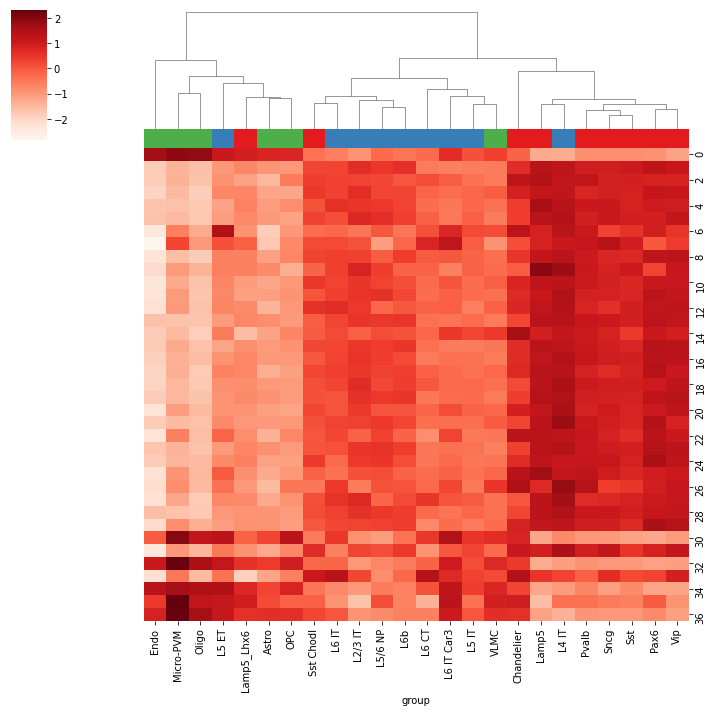

In [69]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='Reds')


In [53]:
dl = df_gene_tp_all_info_mean
dl = dl.reset_index()
dj = dl[dl['classt']!='Glutamatergicm']
dk = dj.groupby(['classt','group']).mean()
features = dk.loc[:, pure_bins]
features = features.dropna(axis=1)
#features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


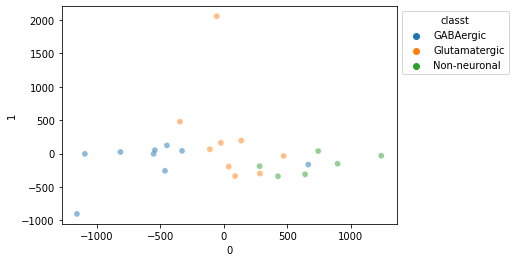

In [54]:
#umap_2d = UMAP(n_components=2, init='random', random_state=10)


#proj_2d = umap_2d.fit_transform(features_sc)

#df_proj_2d= pd.DataFrame(proj_2d)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


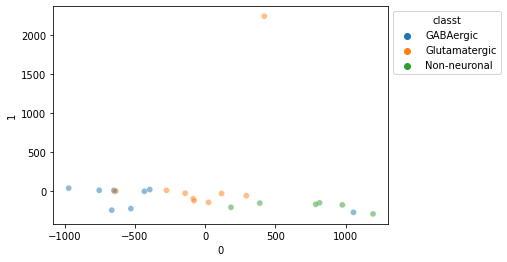

In [217]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


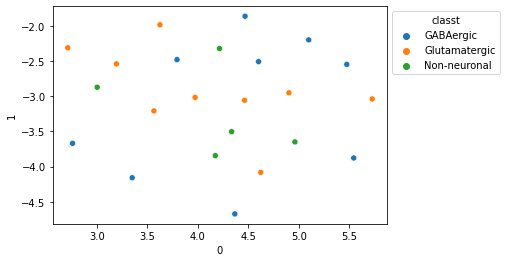

In [302]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


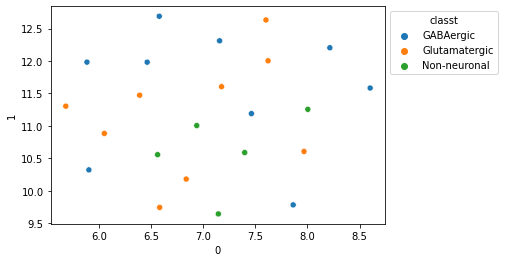

In [299]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [122]:
#df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [123]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [199]:
all_marker_1 = list(np.arange(1,300, 3, dtype='int'))

all_marker_2 = list(np.arange(2,300, 3, dtype='int'))

all_marker_3 = list(np.arange(3,300, 3, dtype='int'))

In [215]:
m_list = list(range(200))
all_marker_1_more = [[random.choice(m_list) for i in list(range(0,100))] for i in range(0,5)]

In [ ]:
import random
marker_mean_list = []
#for marker_iter in [all_marker_1, all_marker_2]:
#for marker_iter in all_marker_1_more:
for marker_iter_st in list(range(0,1)):
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [10]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:
            
            


            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            #marker_list = marker_list.sort_values(by='rank')
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list[marker_list['rank'] < 200]

            
            if marker_level == 'type':

                marker_list_t = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

                marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

                marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
                marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


                marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type', 'rank']].merge(marker_list_t[['classt', 'group']])
            
            #marker_list = marker_list.drop_duplicates(subset=['classt','Ensembl_gene_identifier'])
            marker_list = marker_list.drop_duplicates(subset=['group','Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['classt']=='GABAergic']
            marker_list = marker_list[marker_list['classt']=='Glutamatergic']

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['group'])['group'].tolist()
            df2_list = []
            print (marker_list.groupby('cell_type')['group'].count().head(50))
            
            print (marker_list)



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
                #print (m_tmp[m_tmp['rank'] < 50].shape)


                #m_tmp = m_tmp[m_tmp['rank'] < 100]
                #print ((m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]).shape[0])
                
                
                print (group2, m_tmp['adj_rank'].max())
                if m_tmp['adj_rank'].max() > 1:
                    all_marker_1 = list(np.arange(0,m_tmp['adj_rank'].max(), 1, dtype='int'))
                    #marker_iter = [random.choice(all_marker_1) for i in list(range(0,m_tmp['adj_rank'].max()))]
                    marker_iter = [random.choice(all_marker_1) for i in list(range(0,10))]
                    #marker_iter_tmp = [x for x in list(marker_iter) if x<= m_tmp['adj_rank'].max() ]
                

                    df2_list.append(m_tmp[m_tmp['adj_rank'].isin(list(all_marker_1))])
                    
                    #df2_list.append(m_tmp.iloc[marker_iter])
                    #df2_list.append(m_tmp.iloc[marker_iter])


            marker_list=pd.concat(df2_list)
            #marker_list['adj_rank'] = [i for i in list(range(0,marker_list.shape[0]))]
            #marker_list=marker_list[marker_list['adj_rank'].isin(list(marker_iter))]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier', 'group'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])



    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()
    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    marker_mean_list.append(df_gene_tp_all_info_mean)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cell_type
L2/3 IT_1       160
L2/3 IT_10      138
L2/3 IT_11       99
L2/3 IT_12       70
L2/3 IT_13      105
L2/3 IT_14      112
L2/3 IT_2        99
L2/3 IT_3        87
L2/3 IT_4        28
L2/3 IT_5        33
L2/3 IT_6        81
L2/3 IT_7        64
L2/3 IT_8        43
L2/3 IT_9        95
L4 IT_1         145
L4 IT_2         134
L4 IT_3         132
L5 ET_1         165
L5 ET_2         169
L5 ET_3         166
L5 IT_1         156
L5 IT_2         151
L5 IT_3         157
L5 IT_4          71
L5 IT_5         124
L5 IT_6          85
L5 IT_7          40
L5 IT_8          62
L5/6 NP_1       163
L5/6 NP_2       151
L5/6 NP_3       138
L5/6 NP_4       122
L5/6 NP_5        90
L5/6 NP_6       117
L5/6 NP_7        55
L5/6 NP_8        42
L6 CT_1         172
L6 CT_2         139
L6 CT_3         141
L6 CT_4         153
L6 CT_5          91
L6 IT Car3_1    163
L6 IT Car3_2    141
L6 IT Car3_3    164
L6 IT Car3_4    122
L6 IT_1         153
L6 IT_2         167
L6b_1           160
L6b_2            72
L6b_3     

<ipython-input-30-2c1d536aa53c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


<ipython-input-19-74f31b1143f4>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


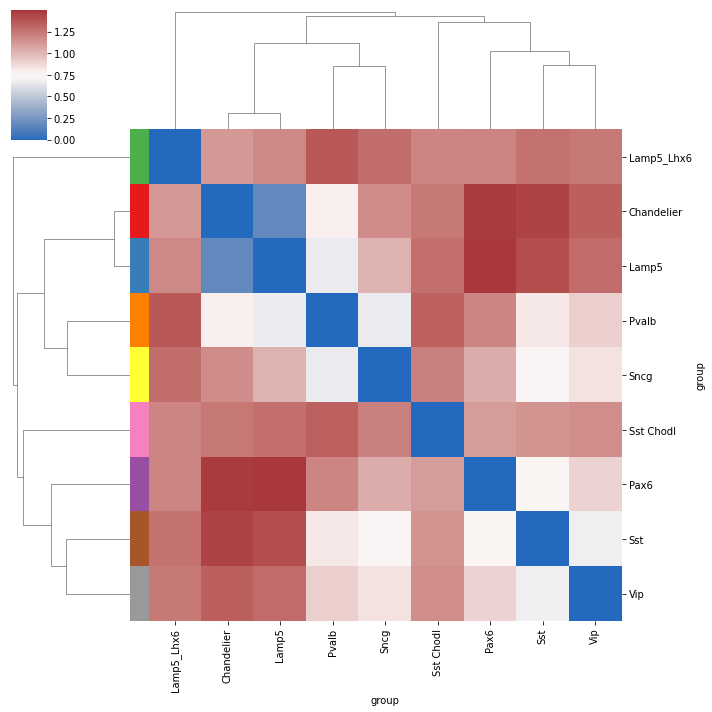

In [19]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [1]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


NameError: name 'pd' is not defined

In [124]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)


In [125]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [169]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [223]:
dj

0         1         2         3         4        \
classt        group                                                          
GABAergic     Chandelier -1.136939 -1.136939 -1.136939 -1.136939 -1.136939   
              Lamp5      -1.236200 -1.236200 -1.236200 -1.236200 -1.236200   
              Lamp5_Lhx6 -1.117338 -1.117338 -1.117338 -1.117338 -1.117338   
              Pax6       -1.161391 -1.161391 -1.161391 -1.161391 -1.161391   
              Pvalb      -1.159489 -1.159489 -1.159489 -1.159489 -1.159489   
              Sncg       -1.152952 -1.152952 -1.152952 -1.152952 -1.152952   
              Sst        -1.101333 -1.101333 -1.101333 -1.101333 -1.101333   
              Sst Chodl  -1.108935 -1.108935 -1.108935 -1.108935 -1.108935   
              Vip        -1.111711 -1.111711 -1.111711 -1.111711 -1.111711   
Glutamatergic L2/3 IT    -1.108780 -1.108780 -1.108780 -1.108780 -1.108780   
              L4 IT      -1.196050 -1.196050 -1.196050 -1.196050 -1.196050   
              L5 ET      -0.986197 -0.986197 -0.986197 -0.986197 -0.986197   
              L5 IT      -1.064799 -1.064799 -1.064799 -1.064799 -1.064799   
              L5/6 NP    -1.153001 -1.153001 -1.153001 -1.153001 -1.153001   
              L6 CT      -1.122397 -1.122397 -1.122397 -1.122397 -1.122397   
              L6 IT      -1.150222 -1.150222 -1.150222 -1.150222 -1.150222   
              L6 IT Car3 -1.212391 -1.212391 -1.212391 -1.212391 -1.212391   
              L6b        -1.167293 -1.167293 -1.167293 -1.167293 -1.167293   
Non-neuronal  Astro      -1.019331 -1.019331 -1.019331 -1.019331 -1.019331   
              Endo       -0.924028 -0.924028 -0.924028 -0.924028 -0.924028   
              Micro-PVM  -1.196533 -1.196533 -1.196533 -1.196533 -1.196533   
              OPC        -1.059687 -1.059687 -1.059687 -1.059687 -1.059687   
              Oligo      -1.014279 -1.014279 -1.014279 -1.014279 -1.014279   
              VLMC       -0.801605 -0.801605 -0.801605 -0.801605 -0.801605   

                           5         6         7         8         9        \
classt        group                                                          
GABAergic     Chandelier -1.136939 -1.136939 -1.136939 -1.136939 -1.136939   
              Lamp5      -1.236200 -1.236200 -1.236200 -1.236200 -1.236200   
              Lamp5_Lhx6 -1.117338 -1.117338 -1.117338 -1.117338 -1.117338   
              Pax6       -1.161391 -1.161391 -1.161391 -1.161391 -1.161391   
              Pvalb      -1.159489 -1.159489 -1.159489 -1.159489 -1.159489   
              Sncg       -1.152952 -1.152952 -1.152952 -1.152952 -1.152952   
              Sst        -1.101333 -1.101333 -1.101333 -1.101333 -1.101333   
              Sst Chodl  -1.108935 -1.108935 -1.108935 -1.108935 -1.108935   
              Vip        -1.111711 -1.111711 -1.111711 -1.111711 -1.111711   
Glutamatergic L2/3 IT    -1.108780 -1.108780 -1.108780 -1.108780 -1.108780   
              L4 IT      -1.196050 -1.196050 -1.196050 -1.196050 -1.196050   
              L5 ET      -0.986197 -0.986197 -0.986197 -0.986197 -0.986197   
              L5 IT      -1.064799 -1.064799 -1.064799 -1.064799 -1.064799   
              L5/6 NP    -1.153001 -1.153001 -1.153001 -1.153001 -1.153001   
              L6 CT      -1.122397 -1.122397 -1.122397 -1.122397 -1.122397   
              L6 IT      -1.150222 -1.150222 -1.150222 -1.150222 -1.150222   
              L6 IT Car3 -1.212391 -1.212391 -1.212391 -1.212391 -1.212391   
              L6b        -1.167293 -1.167293 -1.167293 -1.167293 -1.167293   
Non-neuronal  Astro      -1.019331 -1.019331 -1.019331 -1.019331 -1.019331   
              Endo       -0.924028 -0.924028 -0.924028 -0.924028 -0.924028   
              Micro-PVM  -1.196533 -1.196533 -1.196533 -1.196533 -1.196533   
              OPC        -1.059687 -1.059687 -1.059687 -1.059687 -1.059687   
              Oligo      -1.014279 -1.014279 -1.014279 -1.014279 -1.014279   
              VLMC       -0.801605 -0.801605 -0.

In [225]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dj = pd.concat(marker_mean_list)
dj = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]




ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [234]:
dj

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194  ... -1.289411   
                        Chandelier_2 -1.053312 -1.053312  ... -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027  ... -1.217027   
                        Lamp5_2      -1.263900 -1.263900  ... -1.263900   
                        Lamp5_3      -1.297502 -1.297502  ... -1.297502   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396  ... -0.305396   
                        Oligo_8      -1.109376 -1.109376  ... -0.560833   
                        Oligo_9      -1.065301 -1.065301  ... -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647  ... -1.100227   
                        VLMC_2       -0.630243 -0.630243  ... -0.630243   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.289411 -1.289411 -1.289411 -1.289411   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -0.560833 -0.560833 -0.560833 -0.560833   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.100227 -1.100227 -1.100227 -1.100227   
                     

In [235]:
features = dj.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
features = features.dropna()
features_sc =  StandardScaler().fit_transform(features)
umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


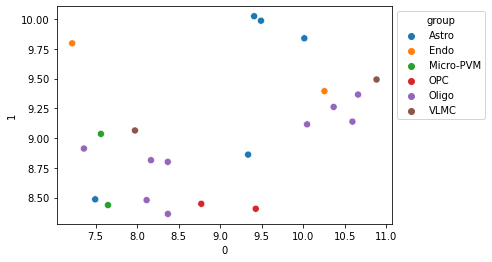

In [239]:

df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = dj.dropna().index.get_level_values('classt')
df_proj_2d['group'] = dj.dropna().index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Non-neuronal']
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
features = dj.loc[:, all_bins_std[all_bins_std >=0.05].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['group'] = dj.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [227]:
features.dropna()

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194  ... -1.289411   
                        Chandelier_2 -1.053312 -1.053312  ... -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027  ... -1.217027   
                        Lamp5_2      -1.263900 -1.263900  ... -1.263900   
                        Lamp5_3      -1.297502 -1.297502  ... -1.297502   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396  ... -0.305396   
                        Oligo_8      -1.109376 -1.109376  ... -0.560833   
                        Oligo_9      -1.065301 -1.065301  ... -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647  ... -1.100227   
                        VLMC_2       -0.630243 -0.630243  ... -0.630243   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.289411 -1.289411 -1.289411 -1.289411   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -0.560833 -0.560833 -0.560833 -0.560833   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.100227 -1.100227 -1.100227 -1.100227   
                     

In [228]:
features

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194  ... -1.289411   
                        Chandelier_2 -1.053312 -1.053312  ... -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027  ... -1.217027   
                        Lamp5_2      -1.263900 -1.263900  ... -1.263900   
                        Lamp5_3      -1.297502 -1.297502  ... -1.297502   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396  ... -0.305396   
                        Oligo_8      -1.109376 -1.109376  ... -0.560833   
                        Oligo_9      -1.065301 -1.065301  ... -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647  ... -1.100227   
                        VLMC_2       -0.630243 -0.630243  ... -0.630243   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.289411 -1.289411 -1.289411 -1.289411   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -0.560833 -0.560833 -0.560833 -0.560833   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.100227 -1.100227 -1.100227 -1.100227   
                     

In [217]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()

#dj = dj[dj['classt']!='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
#dj = dj[dj['classt']=='Glutamatergic']


from sklearn.decomposition import PCA
features = dj.loc[:, all_bins_std[all_bins_std >= 0].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
#pca = PCA(n_components=2)
#proj_2da = pca.fit_transform(features_sc)
umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()


In [195]:
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


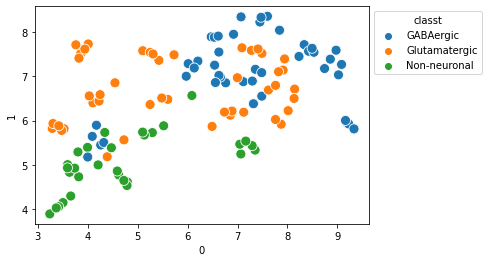

In [218]:

ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


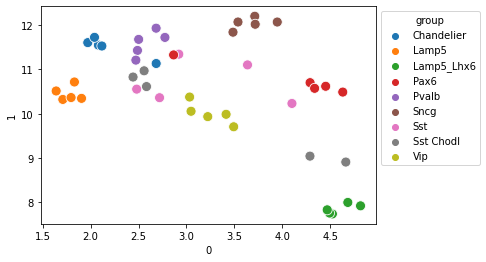

In [213]:
df_proj_2dat = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dat[0], df_proj_2dat[1],
    hue=df_proj_2dat['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


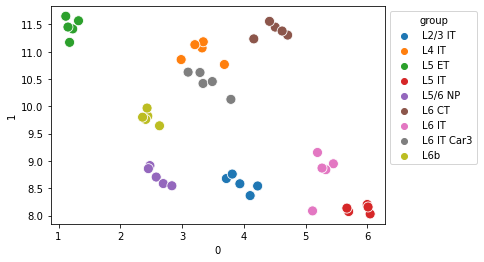

In [214]:
df_proj_2dat = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dat[0], df_proj_2dat[1],
    hue=df_proj_2dat['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


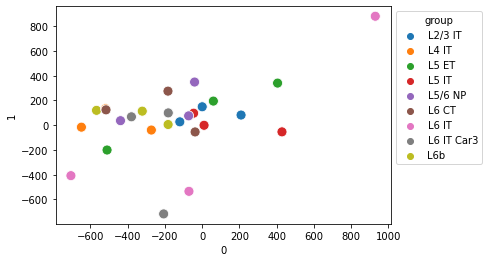

In [189]:
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()
df_proj_2da = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [176]:


df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('classt')


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


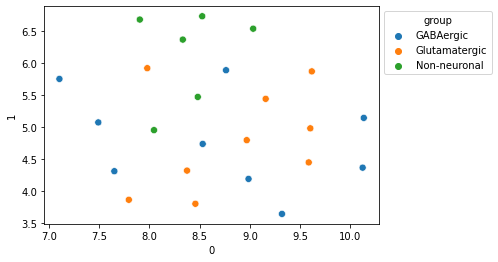

In [177]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


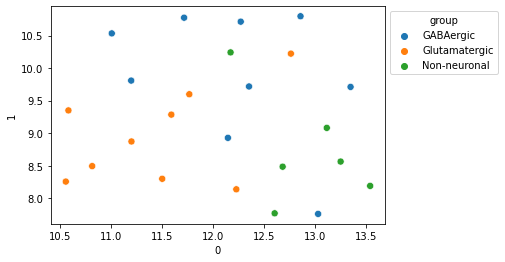

In [172]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [157]:
df_gene_tp_all_info_mean

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.180019 -1.180019 -1.180019 -1.180019   
                        Chandelier_2 -0.943137 -0.943137 -0.943137 -0.943137   
             Lamp5      Lamp5_1      -1.083808 -1.083808 -1.083808 -1.083808   
                        Lamp5_2      -1.021739 -1.021739 -1.021739 -1.021739   
                        Lamp5_3      -1.036233 -1.036233 -1.036233 -1.036233   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.499861 -0.499861 -0.499861 -0.499861   
                        Oligo_8      -0.935771 -0.935771 -0.935771 -0.935771   
                        Oligo_9      -1.019388 -1.019388 -1.019388 -1.019388   
             VLMC       VLMC_1       -1.050502 -1.050502 -1.050502 -1.050502   
                        VLMC_2       -0.881856 -0.881856 -0.881856 -0.881856   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.180019 -1.180019 -1.180019 -1.180019   
                        Chandelier_2 -0.943137 -0.943137 -0.943137 -0.943137   
             Lamp5      Lamp5_1      -1.083808 -1.083808 -1.083808 -1.083808   
                        Lamp5_2      -1.021739 -1.021739 -1.021739 -1.021739   
                        Lamp5_3      -1.036233 -1.036233 -1.036233 -1.036233   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.499861 -0.499861 -0.499861 -0.499861   
                        Oligo_8      -0.935771 -0.935771 -0.935771 -0.935771   
                        Oligo_9      -1.019388 -1.019388 -1.019388 -1.019388   
             VLMC       VLMC_1       -1.050502 -1.050502 -1.050502 -1.050502   
                        VLMC_2       -0.881856 -0.881856 -0.881856 -0.881856   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.180019 -1.180019  ... -1.194689   
                        Chandelier_2 -0.943137 -0.943137  ... -0.964292   
             Lamp5      Lamp5_1      -1.083808 -1.083808  ... -1.092302   
                        Lamp5_2      -1.021739 -1.021739  ... -1.044661   
                        Lamp5_3      -1.036233 -1.036233  ... -1.052276   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.499861 -0.499861  ... -0.484658   
                        Oligo_8      -0.935771 -0.935771  ... -0.911353   
                        Oligo_9      -1.019388 -1.019388  ... -1.027203   
             VLMC       VLMC_1       -1.050502 -1.050502  ... -1.024408   
                        VLMC_2       -0.881856 -0.881856  ... -0.883334   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.194689 -1.194689 -1.194689 -1.194689   
                        Chandelier_2 -0.964292 -0.964292 -0.964292 -0.964292   
             Lamp5      Lamp5_1      -1.092302 -1.092302 -1.092302 -1.092302   
                        Lamp5_2      -1.044661 -1.044661 -1.044661 -1.044661   
                        Lamp5_3      -1.052276 -1.052276 -1.052276 -1.052276   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.484658 -0.484658 -0.484658 -0.484658   
                        Oligo_8      -0.911353 -0.911353 -0.911353 -0.911353   
                        Oligo_9      -1.027203 -1.027203 -1.027203 -1.027203   
             VLMC       VLMC_1       -1.024408 -1.024408 -1.024408 -1.024408   
                     

In [161]:
#df_gene_tp_all_info_mean[df_proj_2d['classt']=='Glutamatergic']
dj = df_gene_tp_all_info_mean.reset_index()
dj = dj[dj['classt']=='Glutamatergic']
features = dj.loc[:, all_bins_std[all_bins_std >=0.05].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)

umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['group'] = dj['group'].tolist()
#df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')

In [152]:
df_proj_2da = df_proj_2d[df_proj_2d['classt']=='GABAergic']

In [155]:
df_proj_2da = df_proj_2d[df_proj_2d['classt']=='Glutamatergic']

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


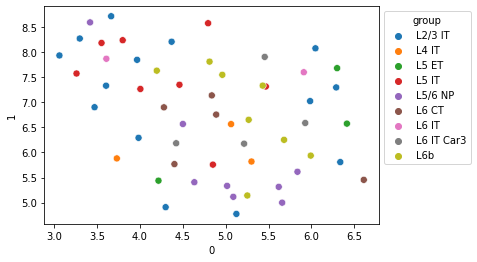

In [163]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


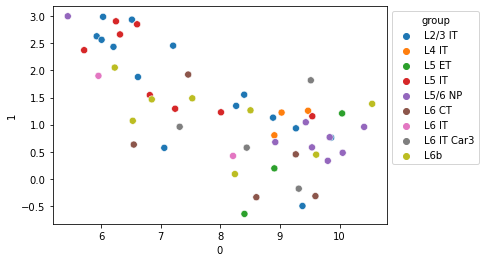

In [156]:
ax=sns.scatterplot(
    df_proj_2da[0],df_proj_2da[1],
    hue=df_proj_2da['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [91]:
umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

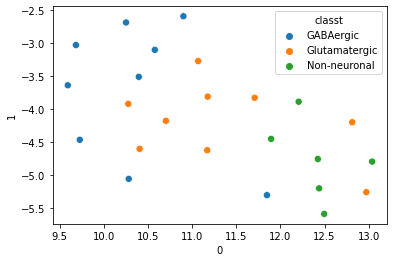

In [92]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=50
)

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

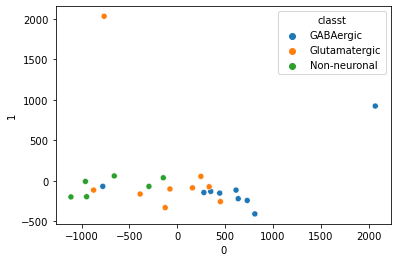

In [128]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

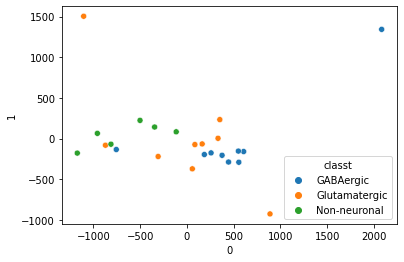

In [110]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

<ipython-input-93-fade4fa8ee78>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


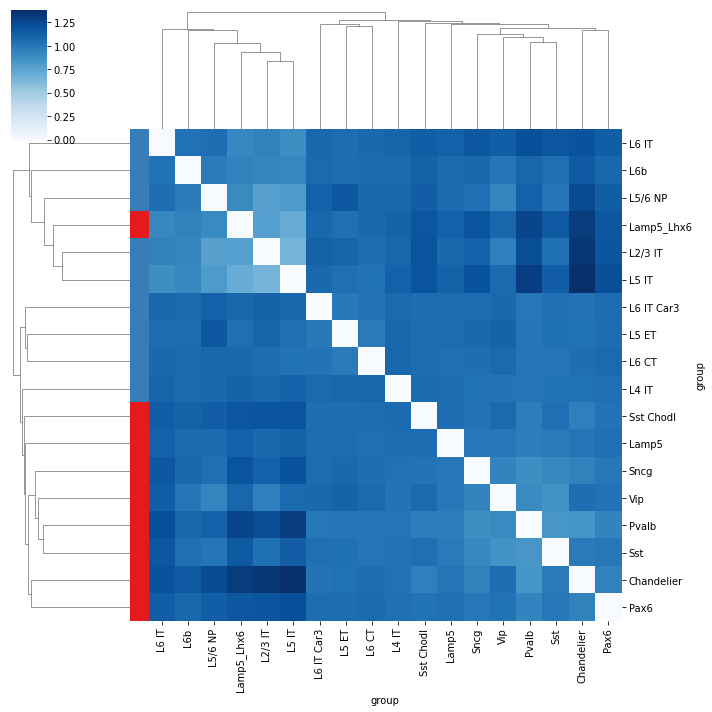

In [93]:


features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
#features = pd.concat([features[0:8] , features[19:25]])
features = pd.concat([features[0:18]])
features_sc =  StandardScaler().fit_transform(features)

lut = dict(zip( features.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =features.index.get_level_values('classt').map(lut)

R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="Blues", row_colors=row_colors)


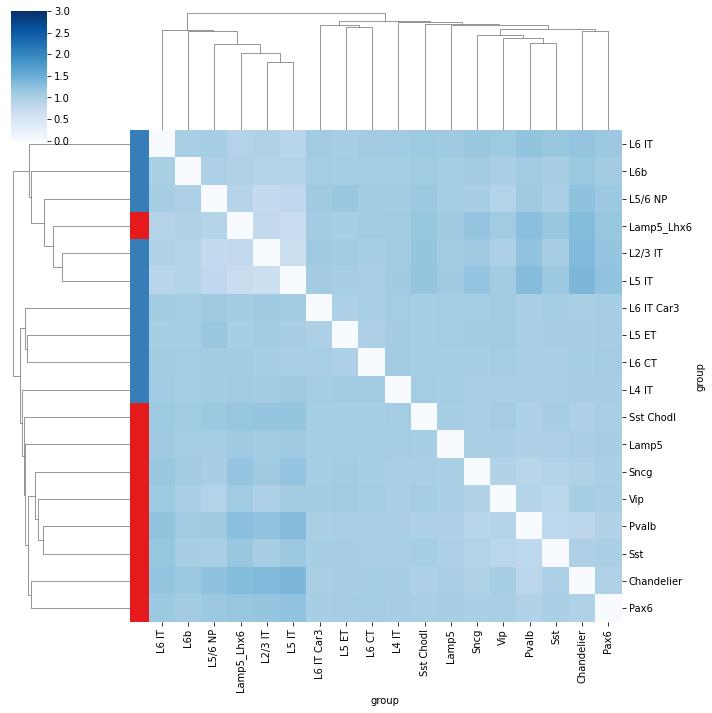

In [96]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="Blues", row_colors=row_colors, vmax=3)

<ipython-input-111-1b3efc6a3540>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


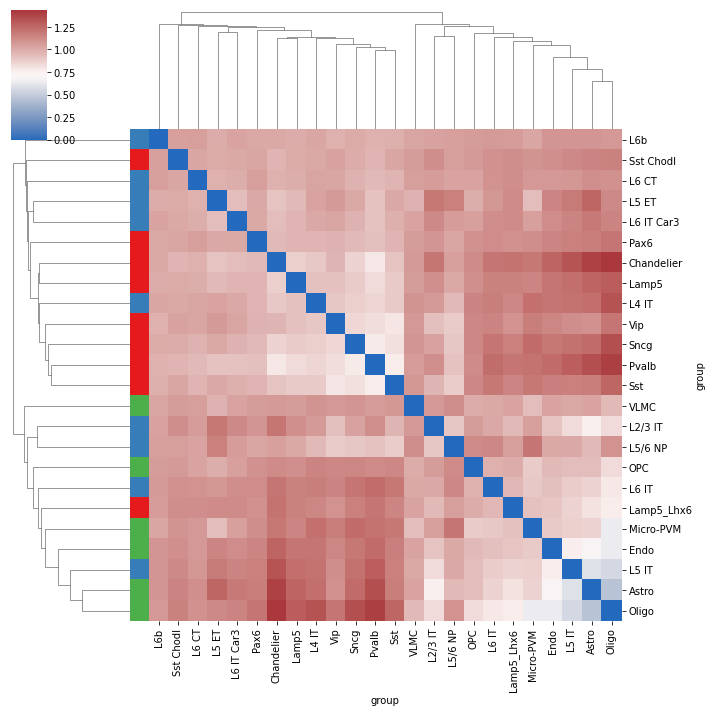

In [111]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
#features = pd.concat([features[0:8] , features[19:25]])

features_sc =  StandardScaler().fit_transform(features)

lut = dict(zip( features.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =features.index.get_level_values('classt').map(lut)

R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-129-1b3efc6a3540>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


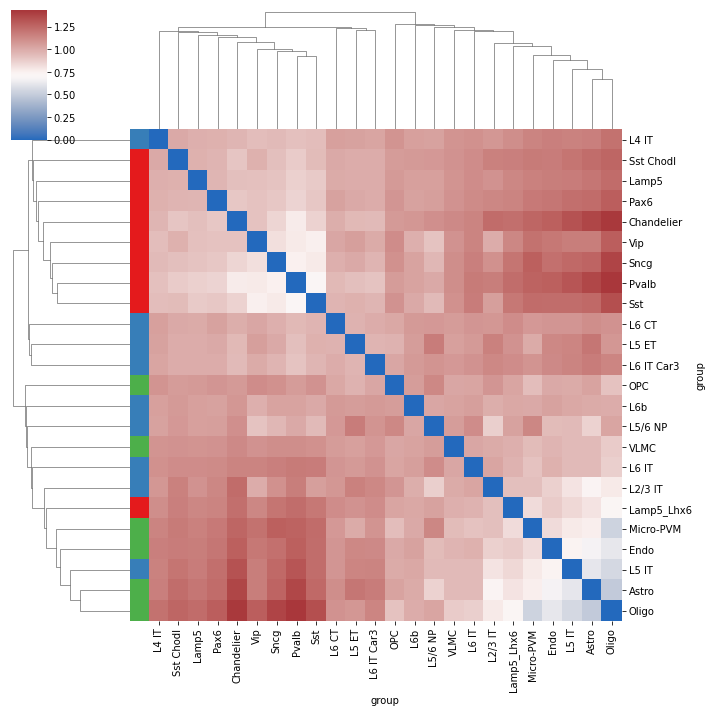

In [129]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
#features = pd.concat([features[0:8] , features[19:25]])

features_sc =  StandardScaler().fit_transform(features)

lut = dict(zip( features.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =features.index.get_level_values('classt').map(lut)

R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


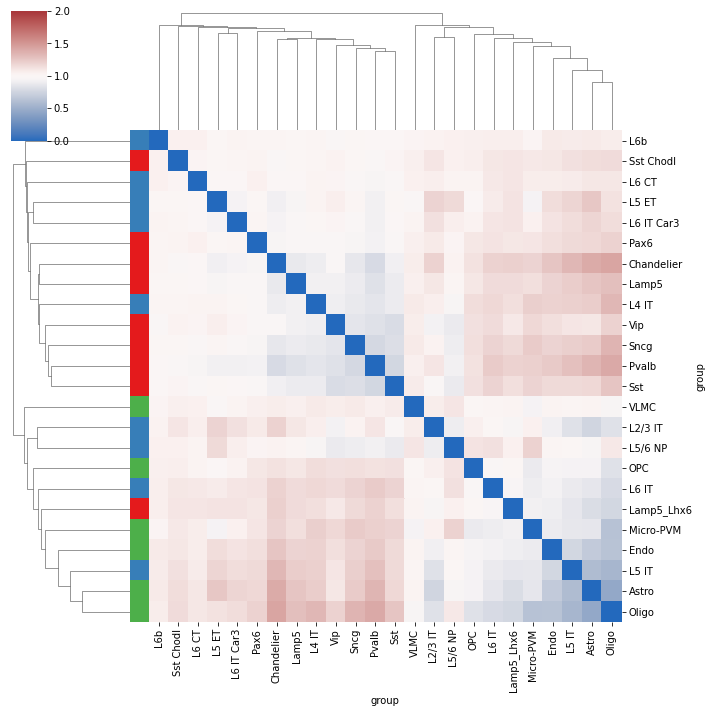

In [116]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors, vmax=2)


In [112]:
a

NameError: name 'a' is not defined

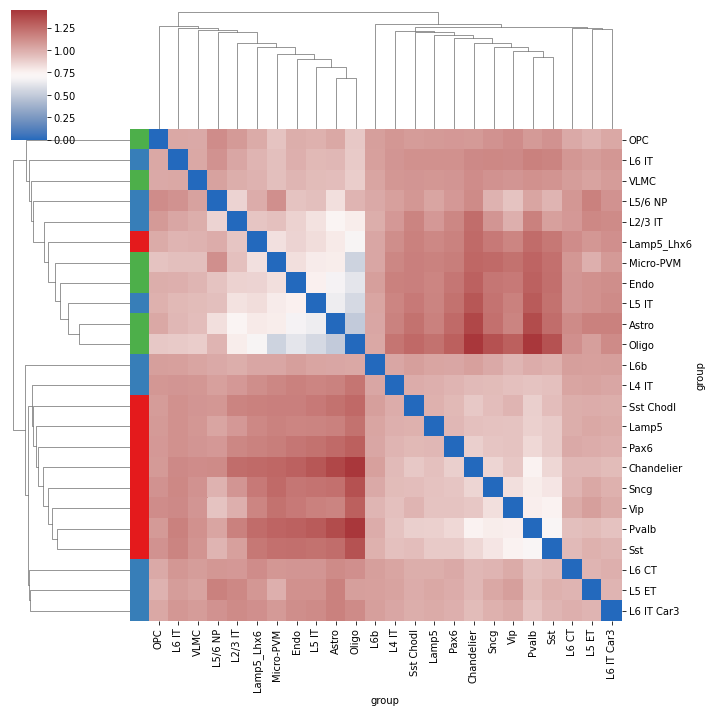

In [98]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

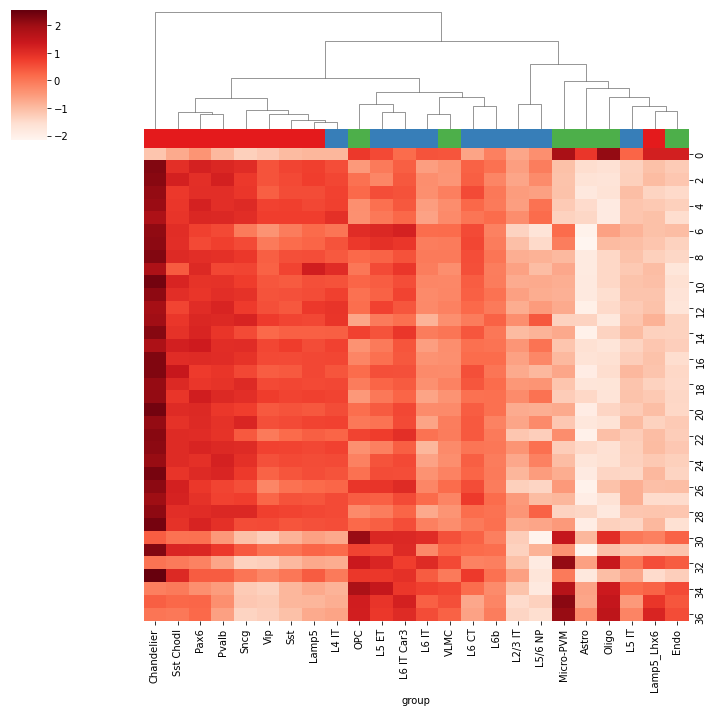

In [72]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='Reds')


(18, 18)
(18, 3)
0.6666666666666667
0.006172839506172867


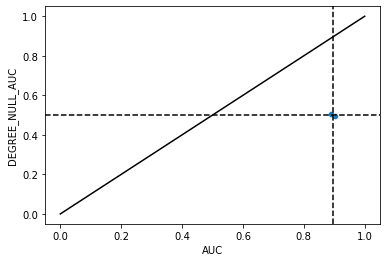

In [74]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features =features[0:18]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=features .index.get_level_values('group'), columns = features .index.get_level_values('group'))


df_go = df_gene_tp_all_info_mean[[0]].reset_index()

df_go['val'] = 1

df_go_table = df_go.pivot_table(index='group', columns='classt', values='val', aggfunc='sum')
df_go_table.fillna(0, inplace=True)


df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [70]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.888889        42.871384         0.444444  0.000165
Glutamatergic  0.392593        42.942661         0.525926  0.160653
Non-neuronal   0.962963        43.007426         0.537037  0.000138

In [68]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.925926        10.209226         0.385185  0.000042
Glutamatergic  0.392593        10.351934         0.466667  0.115658
Non-neuronal   0.916667        10.467739         0.685185  0.000532